In [1]:
# Load packages
import numpy as np, sys
from scipy import ndimage, interpolate
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, '../saxstats/')

In [3]:
# Load denss
import saxstats
DENSS_GPU=False

In [72]:
# Apo density - not changing
rho_apo, side = saxstats.read_mrc('2cm7_apo.mrc')

# Ligand density - ground truth
rho_ligand, side = saxstats.read_mrc('2cm7_ligand.mrc')

# Naive mask
rho_mask, side = saxstats.read_mrc('2cm7_ligand.mrc')
ligand_ref = rho_mask > 0
kernel = ndimage.generate_binary_structure(3, 2)
lig_mask = ndimage.binary_dilation(ligand_ref, structure=kernel)
lig_mask *= rho_apo < 0.2

saxstats.write_mrc(lig_mask, side, '2cm7_ligand_mask.mrc')

# Data
q, I, sigq, Ifit, file_dmax, isfit = saxstats.loadProfile('2cm7.dat', units='A')

dmax = 36
oversampling = 3
voxel = 1
D = dmax

#Initialize variables
side = oversampling*D
halfside = side/2

n = int(side/voxel)
print(n)
#want n to be even for speed/memory optimization with the FFT, ideally a power of 2, but wont enforce that
if n%2==1:
    n += 1
#store n for later use if needed
nbox = n

dx = side/n
dV = dx**3
V = side**3
x_ = np.linspace(-halfside,halfside,n)
x,y,z = np.meshgrid(x_,x_,x_,indexing='ij')
r = np.sqrt(x**2 + y**2 + z**2)
rho_apo *= dV
rho_ligand *= dV

108


In [73]:
apo_ne = np.sum(rho_apo)
print(apo_ne)
lig_ne = np.sum(rho_ligand)
print(lig_ne)
all_ne = apo_ne + lig_ne

15994.0
229.99998


In [141]:
df = 1/side
qx_ = np.fft.fftfreq(x_.size)*n*df*2*np.pi
#print(qx_, np.fft.fftshift(qx_))
qx, qy, qz = np.meshgrid(qx_,qx_,qx_,indexing='ij')
qr = np.sqrt(qx**2+qy**2+qz**2)
qmax = np.max(qr)
qstep = np.min(qr[qr>0]) - 1e-8 #subtract a tiny bit to deal with floating point error
nbins = int(qmax/qstep)
qbins = np.linspace(0,nbins*qstep,nbins+1)
#create modified qbins and put qbins in center of bin rather than at left edge of bin.
qbinsc = np.copy(qbins)
qbinsc[1:] += qstep/2.
#create an array labeling each voxel according to which qbin it belongs
qbin_labels = np.searchsorted(qbins,qr,"right")
qbin_labels -= 1
#allow for any range of q data
qdata = qbinsc[np.where( (qbinsc>=q.min()) & (qbinsc<=q.max()) )]
Idata = np.interp(qdata,q,I)

# qextend = qbinsc[qbinsc>=qdata.max()]
# Iextend = qextend**-4
# Iextend = Iextend/Iextend[0] * Idata[-1]
# qdata = np.concatenate((qdata,qextend[1:]))
# Idata = np.concatenate((Idata,Iextend[1:]))

#create list of qbin indices just in region of data for later F scaling
qbin_args = np.in1d(qbinsc,qdata,assume_unique=True)
qba = np.copy(qbin_args) #just for brevity when using it later
sigqdata = np.interp(qdata,q,sigq)


In [142]:
Idata.shape

(53,)

In [76]:
scale_factor = all_ne**2 / Idata[0]
Idata *= scale_factor
sigqdata *= scale_factor
I *= scale_factor
sigq *= scale_factor

Text(0, 0.5, 'Intensity')

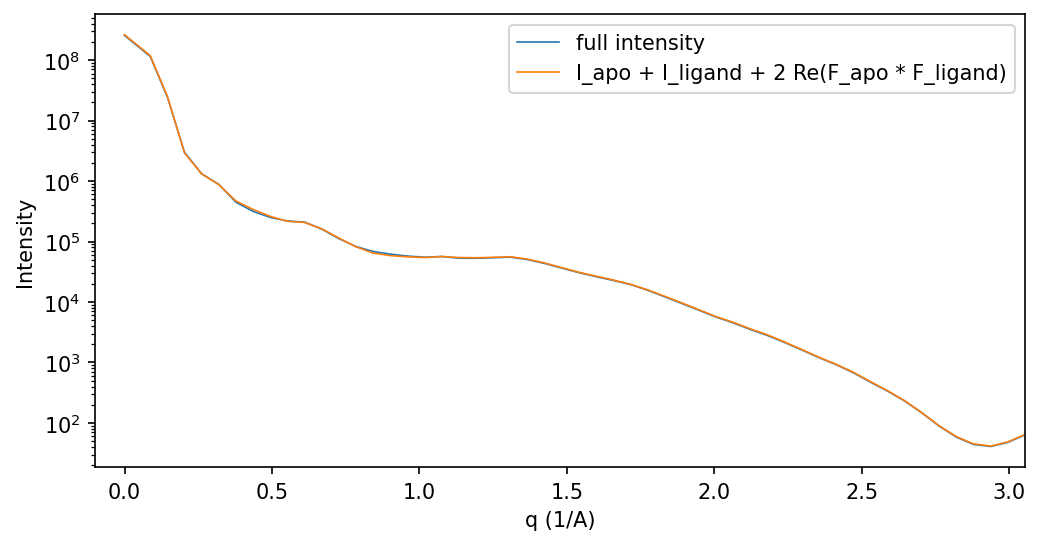

In [78]:
## Try out different ways of data fitting
rho_apo_ = np.fft.fftn(rho_apo)
rho_ligand_ = np.fft.fftn(rho_ligand)

I3D_full_ = np.abs(rho_apo_ + rho_ligand) ** 2
I3D_apo_ = np.abs(rho_apo_) ** 2
I3D_ligand_ = np.abs(rho_ligand_) ** 2
I3D_cross_w_  = np.abs(rho_apo_.conjugate() * rho_ligand_) * 2
I3D_cross_ = (rho_apo_.conjugate() * rho_ligand_).real * 2
Imean_full_ = saxstats.mybinmean(I3D_full_, qbin_labels, DENSS_GPU)
Imean_apo_ = saxstats.mybinmean(I3D_apo_, qbin_labels, DENSS_GPU)
Imean_ligand_ = saxstats.mybinmean(I3D_ligand_, qbin_labels, DENSS_GPU)
Imean_cross_ = saxstats.mybinmean(I3D_cross_, qbin_labels, DENSS_GPU)
Imean_cross_w_ = saxstats.mybinmean(I3D_cross_w_, qbin_labels, DENSS_GPU)

plt.figure(figsize=(8,4), dpi=150)
# plt.plot(qdata, Idata, lw=0.8)
plt.plot(qdata, Imean_full_[qba], lw=0.8, label='full intensity')
plt.plot(qdata, Imean_apo_[qba] + Imean_ligand_[qba] + Imean_cross_[qba], lw=0.8, label='I_apo + I_ligand + 2 Re(F_apo * F_ligand)')
# plt.plot(qdata, Imean_apo_[qba] + Imean_ligand_[qba] + Imean_cross_w_[qba], lw=0.8, label='I_apo + I_ligand + 2 abs(F_apo * F_ligand)')
plt.xlim([-0.1, np.max(q)])
plt.yscale('log')
plt.legend()
plt.xlabel('q (1/A)')
plt.ylabel('Intensity')


Text(0, 0.5, 'Intensity')

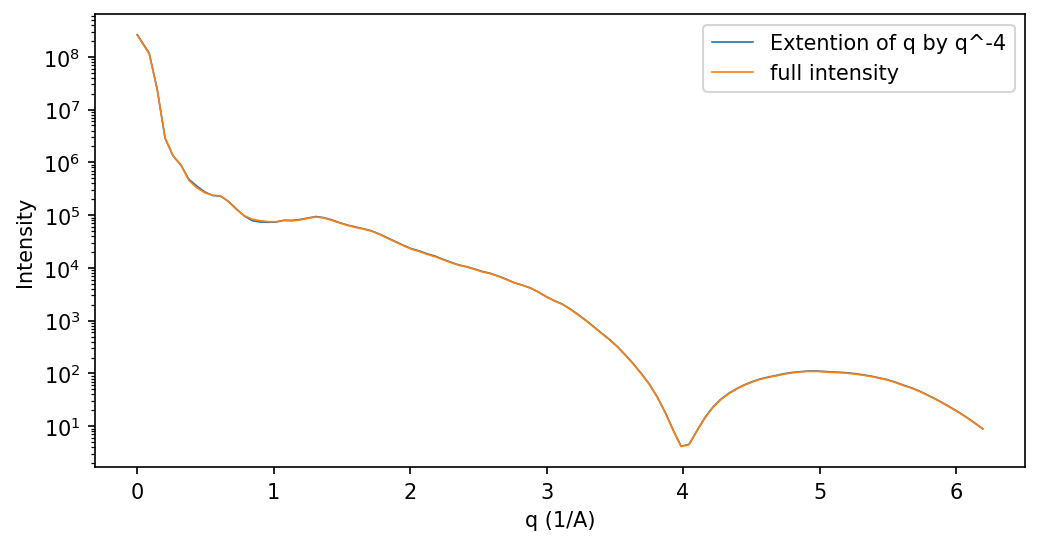

In [13]:
## Try out different ways of data fitting
rho_apo_ = np.fft.fftn(rho_apo)
rho_ligand_ = np.fft.fftn(rho_ligand)

I3D_full_ = np.abs(rho_apo_ + rho_ligand) ** 2
Imean_full_ = saxstats.mybinmean(I3D_full_, qbin_labels, DENSS_GPU)

plt.figure(figsize=(8,4), dpi=150)
plt.plot(qdata, Idata, lw=0.8, label='Extention of q by q^-4')
plt.plot(qdata, Imean_full_[qba], lw=0.8, label='full intensity')
# plt.plot(qdata, Imean_apo_[qba] + Imean_ligand_[qba] + Imean_cross_[qba], lw=0.8, label='I_apo + I_ligand + 2 Re(F_apo * F_ligand)')
# plt.plot(qdata, Imean_apo_[qba] + Imean_ligand_[qba] + Imean_cross_w_[qba], lw=0.8, label='I_apo + I_ligand + 2 abs(F_apo * F_ligand)')
# plt.xlim([-0.1, np.max(q)])
plt.yscale('log')
plt.legend()
plt.xlabel('q (1/A)')
plt.ylabel('Intensity')


In [13]:
rho_apo_ = np.fft.fftn(rho_apo)
I3D_apo_ = np.abs(rho_apo_)**2

In [14]:
rho_ligand_ = np.fft.fftn(rho_ligand)
I3D_ligand_ = np.abs(rho_ligand_)**2

In [15]:
rho_all_ = rho_apo_ + rho_ligand_
I3D_all_ = np.abs(rho_all_)**2

In [16]:
Imean_apo_ = saxstats.mybinmean(I3D_apo_, qbin_labels, DENSS_GPU)

In [17]:
Imean_ligand_ = saxstats.mybinmean(I3D_ligand_, qbin_labels, DENSS_GPU)

In [18]:
Imean_all_ = saxstats.mybinmean(I3D_all_, qbin_labels, DENSS_GPU)

561329.9107729748


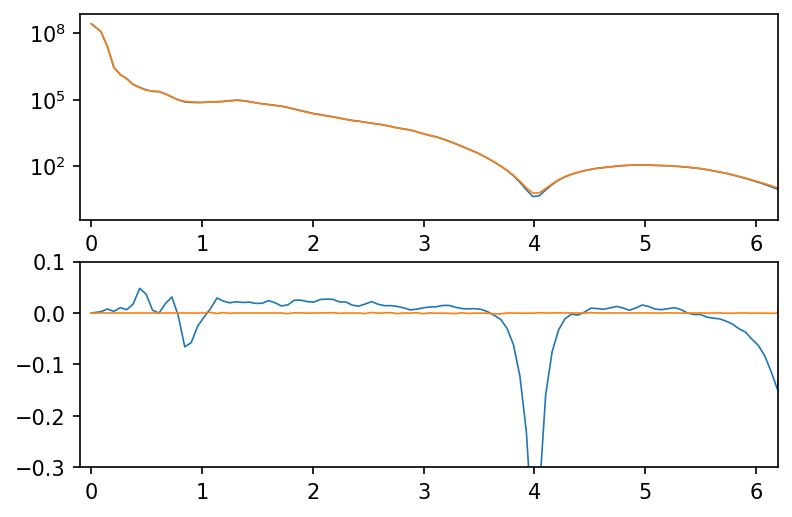

In [522]:
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2

Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])
# plt.yscale('log')
print(np.sum(Idata - Imean_guess_[qba]))

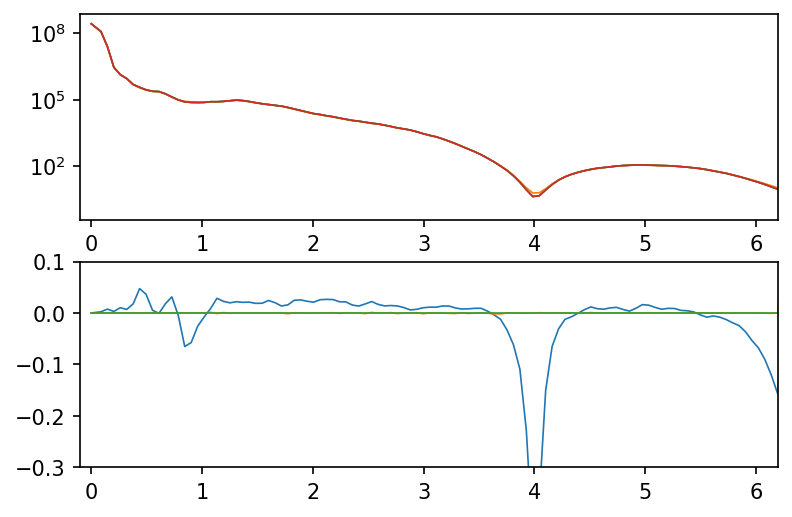

In [525]:
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])


factors = np.sqrt(Idata / Imean_guess_[qba])
rho_guess_all_ = (rho_guess_ + rho_apo_) * factors[qbin_labels]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_all_[qba], lw=0.8)
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)


rho_guess_mod_ = rho_guess_ * factors[qbin_labels]
rho_guess_mod_ += rho_apo_ * (factors[qbin_labels] - 1)
rho_apo_mod_ = rho_apo_
I3D_guess_mod_ = np.abs(rho_guess_mod_)**2
I3D_apo_mod_ = np.abs(rho_apo_mod_)**2
Imean_guess_mod_ = saxstats.mybinmean(I3D_guess_mod_, qbin_labels, DENSS_GPU)
Imean_apo_mod_ = saxstats.mybinmean(I3D_apo_mod_, qbin_labels, DENSS_GPU)
I3D_cross_mod_ = 2 * (rho_apo_mod_ * rho_guess_mod_.conjugate()).real
Imean_cross_mod_ = saxstats.mybinmean(I3D_cross_mod_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_mod_[qba] + Imean_apo_mod_[qba] + Imean_cross_mod_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_mod_[qba] - Imean_apo_mod_[qba] - Imean_cross_mod_[qba])/Idata[qba], lw=0.8)

In [23]:
rho_prime = np.fft.ifftn(rho_guess_mod_)
saxstats.write_mrc(rho_prime.real, side, 'test_back.mrc')

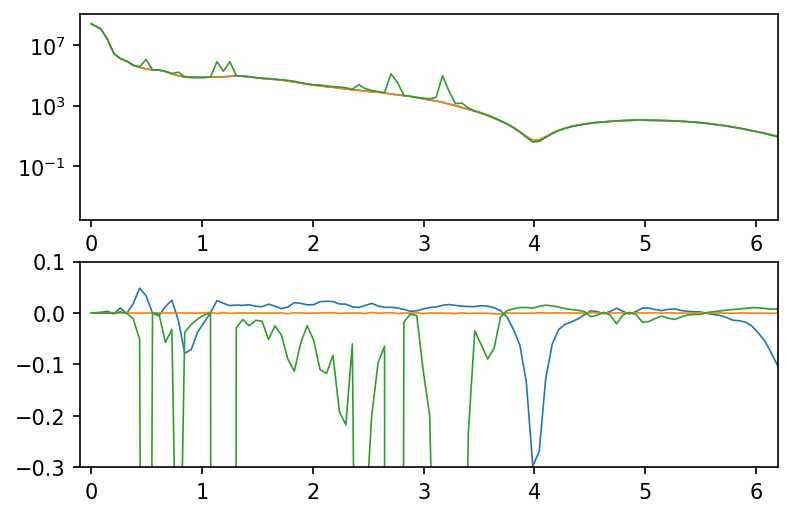

In [21]:
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])


factors = (Idata - Imean_apo_[qba]) / (Imean_guess_[qba] - Imean_apo_[qba])
# factors = (np.sqrt(Idata) - np.sqrt(Imean_apo_[qba])) / (np.sqrt(Imean_guess_[qba]) - np.sqrt(Imean_apo_[qba]))
# factors = np.sqrt(Idata / Imean_guess_[qba])
rho_guess_ *= factors[qbin_labels]# * lig_ne / apo_ne
rho_guess_all_ = (rho_guess_ + rho_apo_)
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_all_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_apo_[qba])/Idata[qba], lw=0.8)


In [136]:
def raster_unit_sphere(num=200):
    L = np.sqrt(num * np.pi);
    pt = []
    for i in range(num):
        h = 1.0 - (2.0 * i + 1.0) / num
        p = np.arccos(h)
        t = L * p
        xu = np.sin(p) * np.cos(t)
        yu = np.sin(p) * np.sin(t)
        zu = np.cos(p)
        pt.append([xu, yu, zu])

    return np.array(pt)


In [137]:
def mypadbinsum(x, bins, nbins, DENSS_GPU=False):
    xsum = np.bincount(bins.ravel(), x.ravel())
    #xcount = cp.bincount(bins.ravel())
    xret = np.empty(nbins)
    xret[:] = np.nan
    #print(f'bins max {bins.max()}, len xsum {len(xsum)}, nbins {nbins}')
    xret[int(bins.max())+1-len(xsum):int(bins.max())+1] = xsum
    return xret


In [24]:
# Determine patches
num_patch = 26
qpatch_labels = np.zeros_like(qbin_labels)
qxyz = np.array([qx.flatten(), qy.flatten(), qz.flatten()]).T
unitr = raster_unit_sphere(num_patch)
#print(unitr)
closest_patch = np.argmax(qxyz @ unitr.T, axis=1).reshape(rho_apo.shape)




/opt/anaconda3/envs/UB/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/UB/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


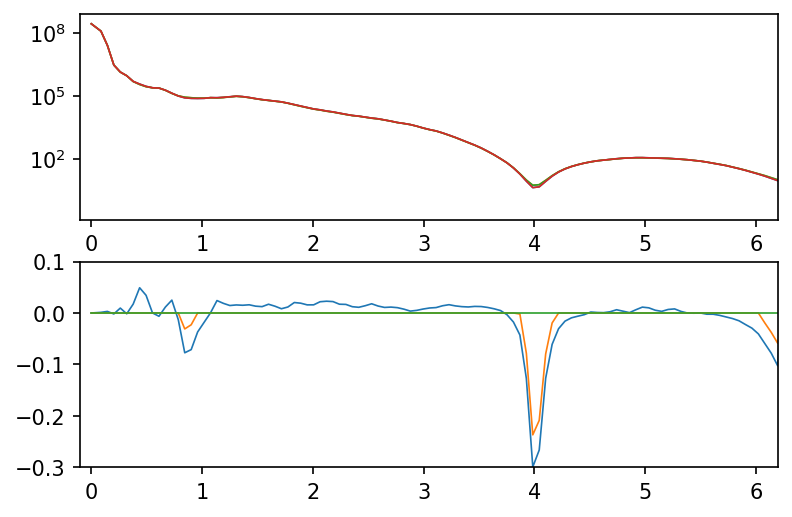

In [34]:
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])


# Calculate binned mean of that patch
patch_n = 10
Isum_this = mypadbinsum(I3D_guess_[closest_patch==patch_n], qbin_labels[closest_patch==patch_n], nbins+1, DENSS_GPU=DENSS_GPU)
# Calculate binned mean of !that patch
Isum_rest = mypadbinsum(I3D_guess_[closest_patch!=patch_n], qbin_labels[closest_patch!=patch_n], nbins+1, DENSS_GPU=DENSS_GPU)

Idata3D = Idata[qbin_labels]
Isum_data = mypadbinsum(Idata3D, qbin_labels, nbins+1, DENSS_GPU=DENSS_GPU)

#print(Imean_this.shape, Imean_rest.shape, Idata.shape)
# Calculate scaling factor of that patch, to (Idata - mean(!that patch))
factors_this = np.sqrt((Isum_data - Isum_rest)/Isum_this) #FIXME: Get the scaling right
# Limit to a preset limit of 0.2 - 5
factors_this[Isum_data <= Isum_rest] = 0.2
factors_this[np.isnan(factors_this)] = 1
factors_this[factors_this < 0.2] = 0.2
factors_this[factors_this > 5] = 5
#factors_this = factors_this[qbin_labels.ravel()] * F_mask.ravel() + (1 - F_mask.ravel())
# print(factors_this)

# Multiply that patch with this scaling factor
rho_guess_all_ = (rho_guess_ + rho_apo_)
rho_guess_all_[closest_patch==patch_n] *= factors_this[qbin_labels][closest_patch==patch_n]
#F.ravel()[closest_patch==patch_n] *= factors_this.ravel()[closest_patch==patch_n]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU=DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)


factors = np.sqrt(Idata / Imean_guess_all_[qba])
rho_guess_all_ = rho_guess_all_ * factors[qbin_labels]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_all_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)



In [39]:
rho_guess_all = np.fft.ifftn(rho_guess_all_).real
rho_guess_all -= rho_apo
rho_guess_all[~lig_mask] = 0
rho_guess_all[rho_guess_all < 0] = 0

In [40]:
saxstats.write_mrc(rho_guess_all, side, 'test_one_step.mrc')

In [41]:
# Try getting the gradient right

In [61]:
# Get where changable voxels are
R = np.array([x.flatten(), y.flatten(), z.flatten()]).T
R = R[lig_mask.flatten()]
R_idx = np.where(lig_mask.flatten())[0]
print(R_idx)

[5432927 5432928 5432929 ... 6600831 6600832 6600833]


(-0.3, 0.1)

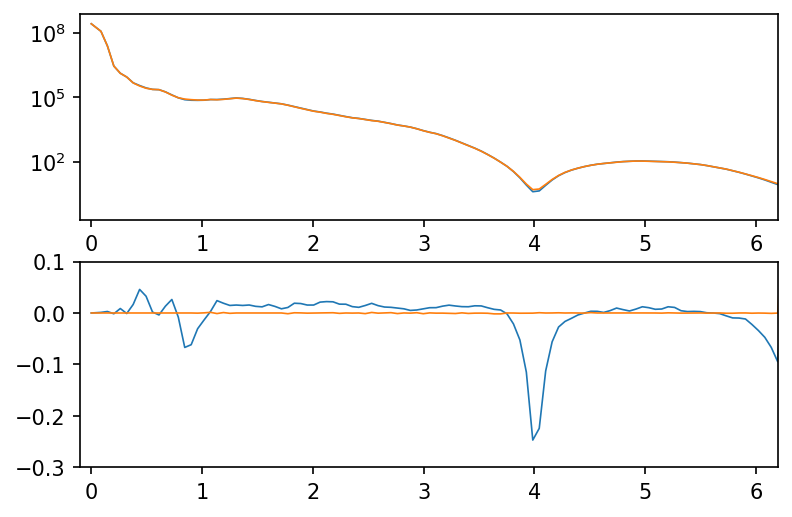

In [138]:
# Get I_calc
rho_guess = rho_ligand.copy()
rho_guess += np.random.random(rho_guess.shape) * 0.3

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne * 1

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])

In [139]:
# Get a uniform sphere
num_J = 1200
Q = raster_unit_sphere(num_J)

In [140]:
d = rho_guess.flatten()[R_idx]
RQ = R @ Q.T

In [194]:
# Write gradient down
R = np.array([x.flatten(), y.flatten(), z.flatten()]).T
R = R[lig_mask.flatten()]
R_idx = np.where(lig_mask.flatten())[0]

num_J = 1200
Q = raster_unit_sphere(num_J)
RQ = R @ Q.T
rho_guess = rho_ligand.copy()
rho_guess += np.random.random(rho_guess.shape) * 0.3

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne


qROI = np.array(range(0, 100))

rho_guess_ = np.fft.fftn(rho_guess)
rho_guess_[rho_guess_==0] = 1e-16
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)


chi_r = saxstats.mysum(((Imean_guess_[qba][qROI]-Idata[qba][qROI])/sigqdata[qba][qROI])**2, DENSS_GPU=DENSS_GPU)/Idata[qba][qROI].size
chi = saxstats.mysum(((Imean_guess_[qba]-Idata[qba])/sigqdata[qba])**2, DENSS_GPU=DENSS_GPU)/Idata[qba].size
print(f'Initial: {chi_r:.3f} {chi:.3f}', end='\t\t')

p = rho_apo.flatten()[R_idx]


for step in range(1):

    rho_guess_out = rho_guess / dV
    saxstats.write_mrc(rho_guess_out, side, f'rho_guess_step{step}.mrc')
    
    d = rho_guess.flatten()[R_idx] + p
    G_d = np.zeros((len(R)))
    
    for idx in qROI:
        q_pt = q[idx]
        print(idx, end=' ')
        A = np.cos(q_pt * RQ) # (N, num_J)
        B = np.sin(q_pt * RQ)
        G_d_pt = d.T @ A @ A.T + d.T @ B @ B.T
        G_d_pt *= (Imean_guess_[idx] - Idata[idx])
        G_d_pt *= (4 / num_J / sigqdata[idx] / sigqdata[idx])
        G_d += G_d_pt
    print()
        
    rho_guess_mod = rho_guess.copy().flatten()
    rho_guess_mod[R_idx] -= G_d * 0.1
    rho_guess_mod[rho_guess_mod < 0] = 0
    rho_guess_mod /= np.sum(rho_guess_mod)
    rho_guess_mod *= lig_ne
    
    rho_guess_mod = rho_guess_mod.reshape(rho_guess.shape)

    rho_guess_mod_ = np.fft.fftn(rho_guess_mod)
    rho_guess_mod_[rho_guess_mod_==0] = 1e-16
    I3D_guess_mod_ = np.abs(rho_apo_ + rho_guess_mod_)**2
    Imean_guess_mod_ = saxstats.mybinmean(I3D_guess_mod_, qbin_labels, DENSS_GPU)

    rho_guess = rho_guess_mod.copy()

    Imean_guess_ = Imean_guess_mod_.copy()
    
    chi_r = saxstats.mysum(((Imean_guess_mod_[qba][qROI]-Idata[qba][qROI])/sigqdata[qba][qROI])**2, DENSS_GPU=DENSS_GPU)/Idata[qba][qROI].size
    chi = saxstats.mysum(((Imean_guess_mod_[qba]-Idata[qba])/sigqdata[qba])**2, DENSS_GPU=DENSS_GPU)/Idata[qba].size
    print(f'Step {step}: {chi_r:.3f} {chi:.3f}', end='\t\t')
    #     print(G_d_pt)
#     print(G_d)
else:
    rho_guess_out = rho_guess / dV
    saxstats.write_mrc(rho_guess_out, side, f'rho_guess_step{step+1}.mrc')

Initial: 3.791 28.107		0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
Step 0: 12773.648 6810.673		

(-0.3, 0.1)

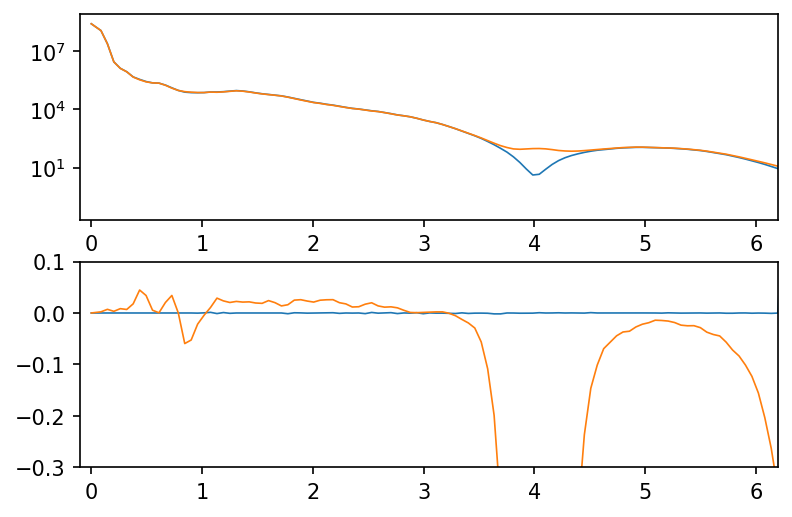

In [196]:
fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])

In [140]:
qba

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [159]:
# Write gradient down - log form
rho_apo, side = saxstats.read_mrc('2cm7_apo.mrc')
rho_guess, side = saxstats.read_mrc('rho_ligand_guess4.mrc')
# rho_guess = np.random.random(rho_apo.shape)
rho_guess[~lig_mask] = 0
rho_guess = rho_guess / np.sum(rho_guess) * lig_ne
rho_apo *= dV
# rho_guess *= dV
rho_apo_ = np.fft.fftn(rho_apo)

R = np.array([x.flatten(), y.flatten(), z.flatten()]).T
R = R[lig_mask.flatten()]
R_idx = np.where(lig_mask.flatten())[0]

num_J = 600
Q = raster_unit_sphere(num_J)
RQ = R @ Q.T
# rho_guess = rho_ligand.copy()
# rho_guess += np.random.random(rho_guess.shape) * 0.3

rho_guess[rho_guess < 0] = 0
rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne


qROI = np.array(range(0, len(Idata)))

rho_guess_ = np.fft.fftn(rho_guess)
rho_guess_[rho_guess_==0] = 1e-16
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)
Imean_guess_init_ = Imean_guess_.copy()

chi_r = saxstats.mysum(((np.log10(Imean_guess_[qba][qROI])-np.log10(Idata[qROI]))/ \
                        sigqdata[qROI] * Idata[qROI] * np.log(10))**2, DENSS_GPU=DENSS_GPU)/Idata[qROI].size
chi = saxstats.mysum(((np.log10(Imean_guess_[qba])-np.log10(Idata))/ \
                      sigqdata * Idata * np.log(10))**2, DENSS_GPU=DENSS_GPU)/Idata.size
print(f'Initial: {chi_r:.3f} {chi:.3f}', end='\t\t')

p = rho_apo.flatten()[R_idx]

import time
t0 = time.time()
for step in range(500):

    rho_guess_out = rho_guess / dV
#     saxstats.write_mrc(rho_guess_out, side, f'rho_guess_step{step}.mrc')
    
    d = rho_guess.flatten()[R_idx] + p
    G_d = np.zeros((len(R)))
    
    for idx in qROI:
        q_pt = q[idx]
#         print(idx, end=' ')
        A = np.cos(q_pt * RQ) # (N, num_J)
        B = np.sin(q_pt * RQ)
        G_d_pt = d.T @ A @ A.T + d.T @ B @ B.T
        G_d_pt *= (np.log10(Imean_guess_[idx]) - np.log10(Idata[idx]))
        G_d_pt *= (4 / num_J / sigqdata[idx] / sigqdata[idx] * Idata[idx] * Idata[idx] / Imean_guess_[idx])
        G_d += G_d_pt
    print()
        
    rho_guess_mod = rho_guess.copy().flatten()
    rho_guess_mod[R_idx] -= G_d * 0.001
    rho_guess_mod[rho_guess_mod < 0] = 0
    rho_guess_mod /= np.sum(rho_guess_mod)
    rho_guess_mod *= lig_ne
    
    rho_guess_mod = rho_guess_mod.reshape(rho_guess.shape)

    rho_guess_mod_ = np.fft.fftn(rho_guess_mod)
    rho_guess_mod_[rho_guess_mod_==0] = 1e-16
    I3D_guess_mod_ = np.abs(rho_apo_ + rho_guess_mod_)**2
    Imean_guess_mod_ = saxstats.mybinmean(I3D_guess_mod_, qbin_labels, DENSS_GPU)

    rho_guess = rho_guess_mod.copy()

    Imean_guess_ = Imean_guess_mod_.copy()
    
    chi_r = saxstats.mysum(((np.log10(Imean_guess_[qba][qROI])-np.log10(Idata[qROI]))/ \
                            sigqdata[qROI] * Idata[qROI] * np.log(10))**2, DENSS_GPU=DENSS_GPU)/Idata[qROI].size
    chi = saxstats.mysum(((np.log10(Imean_guess_[qba])-np.log10(Idata))/ \
                          sigqdata * Idata * np.log(10))**2, DENSS_GPU=DENSS_GPU)/Idata.size
    print(f'Step {step}: {chi_r:.3f} {chi:.3f} | elapsed {time.time() - t0:.1f} s', end='\t\t')
    #     print(G_d_pt)
#     print(G_d)
else:
    rho_guess_out = rho_guess / dV
    saxstats.write_mrc(rho_guess_out, side, f'rho_guess_step{step+1}.mrc')

Initial: 0.240 0.240		
Step 0: 0.236 0.236 | elapsed 3.1 s		
Step 1: 0.232 0.232 | elapsed 6.1 s		
Step 2: 0.228 0.228 | elapsed 9.2 s		
Step 3: 0.224 0.224 | elapsed 12.2 s		
Step 4: 0.219 0.219 | elapsed 15.3 s		
Step 5: 0.215 0.215 | elapsed 18.3 s		
Step 6: 0.211 0.211 | elapsed 21.3 s		
Step 7: 0.208 0.208 | elapsed 24.3 s		
Step 8: 0.204 0.204 | elapsed 27.3 s		
Step 9: 0.201 0.201 | elapsed 30.4 s		
Step 10: 0.199 0.199 | elapsed 33.4 s		
Step 11: 0.196 0.196 | elapsed 36.4 s		
Step 12: 0.194 0.194 | elapsed 39.4 s		
Step 13: 0.192 0.192 | elapsed 42.5 s		
Step 14: 0.191 0.191 | elapsed 45.5 s		
Step 15: 0.190 0.190 | elapsed 48.5 s		
Step 16: 0.189 0.189 | elapsed 51.6 s		
Step 17: 0.188 0.188 | elapsed 54.6 s		
Step 18: 0.187 0.187 | elapsed 57.6 s		
Step 19: 0.187 0.187 | elapsed 60.6 s		
Step 20: 0.187 0.187 | elapsed 63.7 s		
Step 21: 0.186 0.186 | elapsed 66.7 s		
Step 22: 0.186 0.186 | elapsed 69.8 s		
Step 23: 0.186 0.186 | elapsed 72.8 s		
Step 24: 0.186 0.186 | elapsed

KeyboardInterrupt: 

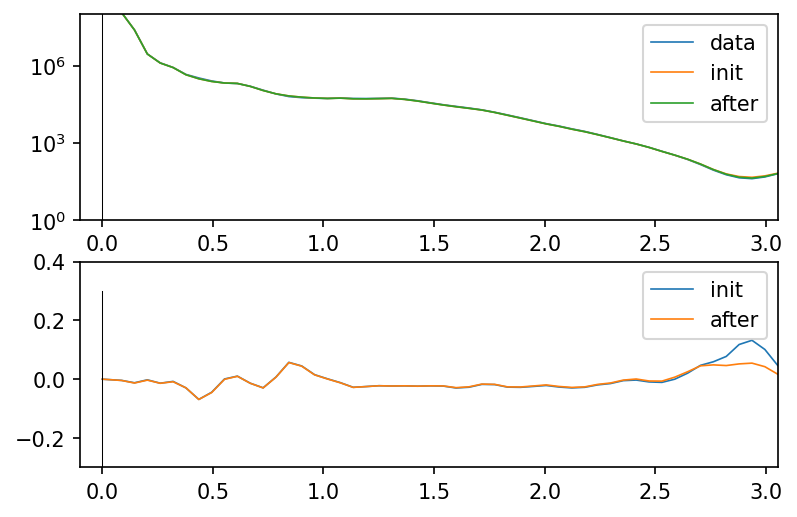

In [155]:
fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata, Idata, lw=0.8, label='data')
ax[0].plot(qdata, Imean_guess_init_[qba], lw=0.8, label='init')
ax[0].plot(qdata, Imean_guess_[qba], lw=0.8,label='after')
ax[0].set_xlim([-0.1, np.max(q)])
ax[0].set_ylim([1, 1e8])
ax[0].legend()
ax[0].set_yscale('log')
ax[0].plot([qdata[qROI[0]], qdata[qROI[0]]], [1, 1e8], 'k', lw=0.5)
ax[0].plot([qdata[qROI[-1]], qdata[qROI[-1]]], [1, 1e8], 'k', lw=0.5)
# ax[1].plot(qdata, (Imean_all_[qba] - Idata)/Idata, lw=0.8)
ax[1].plot(qdata, (Imean_guess_init_[qba] - Idata)/Idata, lw=0.8,label='init')
ax[1].plot(qdata, (Imean_guess_[qba] - Idata)/Idata, lw=0.8,label='after')
ax[1].plot([qdata[qROI[0]], qdata[qROI[0]]], [-0.3, 0.3], 'k', lw=0.5)
ax[1].plot([qdata[qROI[-1]], qdata[qROI[-1]]], [-0.3, 0.3], 'k', lw=0.5)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.4])
ax[1].legend()

In [156]:
rho_guess_out = rho_guess / dV
saxstats.write_mrc(rho_guess_out, side, f'rho_guess_grad.mrc')

6665.0830124405065
-3.0: 7015236910954701824.000
-2.9: 6125754892853825536.000
-2.8: 5323665814842853376.000
-2.7: 4603048702184649216.000
-2.6: 3958190298273527296.000


KeyboardInterrupt: 

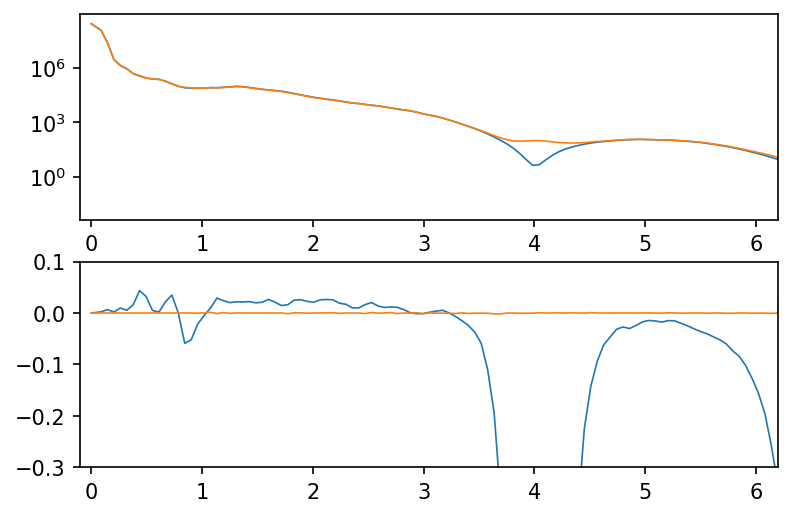

In [193]:
# Get I_calc
# rho_guess = rho_ligand.copy()
# rho_guess += np.random.random(rho_guess.shape) * 0.3

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne * 1

rho_guess_out = rho_guess / dV
# saxstats.write_mrc(rho_guess_out, side, 'rho_guess_3x.mrc')

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

chi = saxstats.mysum(((Imean_guess_[qba]-Idata[qba])/sigqdata[qba])**2, DENSS_GPU=DENSS_GPU)/Idata[qba].size
print(chi)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])

for i in np.linspace(-3, 3, num=61):

    rho_guess_mod = rho_guess.copy().flatten()
    rho_guess_mod[R_idx] += G_d * i
    rho_guess_mod = rho_guess_mod.reshape(rho_guess.shape)

    rho_guess_mod_out = rho_guess_mod / dV
    # saxstats.write_mrc(rho_guess_mod_out, side, 'rho_guess_3x_G.mrc')

    rho_guess_mod_ = np.fft.fftn(rho_guess_mod)
    I3D_guess_mod_ = np.abs(rho_apo_ + rho_guess_mod_)**2
    Imean_guess_mod_ = saxstats.mybinmean(I3D_guess_mod_, qbin_labels, DENSS_GPU)
    # ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
    # ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_mod_[qba])/Idata, lw=0.8)

    chi = saxstats.mysum(((Imean_guess_mod_[qba]-Idata[qba])/sigqdata[qba])**2, DENSS_GPU=DENSS_GPU)/Idata[qba].size
    print(f'{i:.1f}: {chi:.3f}')

In [9]:
rho_prime = np.fft.ifftn(rho_apo_ + rho_ligand_)

In [14]:
saxstats.write_mrc((rho_prime - rho_apo).real, side, 'test_back.mrc')

In [422]:
# Let's select an atom and grow it!
lig_S_cen = np.array([8.583,  -1.145,  -4.940])
lig_S_cen = lig_S_cen + np.array([-0.20769767,  0.11081395, -0.16790698])
print(lig_S_cen)

[ 8.16760466 -0.9233721  -5.27581396]


In [29]:
def dist2_from_cen(center, meshx, meshy, meshz):
    return (meshx - center[0])**2 + (meshy - center[1])**2 + (meshz - center[2])**2

In [220]:
def res_func(x, Idata, Iprior, Icross, Iguess, sigqdata):
    return np.sum(((Idata - Iprior - Icross * 2 * x - Iguess * x * x) / sigqdata)**2)

In [31]:
def res_func_log(x, Idata, Iprior, Icross, Iguess, sigqdata):
    return np.max(np.sum(((np.log10(Idata) - np.log10(Iprior + Icross * 2 * np.abs(x) + Iguess * x * x)) / sigqdata)**2), 0)

In [33]:
from scipy.optimize import minimize

In [783]:
minx = np.min(x[lig_mask])
maxx = np.max(x[lig_mask])
miny = np.min(y[lig_mask])
maxy = np.max(y[lig_mask])
minz = np.min(z[lig_mask])
maxz = np.max(z[lig_mask])
print(minx, maxx, miny, maxy, minz, maxz)

4.269767441860473 16.82790697674419 -13.311627906976739 3.7674418604651194 -22.35348837209302 1.2558139534883779


In [18]:
mask_xyz = np.array([x.flatten(), y.flatten(), z.flatten()]).T[lig_mask.flatten()]


array([  8.28837209,  -7.78604651, -15.82325581])

1.59766875084103 [ 10.8        -11.30232558 -16.82790698]
2.5326113550469773
2.533: 0.433 -> 0.349 -> 0.000


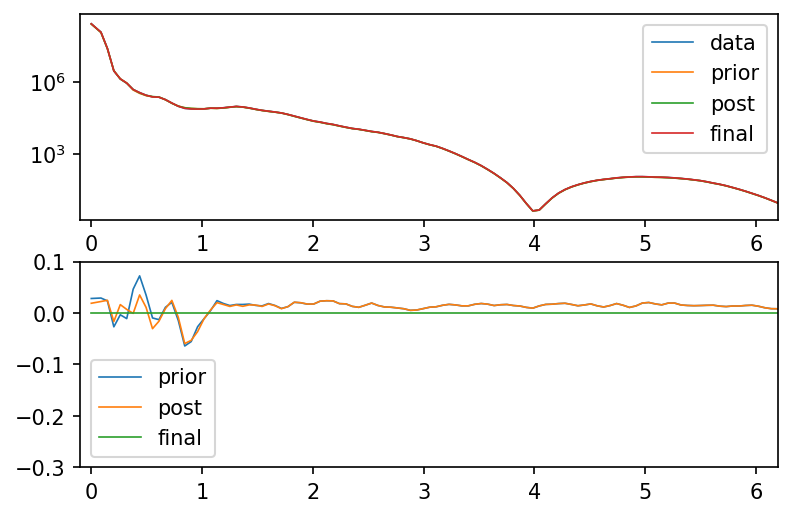

In [58]:
# Sauter method - use dots to paint electron density

rho_lig_S = np.zeros_like(rho_apo)
while rho_lig_S[lig_mask].sum() < 10:
    sigma = np.random.random() * 1.8 + 0.2
    rchoice = np.random.choice(len(mask_xyz))
    lig_S_cen = mask_xyz[rchoice]
#     lig_S_cen = np.array([minx + (maxx-minx)*np.random.random(),
#                           miny + (maxy-miny)*np.random.random(),
#                           minz + (maxz-minz)*np.random.random()])
#     lig_S_cen = np.array([8.583,  -1.145,  -4.940])
#     lig_S_cen = lig_S_cen + np.array([-0.20769767,  0.11081395, -0.16790698])

    rho_lig_S = 30 / 7.889 / np.sqrt(2 * np.pi)**3 / sigma**3 * np.exp(- dist2_from_cen(lig_S_cen, x, y, z) / 2 / sigma**2)
    if rho_lig_S[lig_mask].sum() < 10:
        print('X', end=' ')
    else:
        print(sigma, lig_S_cen)

        

        
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
# rho_guess += np.random.random(rho_guess.shape) * 0.3
rho_guess += rho_lig_S

# rho_guess[~lig_mask] = 0
# rho_guess /= np.sum(rho_guess)
# rho_guess *= lig_ne

rho_ligand_guess = np.zeros_like(rho_guess)
rho_ligand_guess += np.random.random(rho_guess.shape) * 0.9 + rho_ligand * 0.1
rho_ligand_guess[~lig_mask] = 0
rho_ligand_guess /= np.sum(rho_ligand_guess)
rho_ligand_guess *= lig_ne * 0

rho_prior = rho_apo + rho_ligand_guess
rho_prior_ = np.fft.fftn(rho_prior)
I3D_prior_ = np.abs(rho_prior_)**2
Imean_prior_ = saxstats.mybinmean(I3D_prior_, qbin_labels, DENSS_GPU)

chi_prior = saxstats.mysum(((Imean_prior_[qba]-Idata)/sigqdata)**2, DENSS_GPU=DENSS_GPU)/Idata.size

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

I3D_cross_ = (rho_prior_.conjugate() * rho_guess_).real
Imean_cross_ = saxstats.mybinmean(I3D_cross_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata, Idata, lw=0.8, label='data')
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata, Imean_prior_[qba], lw=0.8, label='prior')
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
# ax[0].set_ylim([1, 10])
ax[1].plot(qdata, (Idata - Imean_prior_[qba])/Idata, lw=0.8, label='prior')
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])

# (-b + sqrt(b^2 - 4ac)) / 2a
# factors = (- 2 * Imean_cross_[qba] + np.sqrt((2 * Imean_cross_[qba])**2 - \
#             4 * Imean_guess_[qba] * (Imean_prior_[qba] - Idata[qba]))) / 2 / Imean_guess_[qba] * Idata[qba] / sigqdata[qba]
# print(factors)
# factors[np.isnan(factors)] = 0
# factors[factors < 0] = 0
# factor = np.sqrt(np.sum(factors) / np.sum(Idata / sigqdata))
factor = minimize(res_func, 0, (Idata, Imean_prior_[qba], Imean_cross_[qba], Imean_guess_[qba], sigqdata)).x[0]
# factor = np.max([minimize(res_func, 0, (Idata, Imean_prior_[qba], Imean_cross_[qba], Imean_guess_[qba], sigqdata)).x[0], 0])
# factor = np.sqrt(np.sum(factors))
print(factor)
rho_guess_mod_ = rho_guess_ * factor


# Multiply that patch with this scaling factor
rho_guess_all_ = (rho_guess_mod_ + rho_prior_)
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
chi_int = saxstats.mysum(((Imean_guess_all_[qba]-Idata)/sigqdata)**2, DENSS_GPU=DENSS_GPU)/Idata.size

ax[0].plot(qdata, Imean_guess_all_[qba], lw=0.8, label='post')
ax[1].plot(qdata, (Idata - Imean_guess_all_[qba])/Idata, lw=0.8, label='post')

rho_guess_all = np.fft.ifftn(rho_guess_all_).real
rho_guess_all -= rho_apo
rho_guess_all[rho_guess_all < 0] = 0
# saxstats.write_mrc(rho_guess_all/dV, side, 'rho_guess_all.mrc')

factors = np.ones_like(Imean_guess_all_)
factors[qba] = np.sqrt(Idata / Imean_guess_all_[qba])
rho_guess_all_ = rho_guess_all_ * factors[qbin_labels]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata, Imean_guess_all_[qba], lw=0.8, label='final')
ax[1].plot(qdata, (Idata - Imean_guess_all_[qba])/Idata, lw=0.8, label='final')
chi_now = saxstats.mysum(((Imean_guess_all_[qba]-Idata)/sigqdata)**2, DENSS_GPU=DENSS_GPU)/Idata.size
print(f'{factor:.3f}: {chi_prior:.3f} -> {chi_int:.3f} -> {chi_now:.3f}')
ax[0].legend()
ax[1].legend()



In [92]:
minx = np.min(x[lig_mask])
maxx = np.max(x[lig_mask])
miny = np.min(y[lig_mask])
maxy = np.max(y[lig_mask])
minz = np.min(z[lig_mask])
maxz = np.max(z[lig_mask])
print(minx, maxx, miny, maxy, minz, maxz)

1.514018691588781 18.672897196261673 -15.644859813084118 5.551401869158873 -24.728971962616825 3.532710280373827


In [102]:
# Sauter method - use dots to paint electron density - let's make this an actual algorithm
import time

# This is the volume we accumulate density into
rho_ligand_guess = np.zeros_like(rho_apo)
rho_ligand_guess += np.random.random(rho_guess.shape) * 0.3
rho_ligand_guess[~lig_mask] = 0
rho_ligand_guess /= np.sum(rho_ligand_guess)
rho_ligand_guess *= lig_ne

t0 = time.time()
num_steps = 20000

chi_trace = np.zeros(num_steps)

for i in range(num_steps):
    
    # Generate a rho_guess (gaussian density)
    rho_guess = np.zeros_like(rho_apo)
    rho_guess_p = np.zeros_like(rho_apo)
    rho_guess_n = np.zeros_like(rho_apo)
    while np.abs(rho_guess_p[lig_mask]).sum() < 0.3:
        sigma_p = np.random.random() * 0.5 + 0.1
#         rchoice = np.random.choice(len(mask_xyz))
#         lig_cen = mask_xyz[rchoice]
        lig_cen = np.array([minx + (maxx-minx)*np.random.random(),
                      miny + (maxy-miny)*np.random.random(),
                      minz + (maxz-minz)*np.random.random()])
        rho_guess_p = np.sqrt(2 * np.pi)**3 / sigma_p**3 * np.exp(- dist2_from_cen(lig_cen, x, y, z) / 2 / sigma_p**2)
        rho_guess_p = rho_guess_p * 1 / np.sum(rho_guess_p)

        
    while np.abs(rho_guess_n[lig_mask]).sum() < 0.3:
        sigma_n = sigma_p + np.random.random() * 0.3
        lig_cen = np.array([minx + (maxx-minx)*np.random.random(),
                      miny + (maxy-miny)*np.random.random(),
                      minz + (maxz-minz)*np.random.random()])
        rho_guess_n = np.sqrt(2 * np.pi)**3 / sigma_n**3 * np.exp(- dist2_from_cen(lig_cen, x, y, z) / 2 / sigma_n**2)
        rho_guess_n = rho_guess_n * 1 / np.sum(rho_guess_n)

    rho_guess = rho_guess_p - rho_guess_n
#         if np.abs(rho_guess[lig_mask]).sum() < 0.3:
#             print('X', end=' ')
#         else:
#             print(sigma_p, sigma_n, lig_cen)
    
    rho_prior = rho_apo + rho_ligand_guess
    rho_prior_ = np.fft.fftn(rho_prior)
    I3D_prior_ = np.abs(rho_prior_)**2
    Imean_prior_ = saxstats.mybinmean(I3D_prior_, qbin_labels, DENSS_GPU)

    chi_prior = saxstats.mysum(((Imean_prior_[qba]-Idata)/sigqdata)**2, DENSS_GPU=DENSS_GPU)/Idata.size

    rho_guess_ = np.fft.fftn(rho_guess)
    I3D_guess_ = np.abs(rho_guess_)**2
    Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

    I3D_cross_ = (rho_prior_.conjugate() * rho_guess_).real
    Imean_cross_ = saxstats.mybinmean(I3D_cross_, qbin_labels, DENSS_GPU)
    
    factor = minimize(res_func, 0, (Idata, Imean_prior_[qba], Imean_cross_[qba], Imean_guess_[qba], sigqdata)).x[0]
    if factor > 20:
        factor = 20 # Cap factor
    rho_guess_mod_ = rho_guess_ * factor
    
    
    
    rho_guess_mod = np.fft.ifftn(rho_guess_mod_).real
    rho_guess_mod[~lig_mask] = 0

    rho_guess_all_ = np.fft.fftn(rho_guess_mod + rho_prior)
    I3D_guess_all_ = np.abs(rho_guess_all_)**2
    Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
    chi_int = np.sum(((Imean_guess_all_[qba]-Idata)/sigqdata)**2)/Idata.size
    print(f'Step {i:3d}, Factor {factor:.2f}: {chi_prior:.3f} -> {chi_int:.3f}', end=' ')

    if chi_int > chi_prior:
        print('bad trial, skip')
        chi_trace[i] = chi_prior
        continue
    else:
        if i%50 == 0 and i > 0:
            print(f'Timing: {time.time() - t0:.2f} s', end=' ')
        rho_ligand_guess += rho_guess_mod
        rho_ligand_guess[rho_ligand_guess < 0] = 0
        rho_ligand_guess[~lig_mask] = 0
        chi_trace[i] = chi_int
        print()


    
saxstats.write_mrc(rho_ligand_guess/dV, side, 'rho_ligand_guess.mrc')





Step   0, Factor 0.00: 1.719 -> 1.719 
Step   1, Factor 0.00: 1.719 -> 1.719 
Step   2, Factor 0.00: 1.719 -> 1.719 
Step   3, Factor 0.07: 1.719 -> 1.718 
Step   4, Factor 0.00: 1.718 -> 1.718 
Step   5, Factor 0.00: 1.718 -> 1.718 
Step   6, Factor 0.00: 1.718 -> 1.718 
Step   7, Factor 0.00: 1.718 -> 1.718 
Step   8, Factor 0.00: 1.718 -> 1.718 
Step   9, Factor 0.03: 1.718 -> 1.718 
Step  10, Factor 0.00: 1.718 -> 1.718 
Step  11, Factor 0.00: 1.718 -> 1.718 
Step  12, Factor 0.04: 1.718 -> 1.717 
Step  13, Factor 0.00: 1.717 -> 1.717 
Step  14, Factor 0.13: 1.717 -> 1.709 
Step  15, Factor 0.00: 1.709 -> 1.709 
Step  16, Factor 0.05: 1.709 -> 1.708 
Step  17, Factor 0.07: 1.708 -> 1.705 
Step  18, Factor 0.04: 1.705 -> 1.704 
Step  19, Factor 0.00: 1.704 -> 1.704 
Step  20, Factor 0.17: 1.704 -> 1.701 
Step  21, Factor 0.00: 1.701 -> 1.701 
Step  22, Factor 0.14: 1.701 -> 1.694 
Step  23, Factor 0.15: 1.694 -> 1.695 bad trial, skip
Step  24, Factor 0.03: 1.694 -> 1.693 
Step  25, 

Step 204, Factor 0.00: 1.364 -> 1.364 
Step 205, Factor 0.09: 1.364 -> 1.359 
Step 206, Factor 0.00: 1.363 -> 1.363 
Step 207, Factor 0.62: 1.363 -> 1.359 
Step 208, Factor 0.00: 1.359 -> 1.359 
Step 209, Factor 0.00: 1.359 -> 1.359 
Step 210, Factor 0.00: 1.359 -> 1.359 
Step 211, Factor 0.00: 1.359 -> 1.359 
Step 212, Factor 0.00: 1.359 -> 1.359 
Step 213, Factor 0.00: 1.359 -> 1.359 
Step 214, Factor 0.06: 1.359 -> 1.359 
Step 215, Factor 0.01: 1.359 -> 1.360 bad trial, skip
Step 216, Factor 0.00: 1.359 -> 1.359 
Step 217, Factor 0.13: 1.359 -> 1.357 
Step 218, Factor 0.15: 1.357 -> 1.361 bad trial, skip
Step 219, Factor 0.06: 1.357 -> 1.357 bad trial, skip
Step 220, Factor 0.06: 1.357 -> 1.356 
Step 221, Factor 0.30: 1.356 -> 1.352 
Step 222, Factor 0.00: 1.353 -> 1.353 
Step 223, Factor 0.00: 1.353 -> 1.353 
Step 224, Factor 0.00: 1.353 -> 1.353 
Step 225, Factor 0.00: 1.353 -> 1.353 
Step 226, Factor 0.06: 1.353 -> 1.352 
Step 227, Factor 0.06: 1.352 -> 1.350 
Step 228, Factor 0.

Step 408, Factor 0.03: 1.195 -> 1.195 
Step 409, Factor 0.09: 1.195 -> 1.193 
Step 410, Factor 0.00: 1.193 -> 1.193 
Step 411, Factor 0.09: 1.193 -> 1.194 bad trial, skip
Step 412, Factor 0.00: 1.193 -> 1.193 
Step 413, Factor 0.07: 1.193 -> 1.191 
Step 414, Factor 0.00: 1.191 -> 1.191 
Step 415, Factor 0.00: 1.191 -> 1.191 
Step 416, Factor 0.06: 1.191 -> 1.189 
Step 417, Factor 0.18: 1.189 -> 1.191 bad trial, skip
Step 418, Factor 0.07: 1.189 -> 1.189 bad trial, skip
Step 419, Factor 0.00: 1.189 -> 1.189 
Step 420, Factor 0.10: 1.189 -> 1.188 
Step 421, Factor 0.00: 1.188 -> 1.188 
Step 422, Factor 0.00: 1.188 -> 1.188 
Step 423, Factor 0.00: 1.188 -> 1.188 
Step 424, Factor 0.09: 1.188 -> 1.184 
Step 425, Factor 0.23: 1.184 -> 1.176 
Step 426, Factor 0.08: 1.179 -> 1.176 
Step 427, Factor 0.00: 1.176 -> 1.176 
Step 428, Factor 0.12: 1.176 -> 1.171 
Step 429, Factor 0.00: 1.171 -> 1.171 
Step 430, Factor 0.00: 1.171 -> 1.171 
Step 431, Factor 0.00: 1.171 -> 1.171 
Step 432, Factor 0.

Step 613, Factor 0.00: 1.020 -> 1.020 
Step 614, Factor 0.00: 1.020 -> 1.020 
Step 615, Factor 0.00: 1.020 -> 1.020 
Step 616, Factor 0.00: 1.020 -> 1.020 
Step 617, Factor 0.00: 1.020 -> 1.020 
Step 618, Factor 0.26: 1.020 -> 1.016 
Step 619, Factor 0.00: 1.015 -> 1.015 
Step 620, Factor 0.01: 1.015 -> 1.015 
Step 621, Factor 0.04: 1.015 -> 1.015 bad trial, skip
Step 622, Factor 0.00: 1.015 -> 1.015 
Step 623, Factor 0.00: 1.015 -> 1.015 
Step 624, Factor 0.00: 1.015 -> 1.015 
Step 625, Factor 0.17: 1.015 -> 1.014 
Step 626, Factor 0.00: 1.014 -> 1.014 
Step 627, Factor 0.13: 1.014 -> 1.012 
Step 628, Factor 0.05: 1.012 -> 1.012 
Step 629, Factor 0.00: 1.012 -> 1.012 
Step 630, Factor 0.00: 1.012 -> 1.012 
Step 631, Factor 0.00: 1.012 -> 1.012 
Step 632, Factor 0.02: 1.012 -> 1.012 
Step 633, Factor 0.00: 1.012 -> 1.012 
Step 634, Factor 0.00: 1.012 -> 1.012 
Step 635, Factor 0.00: 1.012 -> 1.012 
Step 636, Factor 0.08: 1.012 -> 1.011 
Step 637, Factor 0.00: 1.011 -> 1.011 
Step 638, 

Step 815, Factor 0.00: 0.901 -> 0.901 
Step 816, Factor 0.00: 0.901 -> 0.901 
Step 817, Factor 0.00: 0.901 -> 0.901 
Step 818, Factor 0.09: 0.901 -> 0.900 
Step 819, Factor 0.00: 0.900 -> 0.900 
Step 820, Factor 0.00: 0.900 -> 0.900 
Step 821, Factor 0.02: 0.900 -> 0.900 
Step 822, Factor 0.03: 0.900 -> 0.900 
Step 823, Factor 0.05: 0.900 -> 0.900 
Step 824, Factor 0.11: 0.900 -> 0.898 
Step 825, Factor 0.09: 0.898 -> 0.896 
Step 826, Factor 0.40: 0.896 -> 0.893 
Step 827, Factor 0.00: 0.891 -> 0.891 
Step 828, Factor 0.11: 0.891 -> 0.891 
Step 829, Factor 0.05: 0.890 -> 0.890 
Step 830, Factor 0.05: 0.890 -> 0.890 
Step 831, Factor 0.00: 0.890 -> 0.890 
Step 832, Factor 0.05: 0.890 -> 0.889 
Step 833, Factor 0.00: 0.888 -> 0.888 
Step 834, Factor 0.00: 0.888 -> 0.888 
Step 835, Factor 0.00: 0.888 -> 0.888 
Step 836, Factor 0.00: 0.888 -> 0.888 
Step 837, Factor 0.00: 0.888 -> 0.888 
Step 838, Factor 0.11: 0.888 -> 0.886 
Step 839, Factor 0.00: 0.886 -> 0.886 
Step 840, Factor 0.00: 0.

Step 1021, Factor 0.00: 0.789 -> 0.789 
Step 1022, Factor 0.09: 0.789 -> 0.788 
Step 1023, Factor 0.00: 0.788 -> 0.788 
Step 1024, Factor 0.06: 0.788 -> 0.787 
Step 1025, Factor 0.02: 0.788 -> 0.788 
Step 1026, Factor 0.08: 0.788 -> 0.786 
Step 1027, Factor 0.00: 0.786 -> 0.786 
Step 1028, Factor 0.14: 0.786 -> 0.785 
Step 1029, Factor 0.00: 0.786 -> 0.786 
Step 1030, Factor 0.00: 0.786 -> 0.786 
Step 1031, Factor 0.00: 0.786 -> 0.786 
Step 1032, Factor 0.01: 0.786 -> 0.786 
Step 1033, Factor 0.00: 0.786 -> 0.786 
Step 1034, Factor 0.03: 0.786 -> 0.786 bad trial, skip
Step 1035, Factor 0.00: 0.786 -> 0.786 
Step 1036, Factor 0.00: 0.786 -> 0.786 
Step 1037, Factor 0.00: 0.786 -> 0.786 
Step 1038, Factor 0.00: 0.786 -> 0.786 
Step 1039, Factor 0.00: 0.786 -> 0.786 
Step 1040, Factor 0.03: 0.786 -> 0.785 
Step 1041, Factor 0.04: 0.785 -> 0.785 
Step 1042, Factor 0.00: 0.785 -> 0.785 
Step 1043, Factor 0.04: 0.785 -> 0.785 
Step 1044, Factor 0.08: 0.785 -> 0.784 
Step 1045, Factor 0.00: 0

Step 1222, Factor 0.00: 0.716 -> 0.716 
Step 1223, Factor 0.16: 0.716 -> 0.716 
Step 1224, Factor 0.00: 0.716 -> 0.716 
Step 1225, Factor 0.00: 0.716 -> 0.716 
Step 1226, Factor 0.00: 0.716 -> 0.716 
Step 1227, Factor 0.00: 0.716 -> 0.716 
Step 1228, Factor 0.10: 0.716 -> 0.715 
Step 1229, Factor 0.00: 0.715 -> 0.715 
Step 1230, Factor 0.04: 0.715 -> 0.715 
Step 1231, Factor 0.00: 0.714 -> 0.714 
Step 1232, Factor 0.02: 0.714 -> 0.714 
Step 1233, Factor 0.00: 0.714 -> 0.714 
Step 1234, Factor 0.00: 0.714 -> 0.714 
Step 1235, Factor 0.00: 0.714 -> 0.714 
Step 1236, Factor 0.00: 0.714 -> 0.714 
Step 1237, Factor 0.00: 0.714 -> 0.714 
Step 1238, Factor 0.06: 0.714 -> 0.714 
Step 1239, Factor 0.00: 0.714 -> 0.714 
Step 1240, Factor 0.05: 0.714 -> 0.713 
Step 1241, Factor 0.00: 0.714 -> 0.714 
Step 1242, Factor 0.00: 0.714 -> 0.714 
Step 1243, Factor 0.03: 0.714 -> 0.714 
Step 1244, Factor 0.00: 0.714 -> 0.714 
Step 1245, Factor 0.00: 0.714 -> 0.714 
Step 1246, Factor 0.13: 0.714 -> 0.714 b

Step 1423, Factor 0.00: 0.660 -> 0.660 
Step 1424, Factor 0.00: 0.660 -> 0.660 
Step 1425, Factor 0.00: 0.660 -> 0.660 
Step 1426, Factor 0.09: 0.660 -> 0.659 
Step 1427, Factor 0.00: 0.659 -> 0.659 
Step 1428, Factor 0.09: 0.659 -> 0.657 
Step 1429, Factor 0.00: 0.660 -> 0.660 
Step 1430, Factor 0.00: 0.660 -> 0.660 
Step 1431, Factor 0.15: 0.660 -> 0.660 bad trial, skip
Step 1432, Factor 0.00: 0.660 -> 0.660 
Step 1433, Factor 0.00: 0.660 -> 0.660 
Step 1434, Factor 0.02: 0.660 -> 0.660 
Step 1435, Factor 0.00: 0.660 -> 0.660 
Step 1436, Factor 0.35: 0.660 -> 0.660 
Step 1437, Factor 0.00: 0.660 -> 0.660 
Step 1438, Factor 0.00: 0.660 -> 0.660 
Step 1439, Factor 0.00: 0.660 -> 0.660 
Step 1440, Factor 0.00: 0.660 -> 0.660 
Step 1441, Factor 0.31: 0.660 -> 0.658 
Step 1442, Factor 0.04: 0.658 -> 0.658 
Step 1443, Factor 0.00: 0.658 -> 0.658 
Step 1444, Factor 0.00: 0.658 -> 0.658 
Step 1445, Factor 0.00: 0.658 -> 0.658 
Step 1446, Factor 0.07: 0.658 -> 0.658 
Step 1447, Factor 0.00: 0

Step 1623, Factor 0.00: 0.606 -> 0.606 
Step 1624, Factor 0.00: 0.606 -> 0.606 
Step 1625, Factor 0.19: 0.606 -> 0.603 
Step 1626, Factor 0.02: 0.603 -> 0.603 
Step 1627, Factor 0.02: 0.603 -> 0.603 
Step 1628, Factor 0.24: 0.603 -> 0.600 
Step 1629, Factor 0.35: 0.600 -> 0.596 
Step 1630, Factor 0.12: 0.596 -> 0.596 
Step 1631, Factor 0.23: 0.596 -> 0.595 
Step 1632, Factor 0.00: 0.595 -> 0.595 
Step 1633, Factor 0.00: 0.595 -> 0.595 
Step 1634, Factor 0.00: 0.595 -> 0.595 
Step 1635, Factor 0.01: 0.595 -> 0.595 bad trial, skip
Step 1636, Factor 0.00: 0.595 -> 0.595 
Step 1637, Factor 0.00: 0.595 -> 0.595 
Step 1638, Factor 0.03: 0.595 -> 0.595 
Step 1639, Factor 0.04: 0.595 -> 0.595 
Step 1640, Factor 0.01: 0.595 -> 0.595 bad trial, skip
Step 1641, Factor 0.00: 0.595 -> 0.595 
Step 1642, Factor 0.02: 0.595 -> 0.595 
Step 1643, Factor 0.11: 0.595 -> 0.594 
Step 1644, Factor 0.06: 0.594 -> 0.593 
Step 1645, Factor 0.05: 0.593 -> 0.593 
Step 1646, Factor 0.10: 0.593 -> 0.592 
Step 1647,

Step 1823, Factor 0.02: 0.556 -> 0.556 
Step 1824, Factor 0.00: 0.556 -> 0.556 
Step 1825, Factor 0.00: 0.556 -> 0.556 
Step 1826, Factor 0.17: 0.556 -> 0.555 
Step 1827, Factor 0.00: 0.555 -> 0.555 
Step 1828, Factor 0.00: 0.555 -> 0.555 
Step 1829, Factor 0.04: 0.555 -> 0.555 bad trial, skip
Step 1830, Factor 0.00: 0.555 -> 0.555 
Step 1831, Factor 0.00: 0.555 -> 0.555 
Step 1832, Factor 0.02: 0.555 -> 0.555 
Step 1833, Factor 0.00: 0.555 -> 0.555 
Step 1834, Factor 0.00: 0.555 -> 0.555 
Step 1835, Factor 0.13: 0.555 -> 0.555 
Step 1836, Factor 0.09: 0.555 -> 0.554 
Step 1837, Factor 0.01: 0.554 -> 0.554 
Step 1838, Factor 0.00: 0.554 -> 0.554 
Step 1839, Factor 0.05: 0.554 -> 0.554 
Step 1840, Factor 0.00: 0.554 -> 0.554 
Step 1841, Factor 0.00: 0.554 -> 0.554 
Step 1842, Factor 0.02: 0.554 -> 0.554 
Step 1843, Factor 0.06: 0.554 -> 0.554 
Step 1844, Factor 0.00: 0.554 -> 0.554 
Step 1845, Factor 0.08: 0.554 -> 0.553 
Step 1846, Factor 0.06: 0.553 -> 0.553 
Step 1847, Factor 0.23: 0

Step 2024, Factor 0.20: 0.526 -> 0.526 
Step 2025, Factor 0.00: 0.525 -> 0.525 
Step 2026, Factor 0.00: 0.525 -> 0.525 
Step 2027, Factor 0.04: 0.525 -> 0.525 
Step 2028, Factor 0.00: 0.525 -> 0.525 
Step 2029, Factor 0.00: 0.525 -> 0.525 
Step 2030, Factor 0.00: 0.525 -> 0.525 
Step 2031, Factor 0.02: 0.525 -> 0.525 
Step 2032, Factor 0.00: 0.525 -> 0.525 
Step 2033, Factor 0.00: 0.525 -> 0.525 
Step 2034, Factor 0.00: 0.525 -> 0.525 
Step 2035, Factor 0.15: 0.525 -> 0.524 
Step 2036, Factor 0.00: 0.524 -> 0.524 
Step 2037, Factor 0.10: 0.524 -> 0.524 
Step 2038, Factor 0.10: 0.524 -> 0.524 bad trial, skip
Step 2039, Factor 0.04: 0.524 -> 0.524 
Step 2040, Factor 0.00: 0.524 -> 0.524 
Step 2041, Factor 0.00: 0.524 -> 0.524 
Step 2042, Factor 0.14: 0.524 -> 0.523 
Step 2043, Factor 0.00: 0.522 -> 0.522 
Step 2044, Factor 0.00: 0.522 -> 0.522 
Step 2045, Factor 0.05: 0.522 -> 0.523 bad trial, skip
Step 2046, Factor 0.00: 0.522 -> 0.522 
Step 2047, Factor 0.03: 0.522 -> 0.522 
Step 2048,

Step 2223, Factor 0.06: 0.497 -> 0.497 
Step 2224, Factor 0.00: 0.497 -> 0.497 
Step 2225, Factor 0.00: 0.497 -> 0.497 
Step 2226, Factor 0.00: 0.497 -> 0.497 
Step 2227, Factor 0.00: 0.497 -> 0.497 
Step 2228, Factor 0.08: 0.497 -> 0.496 
Step 2229, Factor 0.05: 0.496 -> 0.496 
Step 2230, Factor 0.00: 0.496 -> 0.496 
Step 2231, Factor 0.00: 0.496 -> 0.496 
Step 2232, Factor 0.05: 0.496 -> 0.496 bad trial, skip
Step 2233, Factor 0.00: 0.496 -> 0.496 
Step 2234, Factor 0.00: 0.496 -> 0.496 
Step 2235, Factor 0.11: 0.496 -> 0.496 
Step 2236, Factor 0.03: 0.496 -> 0.496 
Step 2237, Factor 0.19: 0.496 -> 0.496 bad trial, skip
Step 2238, Factor 0.00: 0.496 -> 0.496 
Step 2239, Factor 0.00: 0.496 -> 0.496 
Step 2240, Factor 0.15: 0.496 -> 0.496 
Step 2241, Factor 0.01: 0.496 -> 0.496 
Step 2242, Factor 0.00: 0.496 -> 0.496 
Step 2243, Factor 0.00: 0.496 -> 0.496 
Step 2244, Factor 0.41: 0.496 -> 0.495 
Step 2245, Factor 0.00: 0.495 -> 0.495 
Step 2246, Factor 0.00: 0.495 -> 0.495 
Step 2247,

Step 2421, Factor 0.00: 0.471 -> 0.471 
Step 2422, Factor 0.07: 0.471 -> 0.471 
Step 2423, Factor 0.00: 0.471 -> 0.471 
Step 2424, Factor 0.08: 0.471 -> 0.470 
Step 2425, Factor 0.00: 0.470 -> 0.470 
Step 2426, Factor 0.00: 0.470 -> 0.470 
Step 2427, Factor 0.00: 0.470 -> 0.470 
Step 2428, Factor 0.00: 0.470 -> 0.470 
Step 2429, Factor 0.07: 0.470 -> 0.470 
Step 2430, Factor 0.15: 0.470 -> 0.470 
Step 2431, Factor 0.00: 0.470 -> 0.470 
Step 2432, Factor 0.00: 0.470 -> 0.470 
Step 2433, Factor 0.00: 0.470 -> 0.470 
Step 2434, Factor 0.02: 0.470 -> 0.470 
Step 2435, Factor 0.08: 0.470 -> 0.470 
Step 2436, Factor 0.00: 0.470 -> 0.470 
Step 2437, Factor 0.07: 0.470 -> 0.469 
Step 2438, Factor 0.08: 0.469 -> 0.469 
Step 2439, Factor 0.08: 0.469 -> 0.469 
Step 2440, Factor 0.00: 0.469 -> 0.469 
Step 2441, Factor 0.00: 0.469 -> 0.469 
Step 2442, Factor 0.04: 0.469 -> 0.469 
Step 2443, Factor 0.11: 0.469 -> 0.469 
Step 2444, Factor 0.14: 0.469 -> 0.469 bad trial, skip
Step 2445, Factor 0.00: 0

Step 2621, Factor 0.00: 0.447 -> 0.447 
Step 2622, Factor 0.06: 0.447 -> 0.447 
Step 2623, Factor 0.01: 0.447 -> 0.447 
Step 2624, Factor 0.00: 0.447 -> 0.447 
Step 2625, Factor 0.12: 0.447 -> 0.446 
Step 2626, Factor 0.00: 0.446 -> 0.446 
Step 2627, Factor 0.00: 0.446 -> 0.446 
Step 2628, Factor 0.00: 0.446 -> 0.446 
Step 2629, Factor 0.21: 0.446 -> 0.446 
Step 2630, Factor 0.00: 0.446 -> 0.446 
Step 2631, Factor 0.00: 0.446 -> 0.446 
Step 2632, Factor 0.01: 0.446 -> 0.446 
Step 2633, Factor 0.03: 0.446 -> 0.446 
Step 2634, Factor 0.00: 0.446 -> 0.446 
Step 2635, Factor 0.31: 0.446 -> 0.446 
Step 2636, Factor 0.00: 0.446 -> 0.446 
Step 2637, Factor 0.00: 0.446 -> 0.446 
Step 2638, Factor 0.04: 0.446 -> 0.446 bad trial, skip
Step 2639, Factor 0.00: 0.446 -> 0.446 
Step 2640, Factor 0.00: 0.446 -> 0.446 
Step 2641, Factor 0.00: 0.446 -> 0.446 
Step 2642, Factor 0.00: 0.446 -> 0.446 
Step 2643, Factor 0.28: 0.446 -> 0.445 
Step 2644, Factor 0.00: 0.445 -> 0.445 
Step 2645, Factor 0.00: 0

Step 2820, Factor 0.00: 0.430 -> 0.430 
Step 2821, Factor 0.09: 0.430 -> 0.430 bad trial, skip
Step 2822, Factor 0.08: 0.430 -> 0.430 
Step 2823, Factor 0.20: 0.429 -> 0.428 
Step 2824, Factor 0.08: 0.429 -> 0.428 
Step 2825, Factor 0.18: 0.428 -> 0.428 
Step 2826, Factor 0.68: 0.428 -> 0.426 
Step 2827, Factor 0.00: 0.427 -> 0.427 
Step 2828, Factor 0.00: 0.427 -> 0.427 
Step 2829, Factor 0.00: 0.427 -> 0.427 
Step 2830, Factor 0.04: 0.427 -> 0.427 
Step 2831, Factor 0.00: 0.427 -> 0.427 
Step 2832, Factor 0.05: 0.427 -> 0.427 
Step 2833, Factor 0.00: 0.427 -> 0.427 
Step 2834, Factor 0.00: 0.427 -> 0.427 
Step 2835, Factor 0.18: 0.427 -> 0.427 bad trial, skip
Step 2836, Factor 0.00: 0.427 -> 0.427 
Step 2837, Factor 0.00: 0.427 -> 0.427 
Step 2838, Factor 0.00: 0.427 -> 0.427 
Step 2839, Factor 0.02: 0.427 -> 0.427 
Step 2840, Factor 0.00: 0.427 -> 0.427 
Step 2841, Factor 0.03: 0.427 -> 0.427 
Step 2842, Factor 0.00: 0.427 -> 0.427 
Step 2843, Factor 0.05: 0.427 -> 0.427 bad trial, 

Step 3019, Factor 0.00: 0.411 -> 0.411 
Step 3020, Factor 0.04: 0.411 -> 0.411 
Step 3021, Factor 0.00: 0.411 -> 0.411 
Step 3022, Factor 0.03: 0.411 -> 0.411 
Step 3023, Factor 0.11: 0.411 -> 0.411 
Step 3024, Factor 0.00: 0.411 -> 0.411 
Step 3025, Factor 0.08: 0.411 -> 0.410 
Step 3026, Factor 0.01: 0.410 -> 0.410 
Step 3027, Factor 0.00: 0.410 -> 0.410 
Step 3028, Factor 0.01: 0.410 -> 0.410 
Step 3029, Factor 0.01: 0.410 -> 0.410 
Step 3030, Factor 0.08: 0.410 -> 0.410 
Step 3031, Factor 0.00: 0.410 -> 0.410 
Step 3032, Factor 0.29: 0.410 -> 0.409 
Step 3033, Factor 0.00: 0.409 -> 0.409 
Step 3034, Factor 0.00: 0.409 -> 0.409 
Step 3035, Factor 0.00: 0.409 -> 0.409 
Step 3036, Factor 0.07: 0.409 -> 0.409 
Step 3037, Factor 0.00: 0.409 -> 0.409 
Step 3038, Factor 0.00: 0.409 -> 0.409 
Step 3039, Factor 0.28: 0.409 -> 0.408 
Step 3040, Factor 0.06: 0.409 -> 0.408 
Step 3041, Factor 0.00: 0.408 -> 0.408 
Step 3042, Factor 0.00: 0.408 -> 0.408 
Step 3043, Factor 0.00: 0.408 -> 0.408 


Step 3218, Factor 0.11: 0.393 -> 0.393 
Step 3219, Factor 0.10: 0.393 -> 0.392 
Step 3220, Factor 0.00: 0.393 -> 0.393 
Step 3221, Factor 0.00: 0.393 -> 0.393 
Step 3222, Factor 0.15: 0.393 -> 0.392 
Step 3223, Factor 0.00: 0.392 -> 0.392 
Step 3224, Factor 0.11: 0.392 -> 0.392 
Step 3225, Factor 0.00: 0.392 -> 0.392 
Step 3226, Factor 0.00: 0.392 -> 0.392 
Step 3227, Factor 0.00: 0.392 -> 0.392 
Step 3228, Factor 0.05: 0.392 -> 0.392 
Step 3229, Factor 0.48: 0.392 -> 0.392 
Step 3230, Factor 0.00: 0.392 -> 0.392 
Step 3231, Factor 0.00: 0.392 -> 0.392 
Step 3232, Factor 0.00: 0.392 -> 0.392 
Step 3233, Factor 0.00: 0.392 -> 0.392 
Step 3234, Factor 0.05: 0.392 -> 0.392 
Step 3235, Factor 0.04: 0.392 -> 0.392 bad trial, skip
Step 3236, Factor 0.00: 0.392 -> 0.392 
Step 3237, Factor 0.00: 0.392 -> 0.392 
Step 3238, Factor 0.00: 0.392 -> 0.392 
Step 3239, Factor 0.20: 0.392 -> 0.392 
Step 3240, Factor 0.00: 0.392 -> 0.392 
Step 3241, Factor 0.00: 0.392 -> 0.392 
Step 3242, Factor 0.00: 0

Step 3417, Factor 0.04: 0.382 -> 0.382 
Step 3418, Factor 0.00: 0.382 -> 0.382 
Step 3419, Factor 0.19: 0.382 -> 0.382 
Step 3420, Factor 0.00: 0.382 -> 0.382 
Step 3421, Factor 0.04: 0.382 -> 0.382 
Step 3422, Factor 0.17: 0.382 -> 0.382 
Step 3423, Factor 0.00: 0.382 -> 0.382 
Step 3424, Factor 0.00: 0.382 -> 0.382 
Step 3425, Factor 0.57: 0.382 -> 0.382 bad trial, skip
Step 3426, Factor 0.03: 0.382 -> 0.382 bad trial, skip
Step 3427, Factor 0.00: 0.382 -> 0.382 
Step 3428, Factor 0.00: 0.382 -> 0.382 
Step 3429, Factor 0.00: 0.382 -> 0.382 
Step 3430, Factor 0.00: 0.382 -> 0.382 
Step 3431, Factor 0.00: 0.382 -> 0.382 
Step 3432, Factor 0.02: 0.382 -> 0.382 
Step 3433, Factor 0.00: 0.382 -> 0.382 
Step 3434, Factor 0.00: 0.382 -> 0.382 
Step 3435, Factor 0.02: 0.382 -> 0.382 
Step 3436, Factor 0.06: 0.382 -> 0.382 bad trial, skip
Step 3437, Factor 0.01: 0.382 -> 0.382 
Step 3438, Factor 0.01: 0.382 -> 0.382 
Step 3439, Factor 0.00: 0.382 -> 0.382 
Step 3440, Factor 0.05: 0.382 -> 0.

Step 3614, Factor 0.05: 0.365 -> 0.365 
Step 3615, Factor 0.09: 0.365 -> 0.365 
Step 3616, Factor 0.00: 0.365 -> 0.365 
Step 3617, Factor 0.02: 0.365 -> 0.365 
Step 3618, Factor 0.00: 0.365 -> 0.365 
Step 3619, Factor 0.00: 0.365 -> 0.365 
Step 3620, Factor 0.07: 0.365 -> 0.365 
Step 3621, Factor 0.09: 0.365 -> 0.365 
Step 3622, Factor 0.03: 0.365 -> 0.365 
Step 3623, Factor 0.00: 0.365 -> 0.365 
Step 3624, Factor 0.02: 0.365 -> 0.365 
Step 3625, Factor 0.20: 0.365 -> 0.364 
Step 3626, Factor 0.00: 0.364 -> 0.364 
Step 3627, Factor 0.00: 0.364 -> 0.364 
Step 3628, Factor 0.31: 0.364 -> 0.364 
Step 3629, Factor 0.00: 0.364 -> 0.364 
Step 3630, Factor 1.06: 0.364 -> 0.362 
Step 3631, Factor 0.40: 0.362 -> 0.362 
Step 3632, Factor 0.00: 0.362 -> 0.362 
Step 3633, Factor 0.00: 0.362 -> 0.362 
Step 3634, Factor 0.04: 0.362 -> 0.362 
Step 3635, Factor 0.04: 0.362 -> 0.362 
Step 3636, Factor 0.00: 0.362 -> 0.362 
Step 3637, Factor 0.12: 0.362 -> 0.362 
Step 3638, Factor 0.04: 0.362 -> 0.362 


Step 3814, Factor 0.00: 0.346 -> 0.346 
Step 3815, Factor 0.00: 0.346 -> 0.346 
Step 3816, Factor 0.05: 0.346 -> 0.346 bad trial, skip
Step 3817, Factor 0.14: 0.346 -> 0.346 
Step 3818, Factor 0.00: 0.345 -> 0.345 
Step 3819, Factor 0.12: 0.345 -> 0.345 
Step 3820, Factor 0.08: 0.345 -> 0.344 
Step 3821, Factor 0.02: 0.345 -> 0.345 bad trial, skip
Step 3822, Factor 0.00: 0.345 -> 0.345 
Step 3823, Factor 0.19: 0.345 -> 0.344 
Step 3824, Factor 0.04: 0.345 -> 0.345 
Step 3825, Factor 0.15: 0.345 -> 0.344 
Step 3826, Factor 0.00: 0.344 -> 0.344 
Step 3827, Factor 0.00: 0.344 -> 0.344 
Step 3828, Factor 0.00: 0.344 -> 0.344 
Step 3829, Factor 0.00: 0.344 -> 0.344 
Step 3830, Factor 0.00: 0.344 -> 0.344 
Step 3831, Factor 0.00: 0.344 -> 0.344 
Step 3832, Factor 0.00: 0.344 -> 0.344 
Step 3833, Factor 0.00: 0.344 -> 0.344 
Step 3834, Factor 0.07: 0.344 -> 0.344 bad trial, skip
Step 3835, Factor 0.00: 0.344 -> 0.344 
Step 3836, Factor 0.00: 0.344 -> 0.344 
Step 3837, Factor 0.02: 0.344 -> 0.

Step 4013, Factor 0.00: 0.332 -> 0.332 
Step 4014, Factor 0.00: 0.332 -> 0.332 
Step 4015, Factor 0.05: 0.332 -> 0.332 
Step 4016, Factor 0.10: 0.332 -> 0.332 
Step 4017, Factor 0.00: 0.331 -> 0.331 
Step 4018, Factor 0.00: 0.331 -> 0.331 
Step 4019, Factor 0.00: 0.331 -> 0.331 
Step 4020, Factor 0.00: 0.331 -> 0.331 
Step 4021, Factor 0.00: 0.331 -> 0.331 
Step 4022, Factor 0.04: 0.331 -> 0.331 
Step 4023, Factor 0.00: 0.331 -> 0.331 
Step 4024, Factor 0.03: 0.331 -> 0.331 
Step 4025, Factor 0.05: 0.331 -> 0.331 
Step 4026, Factor 0.00: 0.331 -> 0.331 
Step 4027, Factor 0.45: 0.331 -> 0.331 
Step 4028, Factor 0.00: 0.331 -> 0.331 
Step 4029, Factor 0.00: 0.331 -> 0.331 
Step 4030, Factor 0.00: 0.331 -> 0.331 
Step 4031, Factor 0.09: 0.331 -> 0.331 bad trial, skip
Step 4032, Factor 0.06: 0.331 -> 0.331 bad trial, skip
Step 4033, Factor 0.00: 0.331 -> 0.331 
Step 4034, Factor 0.00: 0.331 -> 0.331 
Step 4035, Factor 0.09: 0.331 -> 0.331 bad trial, skip
Step 4036, Factor 0.00: 0.331 -> 0.

Step 4212, Factor 0.11: 0.319 -> 0.319 
Step 4213, Factor 0.00: 0.319 -> 0.319 
Step 4214, Factor 0.45: 0.319 -> 0.319 
Step 4215, Factor 0.03: 0.320 -> 0.320 
Step 4216, Factor 0.06: 0.320 -> 0.319 
Step 4217, Factor 0.00: 0.319 -> 0.319 
Step 4218, Factor 0.12: 0.319 -> 0.319 
Step 4219, Factor 0.31: 0.319 -> 0.319 
Step 4220, Factor 0.09: 0.319 -> 0.319 
Step 4221, Factor 0.09: 0.319 -> 0.319 
Step 4222, Factor 0.00: 0.319 -> 0.319 
Step 4223, Factor 0.00: 0.319 -> 0.319 
Step 4224, Factor 0.00: 0.319 -> 0.319 
Step 4225, Factor 0.65: 0.319 -> 0.319 bad trial, skip
Step 4226, Factor 0.00: 0.319 -> 0.319 
Step 4227, Factor 0.00: 0.319 -> 0.319 
Step 4228, Factor 0.03: 0.319 -> 0.319 bad trial, skip
Step 4229, Factor 0.04: 0.319 -> 0.318 
Step 4230, Factor 0.00: 0.318 -> 0.318 
Step 4231, Factor 0.05: 0.318 -> 0.318 
Step 4232, Factor 0.01: 0.318 -> 0.318 
Step 4233, Factor 0.00: 0.318 -> 0.318 
Step 4234, Factor 0.00: 0.318 -> 0.318 
Step 4235, Factor 0.00: 0.318 -> 0.318 
Step 4236,

Step 4411, Factor 0.00: 0.307 -> 0.307 
Step 4412, Factor 0.64: 0.307 -> 0.307 
Step 4413, Factor 0.00: 0.307 -> 0.307 
Step 4414, Factor 0.05: 0.307 -> 0.307 
Step 4415, Factor 0.00: 0.307 -> 0.307 
Step 4416, Factor 0.00: 0.307 -> 0.307 
Step 4417, Factor 0.03: 0.307 -> 0.307 
Step 4418, Factor 0.00: 0.307 -> 0.307 
Step 4419, Factor 0.14: 0.307 -> 0.307 
Step 4420, Factor 0.00: 0.307 -> 0.307 
Step 4421, Factor 0.05: 0.307 -> 0.307 
Step 4422, Factor 0.04: 0.307 -> 0.307 
Step 4423, Factor 0.00: 0.307 -> 0.307 
Step 4424, Factor 0.04: 0.307 -> 0.307 
Step 4425, Factor 0.03: 0.307 -> 0.307 
Step 4426, Factor 0.00: 0.307 -> 0.307 
Step 4427, Factor 0.00: 0.307 -> 0.307 
Step 4428, Factor 0.01: 0.307 -> 0.307 
Step 4429, Factor 0.00: 0.307 -> 0.307 
Step 4430, Factor 0.49: 0.307 -> 0.307 
Step 4431, Factor 0.00: 0.307 -> 0.307 
Step 4432, Factor 0.00: 0.307 -> 0.307 
Step 4433, Factor 0.00: 0.307 -> 0.307 bad trial, skip
Step 4434, Factor 0.04: 0.307 -> 0.307 bad trial, skip
Step 4435,

Step 4610, Factor 0.00: 0.295 -> 0.295 
Step 4611, Factor 0.07: 0.295 -> 0.295 
Step 4612, Factor 0.00: 0.295 -> 0.295 
Step 4613, Factor 0.08: 0.295 -> 0.295 
Step 4614, Factor 0.10: 0.295 -> 0.295 
Step 4615, Factor 0.00: 0.295 -> 0.295 
Step 4616, Factor 0.00: 0.295 -> 0.295 
Step 4617, Factor 0.11: 0.295 -> 0.295 bad trial, skip
Step 4618, Factor 0.00: 0.295 -> 0.295 
Step 4619, Factor 0.24: 0.295 -> 0.295 bad trial, skip
Step 4620, Factor 0.09: 0.295 -> 0.295 bad trial, skip
Step 4621, Factor 0.05: 0.295 -> 0.295 
Step 4622, Factor 0.00: 0.295 -> 0.295 
Step 4623, Factor 0.04: 0.295 -> 0.295 
Step 4624, Factor 0.00: 0.295 -> 0.295 
Step 4625, Factor 0.00: 0.295 -> 0.295 
Step 4626, Factor 0.00: 0.295 -> 0.295 
Step 4627, Factor 0.07: 0.295 -> 0.295 
Step 4628, Factor 0.49: 0.295 -> 0.294 
Step 4629, Factor 0.04: 0.293 -> 0.293 
Step 4630, Factor 0.02: 0.293 -> 0.293 
Step 4631, Factor 0.59: 0.293 -> 0.293 
Step 4632, Factor 0.00: 0.293 -> 0.293 
Step 4633, Factor 0.00: 0.293 -> 0.

Step 4810, Factor 0.02: 0.281 -> 0.281 
Step 4811, Factor 0.74: 0.281 -> 0.280 
Step 4812, Factor 0.00: 0.280 -> 0.280 
Step 4813, Factor 0.00: 0.280 -> 0.280 
Step 4814, Factor 0.00: 0.280 -> 0.280 
Step 4815, Factor 0.00: 0.280 -> 0.280 
Step 4816, Factor 0.00: 0.280 -> 0.280 
Step 4817, Factor 0.00: 0.280 -> 0.280 
Step 4818, Factor 0.00: 0.280 -> 0.280 
Step 4819, Factor 0.00: 0.280 -> 0.280 
Step 4820, Factor 0.01: 0.280 -> 0.280 
Step 4821, Factor 0.01: 0.280 -> 0.280 
Step 4822, Factor 0.11: 0.280 -> 0.280 
Step 4823, Factor 0.00: 0.280 -> 0.280 
Step 4824, Factor 0.00: 0.280 -> 0.280 
Step 4825, Factor 0.00: 0.280 -> 0.280 
Step 4826, Factor 0.27: 0.280 -> 0.278 
Step 4827, Factor 0.31: 0.278 -> 0.278 
Step 4828, Factor 0.21: 0.278 -> 0.277 
Step 4829, Factor 0.00: 0.278 -> 0.278 
Step 4830, Factor 0.00: 0.278 -> 0.278 
Step 4831, Factor 0.00: 0.278 -> 0.278 
Step 4832, Factor 0.00: 0.278 -> 0.278 
Step 4833, Factor 0.00: 0.278 -> 0.278 
Step 4834, Factor 0.00: 0.278 -> 0.278 


Step 5009, Factor 0.37: 0.267 -> 0.267 
Step 5010, Factor 0.00: 0.267 -> 0.267 
Step 5011, Factor 0.04: 0.267 -> 0.267 
Step 5012, Factor 0.00: 0.267 -> 0.267 
Step 5013, Factor 0.02: 0.267 -> 0.267 
Step 5014, Factor 0.10: 0.267 -> 0.267 
Step 5015, Factor 0.03: 0.267 -> 0.267 
Step 5016, Factor 0.00: 0.267 -> 0.267 
Step 5017, Factor 0.10: 0.267 -> 0.267 
Step 5018, Factor 0.00: 0.267 -> 0.267 
Step 5019, Factor 0.00: 0.267 -> 0.267 
Step 5020, Factor 0.03: 0.267 -> 0.267 
Step 5021, Factor 0.07: 0.267 -> 0.267 
Step 5022, Factor 0.05: 0.267 -> 0.266 
Step 5023, Factor 0.11: 0.266 -> 0.266 
Step 5024, Factor 0.14: 0.266 -> 0.266 
Step 5025, Factor 0.00: 0.266 -> 0.266 
Step 5026, Factor 0.00: 0.266 -> 0.266 
Step 5027, Factor 0.00: 0.266 -> 0.266 
Step 5028, Factor 0.00: 0.266 -> 0.266 
Step 5029, Factor 0.00: 0.266 -> 0.266 
Step 5030, Factor 0.13: 0.266 -> 0.266 
Step 5031, Factor 0.00: 0.265 -> 0.265 
Step 5032, Factor 0.11: 0.265 -> 0.265 
Step 5033, Factor 0.25: 0.266 -> 0.266 b

Step 5208, Factor 0.00: 0.251 -> 0.251 
Step 5209, Factor 0.00: 0.251 -> 0.251 
Step 5210, Factor 0.00: 0.251 -> 0.251 
Step 5211, Factor 0.00: 0.251 -> 0.251 
Step 5212, Factor 0.10: 0.251 -> 0.251 
Step 5213, Factor 0.00: 0.251 -> 0.251 
Step 5214, Factor 0.06: 0.251 -> 0.251 
Step 5215, Factor 0.00: 0.251 -> 0.251 
Step 5216, Factor 0.21: 0.251 -> 0.251 
Step 5217, Factor 0.10: 0.251 -> 0.250 
Step 5218, Factor 0.05: 0.250 -> 0.250 
Step 5219, Factor 0.10: 0.250 -> 0.250 
Step 5220, Factor 0.27: 0.250 -> 0.249 
Step 5221, Factor 0.00: 0.249 -> 0.249 
Step 5222, Factor 0.00: 0.249 -> 0.249 
Step 5223, Factor 0.30: 0.249 -> 0.249 bad trial, skip
Step 5224, Factor 0.02: 0.249 -> 0.249 
Step 5225, Factor 0.41: 0.249 -> 0.250 bad trial, skip
Step 5226, Factor 0.04: 0.249 -> 0.249 
Step 5227, Factor 0.00: 0.249 -> 0.249 
Step 5228, Factor 0.21: 0.249 -> 0.249 
Step 5229, Factor 0.00: 0.249 -> 0.249 
Step 5230, Factor 0.00: 0.249 -> 0.249 
Step 5231, Factor 0.06: 0.249 -> 0.249 
Step 5232,

Step 5408, Factor 0.00: 0.242 -> 0.242 
Step 5409, Factor 0.20: 0.242 -> 0.242 
Step 5410, Factor 0.20: 0.242 -> 0.241 
Step 5411, Factor 0.19: 0.241 -> 0.241 bad trial, skip
Step 5412, Factor 0.00: 0.241 -> 0.241 
Step 5413, Factor 0.00: 0.241 -> 0.241 
Step 5414, Factor 0.00: 0.241 -> 0.241 
Step 5415, Factor 0.00: 0.241 -> 0.241 
Step 5416, Factor 0.19: 0.241 -> 0.240 
Step 5417, Factor 0.07: 0.240 -> 0.240 
Step 5418, Factor 0.05: 0.240 -> 0.240 bad trial, skip
Step 5419, Factor 0.00: 0.240 -> 0.240 
Step 5420, Factor 0.00: 0.240 -> 0.240 
Step 5421, Factor 0.28: 0.240 -> 0.240 
Step 5422, Factor 0.00: 0.240 -> 0.240 
Step 5423, Factor 0.07: 0.240 -> 0.240 
Step 5424, Factor 0.00: 0.240 -> 0.240 
Step 5425, Factor 0.00: 0.240 -> 0.240 
Step 5426, Factor 0.00: 0.240 -> 0.240 
Step 5427, Factor 0.00: 0.240 -> 0.240 
Step 5428, Factor 0.19: 0.240 -> 0.239 
Step 5429, Factor 0.13: 0.239 -> 0.239 
Step 5430, Factor 0.16: 0.239 -> 0.239 
Step 5431, Factor 0.83: 0.239 -> 0.238 
Step 5432,

Step 5606, Factor 0.07: 0.232 -> 0.232 bad trial, skip
Step 5607, Factor 0.00: 0.232 -> 0.232 
Step 5608, Factor 0.20: 0.232 -> 0.232 
Step 5609, Factor 0.00: 0.232 -> 0.232 
Step 5610, Factor 0.22: 0.232 -> 0.232 
Step 5611, Factor 0.22: 0.232 -> 0.232 
Step 5612, Factor 0.00: 0.232 -> 0.232 
Step 5613, Factor 0.22: 0.232 -> 0.231 
Step 5614, Factor 0.00: 0.231 -> 0.231 
Step 5615, Factor 0.00: 0.231 -> 0.231 
Step 5616, Factor 0.03: 0.231 -> 0.231 
Step 5617, Factor 0.04: 0.231 -> 0.231 
Step 5618, Factor 0.14: 0.231 -> 0.231 bad trial, skip
Step 5619, Factor 0.08: 0.231 -> 0.231 
Step 5620, Factor 0.00: 0.231 -> 0.231 
Step 5621, Factor 0.10: 0.231 -> 0.231 
Step 5622, Factor 0.00: 0.231 -> 0.231 
Step 5623, Factor 0.02: 0.231 -> 0.231 
Step 5624, Factor 0.00: 0.231 -> 0.231 
Step 5625, Factor 0.08: 0.231 -> 0.231 
Step 5626, Factor 0.00: 0.231 -> 0.231 
Step 5627, Factor 0.02: 0.231 -> 0.231 bad trial, skip
Step 5628, Factor 0.00: 0.231 -> 0.231 
Step 5629, Factor 0.00: 0.231 -> 0.

Step 5806, Factor 0.00: 0.222 -> 0.222 
Step 5807, Factor 0.00: 0.222 -> 0.222 
Step 5808, Factor 0.01: 0.222 -> 0.222 
Step 5809, Factor 0.11: 0.222 -> 0.222 bad trial, skip
Step 5810, Factor 0.00: 0.222 -> 0.222 
Step 5811, Factor 0.05: 0.222 -> 0.222 
Step 5812, Factor 0.00: 0.222 -> 0.222 
Step 5813, Factor 0.04: 0.222 -> 0.222 
Step 5814, Factor 0.00: 0.222 -> 0.222 
Step 5815, Factor 0.07: 0.222 -> 0.222 
Step 5816, Factor 0.00: 0.222 -> 0.222 
Step 5817, Factor 0.04: 0.222 -> 0.222 
Step 5818, Factor 0.00: 0.222 -> 0.222 
Step 5819, Factor 0.00: 0.222 -> 0.222 
Step 5820, Factor 0.00: 0.222 -> 0.222 
Step 5821, Factor 0.01: 0.222 -> 0.222 
Step 5822, Factor 0.08: 0.222 -> 0.222 
Step 5823, Factor 0.12: 0.222 -> 0.222 
Step 5824, Factor 0.00: 0.222 -> 0.222 
Step 5825, Factor 0.04: 0.222 -> 0.222 
Step 5826, Factor 0.16: 0.222 -> 0.222 
Step 5827, Factor 0.00: 0.222 -> 0.222 
Step 5828, Factor 0.02: 0.222 -> 0.221 
Step 5829, Factor 0.00: 0.222 -> 0.222 
Step 5830, Factor 0.03: 0

Step 6005, Factor 0.00: 0.216 -> 0.216 
Step 6006, Factor 0.01: 0.216 -> 0.216 
Step 6007, Factor 0.08: 0.216 -> 0.216 bad trial, skip
Step 6008, Factor 0.00: 0.216 -> 0.216 
Step 6009, Factor 0.05: 0.216 -> 0.216 
Step 6010, Factor 0.00: 0.216 -> 0.216 
Step 6011, Factor 0.00: 0.216 -> 0.216 
Step 6012, Factor 0.00: 0.216 -> 0.216 
Step 6013, Factor 0.00: 0.216 -> 0.216 
Step 6014, Factor 0.05: 0.216 -> 0.216 
Step 6015, Factor 0.03: 0.216 -> 0.216 
Step 6016, Factor 0.00: 0.216 -> 0.216 
Step 6017, Factor 0.00: 0.216 -> 0.216 
Step 6018, Factor 0.00: 0.216 -> 0.216 
Step 6019, Factor 0.00: 0.216 -> 0.216 
Step 6020, Factor 0.00: 0.216 -> 0.216 
Step 6021, Factor 0.00: 0.216 -> 0.216 
Step 6022, Factor 0.00: 0.216 -> 0.216 
Step 6023, Factor 0.16: 0.216 -> 0.216 
Step 6024, Factor 0.00: 0.216 -> 0.216 
Step 6025, Factor 0.00: 0.216 -> 0.216 
Step 6026, Factor 0.00: 0.216 -> 0.216 
Step 6027, Factor 0.44: 0.216 -> 0.216 
Step 6028, Factor 0.00: 0.216 -> 0.216 
Step 6029, Factor 0.00: 0

Step 6203, Factor 0.00: 0.211 -> 0.211 
Step 6204, Factor 0.33: 0.211 -> 0.210 
Step 6205, Factor 0.12: 0.211 -> 0.210 
Step 6206, Factor 0.33: 0.210 -> 0.210 
Step 6207, Factor 0.00: 0.210 -> 0.210 
Step 6208, Factor 0.06: 0.210 -> 0.210 
Step 6209, Factor 0.08: 0.210 -> 0.210 bad trial, skip
Step 6210, Factor 0.03: 0.210 -> 0.210 bad trial, skip
Step 6211, Factor 0.00: 0.210 -> 0.210 
Step 6212, Factor 0.00: 0.210 -> 0.210 
Step 6213, Factor 0.87: 0.210 -> 0.209 
Step 6214, Factor 0.00: 0.210 -> 0.210 
Step 6215, Factor 0.00: 0.210 -> 0.210 
Step 6216, Factor 0.04: 0.210 -> 0.210 bad trial, skip
Step 6217, Factor 0.00: 0.210 -> 0.210 
Step 6218, Factor 0.05: 0.210 -> 0.209 
Step 6219, Factor 0.07: 0.209 -> 0.209 
Step 6220, Factor 0.09: 0.209 -> 0.209 
Step 6221, Factor 0.04: 0.209 -> 0.209 bad trial, skip
Step 6222, Factor 0.00: 0.209 -> 0.209 
Step 6223, Factor 0.06: 0.209 -> 0.209 bad trial, skip
Step 6224, Factor 0.02: 0.209 -> 0.209 
Step 6225, Factor 0.00: 0.209 -> 0.209 
Step 

Step 6401, Factor 0.04: 0.203 -> 0.203 
Step 6402, Factor 0.03: 0.203 -> 0.203 bad trial, skip
Step 6403, Factor 0.37: 0.203 -> 0.203 bad trial, skip
Step 6404, Factor 0.53: 0.203 -> 0.203 bad trial, skip
Step 6405, Factor 0.12: 0.203 -> 0.203 
Step 6406, Factor 0.35: 0.203 -> 0.203 
Step 6407, Factor 0.00: 0.203 -> 0.203 
Step 6408, Factor 0.00: 0.203 -> 0.203 
Step 6409, Factor 0.27: 0.203 -> 0.202 
Step 6410, Factor 0.79: 0.202 -> 0.202 
Step 6411, Factor 0.00: 0.202 -> 0.202 
Step 6412, Factor 0.00: 0.202 -> 0.202 
Step 6413, Factor 0.00: 0.202 -> 0.202 
Step 6414, Factor 0.00: 0.202 -> 0.202 
Step 6415, Factor 0.00: 0.202 -> 0.202 
Step 6416, Factor 0.00: 0.202 -> 0.202 
Step 6417, Factor 0.27: 0.202 -> 0.202 
Step 6418, Factor 0.01: 0.202 -> 0.202 
Step 6419, Factor 0.12: 0.202 -> 0.202 
Step 6420, Factor 0.00: 0.202 -> 0.202 
Step 6421, Factor 0.10: 0.202 -> 0.202 
Step 6422, Factor 0.00: 0.202 -> 0.202 
Step 6423, Factor 0.08: 0.202 -> 0.202 
Step 6424, Factor 0.00: 0.202 -> 0.

Step 6602, Factor 0.05: 0.195 -> 0.195 
Step 6603, Factor 0.00: 0.195 -> 0.195 
Step 6604, Factor 0.03: 0.195 -> 0.195 
Step 6605, Factor 0.05: 0.195 -> 0.195 
Step 6606, Factor 0.01: 0.195 -> 0.195 
Step 6607, Factor 0.00: 0.195 -> 0.195 
Step 6608, Factor 0.33: 0.195 -> 0.195 
Step 6609, Factor 0.11: 0.195 -> 0.195 
Step 6610, Factor 0.00: 0.195 -> 0.195 
Step 6611, Factor 0.43: 0.195 -> 0.194 
Step 6612, Factor 0.00: 0.194 -> 0.194 
Step 6613, Factor 0.00: 0.194 -> 0.194 
Step 6614, Factor 0.08: 0.194 -> 0.194 
Step 6615, Factor 0.04: 0.194 -> 0.194 bad trial, skip
Step 6616, Factor 0.00: 0.194 -> 0.194 
Step 6617, Factor 0.12: 0.194 -> 0.194 
Step 6618, Factor 0.00: 0.194 -> 0.194 
Step 6619, Factor 0.00: 0.194 -> 0.194 
Step 6620, Factor 0.24: 0.194 -> 0.194 
Step 6621, Factor 0.00: 0.194 -> 0.194 
Step 6622, Factor 0.15: 0.194 -> 0.194 
Step 6623, Factor 0.16: 0.194 -> 0.194 
Step 6624, Factor 0.03: 0.193 -> 0.193 bad trial, skip
Step 6625, Factor 0.14: 0.193 -> 0.193 
Step 6626,

Step 6800, Factor 0.06: 0.190 -> 0.190 Timing: 1030.12 s 
Step 6801, Factor 0.05: 0.190 -> 0.190 bad trial, skip
Step 6802, Factor 0.00: 0.190 -> 0.190 
Step 6803, Factor 0.00: 0.190 -> 0.190 
Step 6804, Factor 0.06: 0.190 -> 0.190 
Step 6805, Factor 0.00: 0.190 -> 0.190 
Step 6806, Factor 0.00: 0.190 -> 0.190 
Step 6807, Factor 0.05: 0.190 -> 0.190 
Step 6808, Factor 0.00: 0.190 -> 0.190 
Step 6809, Factor 0.05: 0.190 -> 0.190 
Step 6810, Factor 0.18: 0.190 -> 0.190 
Step 6811, Factor 0.00: 0.190 -> 0.190 
Step 6812, Factor 0.00: 0.190 -> 0.190 
Step 6813, Factor 0.06: 0.190 -> 0.190 
Step 6814, Factor 0.07: 0.190 -> 0.190 
Step 6815, Factor 0.00: 0.190 -> 0.190 
Step 6816, Factor 0.00: 0.190 -> 0.190 
Step 6817, Factor 0.00: 0.190 -> 0.190 
Step 6818, Factor 0.03: 0.190 -> 0.190 
Step 6819, Factor 0.03: 0.190 -> 0.190 bad trial, skip
Step 6820, Factor 0.06: 0.190 -> 0.190 
Step 6821, Factor 0.02: 0.190 -> 0.190 
Step 6822, Factor 0.10: 0.190 -> 0.190 
Step 6823, Factor 0.07: 0.190 ->

Step 6999, Factor 0.00: 0.187 -> 0.187 
Step 7000, Factor 0.04: 0.187 -> 0.187 Timing: 1060.07 s 
Step 7001, Factor 0.00: 0.187 -> 0.187 
Step 7002, Factor 0.10: 0.187 -> 0.187 
Step 7003, Factor 0.00: 0.187 -> 0.187 
Step 7004, Factor 0.00: 0.187 -> 0.187 
Step 7005, Factor 0.00: 0.187 -> 0.187 
Step 7006, Factor 0.00: 0.187 -> 0.187 
Step 7007, Factor 0.00: 0.187 -> 0.187 
Step 7008, Factor 0.00: 0.187 -> 0.187 
Step 7009, Factor 0.03: 0.187 -> 0.187 
Step 7010, Factor 0.00: 0.187 -> 0.187 
Step 7011, Factor 0.00: 0.187 -> 0.187 
Step 7012, Factor 0.06: 0.187 -> 0.187 bad trial, skip
Step 7013, Factor 0.05: 0.187 -> 0.187 
Step 7014, Factor 0.00: 0.187 -> 0.187 
Step 7015, Factor 0.02: 0.187 -> 0.187 bad trial, skip
Step 7016, Factor 0.04: 0.187 -> 0.187 
Step 7017, Factor 0.02: 0.187 -> 0.187 
Step 7018, Factor 0.00: 0.187 -> 0.187 
Step 7019, Factor 0.00: 0.187 -> 0.187 
Step 7020, Factor 0.00: 0.187 -> 0.187 
Step 7021, Factor 0.00: 0.187 -> 0.187 
Step 7022, Factor 0.00: 0.187 ->

Step 7198, Factor 0.00: 0.184 -> 0.184 
Step 7199, Factor 0.02: 0.184 -> 0.184 
Step 7200, Factor 0.00: 0.184 -> 0.184 Timing: 1090.55 s 
Step 7201, Factor 0.00: 0.184 -> 0.184 
Step 7202, Factor 0.00: 0.184 -> 0.184 
Step 7203, Factor 0.08: 0.184 -> 0.184 
Step 7204, Factor 0.52: 0.184 -> 0.184 
Step 7205, Factor 0.08: 0.184 -> 0.184 
Step 7206, Factor 0.00: 0.184 -> 0.184 
Step 7207, Factor 0.00: 0.184 -> 0.184 
Step 7208, Factor 0.08: 0.184 -> 0.184 
Step 7209, Factor 0.00: 0.184 -> 0.184 
Step 7210, Factor 0.00: 0.184 -> 0.184 
Step 7211, Factor 0.04: 0.184 -> 0.184 
Step 7212, Factor 0.00: 0.184 -> 0.184 
Step 7213, Factor 0.00: 0.184 -> 0.184 
Step 7214, Factor 0.01: 0.184 -> 0.184 
Step 7215, Factor 0.02: 0.184 -> 0.184 
Step 7216, Factor 0.00: 0.184 -> 0.184 
Step 7217, Factor 0.00: 0.184 -> 0.184 
Step 7218, Factor 0.00: 0.184 -> 0.184 
Step 7219, Factor 0.00: 0.184 -> 0.184 
Step 7220, Factor 0.00: 0.184 -> 0.184 
Step 7221, Factor 0.00: 0.184 -> 0.184 
Step 7222, Factor 0.00

Step 7398, Factor 0.00: 0.180 -> 0.180 
Step 7399, Factor 0.03: 0.180 -> 0.180 
Step 7400, Factor 0.00: 0.180 -> 0.180 Timing: 1120.93 s 
Step 7401, Factor 0.00: 0.180 -> 0.180 
Step 7402, Factor 0.04: 0.180 -> 0.180 
Step 7403, Factor 0.09: 0.180 -> 0.180 bad trial, skip
Step 7404, Factor 0.00: 0.180 -> 0.180 
Step 7405, Factor 0.09: 0.180 -> 0.180 
Step 7406, Factor 0.00: 0.181 -> 0.181 
Step 7407, Factor 0.00: 0.181 -> 0.181 
Step 7408, Factor 0.05: 0.181 -> 0.181 
Step 7409, Factor 0.48: 0.181 -> 0.180 
Step 7410, Factor 0.00: 0.180 -> 0.180 
Step 7411, Factor 0.09: 0.180 -> 0.180 
Step 7412, Factor 0.00: 0.181 -> 0.181 
Step 7413, Factor 0.00: 0.181 -> 0.181 
Step 7414, Factor 0.00: 0.181 -> 0.181 
Step 7415, Factor 0.00: 0.181 -> 0.181 
Step 7416, Factor 0.17: 0.181 -> 0.181 bad trial, skip
Step 7417, Factor 0.00: 0.181 -> 0.181 
Step 7418, Factor 0.07: 0.181 -> 0.181 
Step 7419, Factor 0.00: 0.181 -> 0.181 
Step 7420, Factor 0.00: 0.181 -> 0.181 
Step 7421, Factor 0.07: 0.181 ->

Step 7596, Factor 0.00: 0.176 -> 0.176 
Step 7597, Factor 0.04: 0.176 -> 0.176 
Step 7598, Factor 0.18: 0.176 -> 0.176 
Step 7599, Factor 0.00: 0.176 -> 0.176 
Step 7600, Factor 0.00: 0.176 -> 0.176 Timing: 1150.83 s 
Step 7601, Factor 0.34: 0.176 -> 0.176 bad trial, skip
Step 7602, Factor 0.02: 0.176 -> 0.176 
Step 7603, Factor 0.00: 0.176 -> 0.176 
Step 7604, Factor 0.00: 0.176 -> 0.176 
Step 7605, Factor 0.00: 0.176 -> 0.176 
Step 7606, Factor 0.05: 0.176 -> 0.176 
Step 7607, Factor 0.00: 0.176 -> 0.176 
Step 7608, Factor 0.28: 0.176 -> 0.176 
Step 7609, Factor 0.08: 0.176 -> 0.176 
Step 7610, Factor 0.33: 0.176 -> 0.175 
Step 7611, Factor 0.00: 0.176 -> 0.176 
Step 7612, Factor 0.03: 0.176 -> 0.176 
Step 7613, Factor 0.00: 0.176 -> 0.176 
Step 7614, Factor 0.00: 0.176 -> 0.176 
Step 7615, Factor 0.10: 0.176 -> 0.176 bad trial, skip
Step 7616, Factor 0.19: 0.176 -> 0.176 bad trial, skip
Step 7617, Factor 0.01: 0.176 -> 0.176 
Step 7618, Factor 0.06: 0.176 -> 0.176 
Step 7619, Factor

Step 7795, Factor 0.21: 0.172 -> 0.172 
Step 7796, Factor 0.04: 0.172 -> 0.172 bad trial, skip
Step 7797, Factor 0.01: 0.172 -> 0.172 
Step 7798, Factor 0.19: 0.172 -> 0.172 
Step 7799, Factor 0.10: 0.172 -> 0.172 
Step 7800, Factor 0.00: 0.172 -> 0.172 Timing: 1180.61 s 
Step 7801, Factor 0.00: 0.172 -> 0.172 
Step 7802, Factor 0.10: 0.172 -> 0.171 
Step 7803, Factor 0.05: 0.172 -> 0.172 
Step 7804, Factor 0.05: 0.172 -> 0.172 
Step 7805, Factor 0.16: 0.172 -> 0.171 
Step 7806, Factor 0.00: 0.172 -> 0.172 
Step 7807, Factor 0.28: 0.172 -> 0.172 
Step 7808, Factor 0.00: 0.172 -> 0.172 
Step 7809, Factor 0.07: 0.172 -> 0.172 
Step 7810, Factor 0.00: 0.172 -> 0.172 
Step 7811, Factor 0.00: 0.172 -> 0.172 
Step 7812, Factor 0.00: 0.172 -> 0.172 
Step 7813, Factor 0.18: 0.172 -> 0.171 
Step 7814, Factor 0.14: 0.171 -> 0.171 
Step 7815, Factor 0.00: 0.171 -> 0.171 
Step 7816, Factor 0.09: 0.171 -> 0.171 
Step 7817, Factor 0.00: 0.171 -> 0.171 
Step 7818, Factor 0.00: 0.171 -> 0.171 
Step 78

Step 7995, Factor 0.02: 0.168 -> 0.168 
Step 7996, Factor 0.00: 0.168 -> 0.168 
Step 7997, Factor 0.19: 0.168 -> 0.168 
Step 7998, Factor 0.00: 0.168 -> 0.168 
Step 7999, Factor 0.00: 0.168 -> 0.168 
Step 8000, Factor 0.00: 0.168 -> 0.168 Timing: 1211.40 s 
Step 8001, Factor 0.36: 0.168 -> 0.168 bad trial, skip
Step 8002, Factor 0.00: 0.168 -> 0.168 
Step 8003, Factor 0.00: 0.168 -> 0.168 
Step 8004, Factor 0.07: 0.168 -> 0.168 
Step 8005, Factor 0.03: 0.168 -> 0.168 
Step 8006, Factor 0.00: 0.168 -> 0.168 
Step 8007, Factor 0.00: 0.168 -> 0.168 
Step 8008, Factor 0.01: 0.168 -> 0.168 bad trial, skip
Step 8009, Factor 0.00: 0.168 -> 0.168 
Step 8010, Factor 0.00: 0.168 -> 0.168 
Step 8011, Factor 0.16: 0.168 -> 0.168 
Step 8012, Factor 0.04: 0.168 -> 0.168 bad trial, skip
Step 8013, Factor 0.00: 0.168 -> 0.168 
Step 8014, Factor 0.00: 0.168 -> 0.168 
Step 8015, Factor 0.04: 0.168 -> 0.168 
Step 8016, Factor 0.00: 0.168 -> 0.168 
Step 8017, Factor 0.00: 0.168 -> 0.168 
Step 8018, Factor

Step 8191, Factor 0.36: 0.166 -> 0.166 
Step 8192, Factor 0.00: 0.166 -> 0.166 
Step 8193, Factor 0.00: 0.166 -> 0.166 
Step 8194, Factor 0.00: 0.166 -> 0.166 
Step 8195, Factor 0.00: 0.166 -> 0.166 
Step 8196, Factor 0.00: 0.166 -> 0.166 
Step 8197, Factor 0.47: 0.166 -> 0.165 
Step 8198, Factor 0.00: 0.166 -> 0.166 
Step 8199, Factor 0.04: 0.166 -> 0.166 
Step 8200, Factor 1.43: 0.166 -> 0.164 Timing: 1241.69 s 
Step 8201, Factor 0.44: 0.166 -> 0.166 
Step 8202, Factor 0.11: 0.167 -> 0.167 
Step 8203, Factor 0.00: 0.167 -> 0.167 
Step 8204, Factor 0.00: 0.167 -> 0.167 
Step 8205, Factor 0.00: 0.167 -> 0.167 
Step 8206, Factor 0.00: 0.167 -> 0.167 
Step 8207, Factor 0.00: 0.167 -> 0.167 
Step 8208, Factor 0.00: 0.167 -> 0.167 
Step 8209, Factor 0.00: 0.167 -> 0.167 
Step 8210, Factor 0.00: 0.167 -> 0.167 
Step 8211, Factor 0.02: 0.167 -> 0.167 
Step 8212, Factor 0.00: 0.167 -> 0.167 
Step 8213, Factor 0.07: 0.167 -> 0.167 
Step 8214, Factor 0.00: 0.167 -> 0.167 
Step 8215, Factor 0.00

Step 8390, Factor 0.11: 0.162 -> 0.162 
Step 8391, Factor 0.00: 0.162 -> 0.162 
Step 8392, Factor 0.09: 0.162 -> 0.162 
Step 8393, Factor 0.06: 0.162 -> 0.162 
Step 8394, Factor 0.22: 0.162 -> 0.162 


KeyboardInterrupt: 

In [105]:
# Sauter method - use dots to paint electron density - let's make this an actual algorithm
import time

# This is the volume we accumulate density into
rho_ligand_guess = np.zeros_like(rho_apo)
rho_ligand_guess += np.random.random(rho_guess.shape) * 0.3
rho_ligand_guess[~lig_mask] = 0
rho_ligand_guess /= np.sum(rho_ligand_guess)
rho_ligand_guess *= lig_ne

t0 = time.time()
num_steps = 20000

chi_trace = np.zeros(num_steps)

for i in range(num_steps):
    
    # Generate a rho_guess (gaussian density)
    rho_guess = np.zeros_like(rho_apo)
    rho_guess_p = np.zeros_like(rho_apo)
    rho_guess_n = np.zeros_like(rho_apo)
    while np.abs(rho_guess_p[lig_mask]).sum() < 0.3:
        sigma_p = np.random.random() * 0.5 + 0.1
#         rchoice = np.random.choice(len(mask_xyz))
#         lig_cen = mask_xyz[rchoice]
        lig_cen = np.array([minx + (maxx-minx)*np.random.random(),
                      miny + (maxy-miny)*np.random.random(),
                      minz + (maxz-minz)*np.random.random()])
        rho_guess_p = dist2_from_cen(lig_cen, x, y, z) < 1.5
        rho_guess_p = rho_guess_p * 1 / np.sum(rho_guess_p)

        
    while np.abs(rho_guess_n[lig_mask]).sum() < 0.3:
        sigma_n = sigma_p + np.random.random() * 0.3
        lig_cen = np.array([minx + (maxx-minx)*np.random.random(),
                      miny + (maxy-miny)*np.random.random(),
                      minz + (maxz-minz)*np.random.random()])
        rho_guess_n = dist2_from_cen(lig_cen, x, y, z) < 1.5
        rho_guess_n = rho_guess_n * 1 / np.sum(rho_guess_n)

    rho_guess = rho_guess_p - rho_guess_n
#         if np.abs(rho_guess[lig_mask]).sum() < 0.3:
#             print('X', end=' ')
#         else:
#             print(sigma_p, sigma_n, lig_cen)
    
    rho_prior = rho_apo + rho_ligand_guess
    rho_prior_ = np.fft.fftn(rho_prior)
    I3D_prior_ = np.abs(rho_prior_)**2
    Imean_prior_ = saxstats.mybinmean(I3D_prior_, qbin_labels, DENSS_GPU)

    chi_prior = saxstats.mysum(((Imean_prior_[qba]-Idata)/sigqdata)**2, DENSS_GPU=DENSS_GPU)/Idata.size

    rho_guess_ = np.fft.fftn(rho_guess)
    I3D_guess_ = np.abs(rho_guess_)**2
    Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

    I3D_cross_ = (rho_prior_.conjugate() * rho_guess_).real
    Imean_cross_ = saxstats.mybinmean(I3D_cross_, qbin_labels, DENSS_GPU)
    
    factor = minimize(res_func, 0, (Idata, Imean_prior_[qba], Imean_cross_[qba], Imean_guess_[qba], sigqdata)).x[0]
    if factor > 20:
        factor = 20 # Cap factor
    rho_guess_mod_ = rho_guess_ * factor
    
    
    
    rho_guess_mod = np.fft.ifftn(rho_guess_mod_).real
    rho_guess_mod[~lig_mask] = 0

    rho_guess_all_ = np.fft.fftn(rho_guess_mod + rho_prior)
    I3D_guess_all_ = np.abs(rho_guess_all_)**2
    Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
    chi_int = np.sum(((Imean_guess_all_[qba]-Idata)/sigqdata)**2)/Idata.size
    print(f'Step {i:3d}, Factor {factor:.2f}: {chi_prior:.3f} -> {chi_int:.3f}', end=' ')

    if chi_int > chi_prior:
        print('bad trial, skip')
        chi_trace[i] = chi_prior
        continue
    else:
        if i%50 == 0 and i > 0:
            print(f'Timing: {time.time() - t0:.2f} s', end=' ')
        rho_ligand_guess += rho_guess_mod
        rho_ligand_guess[rho_ligand_guess < 0] = 0
        rho_ligand_guess[~lig_mask] = 0
        chi_trace[i] = chi_int
        print()


    
saxstats.write_mrc(rho_ligand_guess/dV, side, 'rho_ligand_guess.mrc')



Step   0, Factor 0.00: 1.654 -> 1.654 
Step   1, Factor 0.00: 1.654 -> 1.654 
Step   2, Factor 0.13: 1.654 -> 1.654 
Step   3, Factor 0.12: 1.654 -> 1.653 
Step   4, Factor 0.00: 1.654 -> 1.654 
Step   5, Factor 0.00: 1.654 -> 1.654 
Step   6, Factor 0.00: 1.654 -> 1.654 
Step   7, Factor 0.00: 1.654 -> 1.654 
Step   8, Factor 0.04: 1.654 -> 1.654 
Step   9, Factor 0.00: 1.654 -> 1.654 
Step  10, Factor 0.00: 1.654 -> 1.654 
Step  11, Factor 0.00: 1.654 -> 1.654 
Step  12, Factor 0.00: 1.654 -> 1.654 
Step  13, Factor 0.13: 1.654 -> 1.653 
Step  14, Factor 0.00: 1.653 -> 1.653 
Step  15, Factor 0.10: 1.653 -> 1.652 
Step  16, Factor 0.16: 1.652 -> 1.653 bad trial, skip
Step  17, Factor 0.10: 1.652 -> 1.650 
Step  18, Factor 0.03: 1.650 -> 1.651 bad trial, skip
Step  19, Factor 0.00: 1.650 -> 1.650 
Step  20, Factor 0.24: 1.650 -> 1.648 
Step  21, Factor 0.42: 1.645 -> 1.640 
Step  22, Factor 0.17: 1.638 -> 1.637 
Step  23, Factor 0.18: 1.637 -> 1.636 
Step  24, Factor 0.00: 1.636 -> 1.

Step 200, Factor 0.09: 1.370 -> 1.369 Timing: 27.36 s 
Step 201, Factor 0.00: 1.369 -> 1.369 
Step 202, Factor 0.12: 1.369 -> 1.368 
Step 203, Factor 0.00: 1.367 -> 1.367 
Step 204, Factor 0.00: 1.367 -> 1.367 
Step 205, Factor 0.00: 1.367 -> 1.367 
Step 206, Factor 0.12: 1.367 -> 1.366 
Step 207, Factor 0.00: 1.366 -> 1.366 
Step 208, Factor 0.00: 1.366 -> 1.366 
Step 209, Factor 0.58: 1.366 -> 1.359 
Step 210, Factor 0.00: 1.365 -> 1.365 
Step 211, Factor 0.00: 1.365 -> 1.365 
Step 212, Factor 0.00: 1.365 -> 1.365 
Step 213, Factor 0.02: 1.365 -> 1.365 bad trial, skip
Step 214, Factor 0.00: 1.365 -> 1.365 
Step 215, Factor 0.00: 1.365 -> 1.365 
Step 216, Factor 0.00: 1.365 -> 1.365 
Step 217, Factor 0.00: 1.365 -> 1.365 
Step 218, Factor 0.00: 1.365 -> 1.365 
Step 219, Factor 0.00: 1.365 -> 1.365 
Step 220, Factor 0.00: 1.365 -> 1.365 
Step 221, Factor 0.00: 1.365 -> 1.365 
Step 222, Factor 0.11: 1.365 -> 1.364 
Step 223, Factor 0.04: 1.362 -> 1.362 
Step 224, Factor 0.27: 1.362 -> 1

Step 400, Factor 0.05: 1.194 -> 1.193 Timing: 54.46 s 
Step 401, Factor 0.14: 1.193 -> 1.191 
Step 402, Factor 0.00: 1.191 -> 1.191 
Step 403, Factor 0.57: 1.191 -> 1.204 bad trial, skip
Step 404, Factor 0.03: 1.191 -> 1.191 
Step 405, Factor 0.01: 1.191 -> 1.191 
Step 406, Factor 0.00: 1.191 -> 1.191 
Step 407, Factor 0.00: 1.191 -> 1.191 
Step 408, Factor 0.00: 1.191 -> 1.191 
Step 409, Factor 0.00: 1.191 -> 1.191 
Step 410, Factor 0.00: 1.191 -> 1.191 
Step 411, Factor 0.09: 1.191 -> 1.191 
Step 412, Factor 0.18: 1.191 -> 1.186 
Step 413, Factor 0.25: 1.186 -> 1.187 bad trial, skip
Step 414, Factor 0.01: 1.186 -> 1.186 
Step 415, Factor 0.00: 1.186 -> 1.186 
Step 416, Factor 0.00: 1.186 -> 1.186 
Step 417, Factor 0.00: 1.186 -> 1.186 
Step 418, Factor 0.00: 1.186 -> 1.186 
Step 419, Factor 0.08: 1.186 -> 1.185 
Step 420, Factor 0.27: 1.185 -> 1.188 bad trial, skip
Step 421, Factor 0.25: 1.185 -> 1.181 
Step 422, Factor 0.02: 1.186 -> 1.186 bad trial, skip
Step 423, Factor 0.00: 1.18

Step 600, Factor 0.00: 1.028 -> 1.028 Timing: 81.74 s 
Step 601, Factor 0.01: 1.028 -> 1.028 
Step 602, Factor 0.00: 1.028 -> 1.028 
Step 603, Factor 0.00: 1.028 -> 1.028 
Step 604, Factor 0.00: 1.028 -> 1.028 
Step 605, Factor 0.00: 1.028 -> 1.028 
Step 606, Factor 0.03: 1.028 -> 1.029 bad trial, skip
Step 607, Factor 0.00: 1.028 -> 1.028 
Step 608, Factor 0.09: 1.028 -> 1.028 
Step 609, Factor 0.15: 1.028 -> 1.028 bad trial, skip
Step 610, Factor 0.33: 1.028 -> 1.026 
Step 611, Factor 0.12: 1.026 -> 1.023 
Step 612, Factor 0.00: 1.022 -> 1.022 
Step 613, Factor 0.00: 1.022 -> 1.022 
Step 614, Factor 0.64: 1.022 -> 1.006 
Step 615, Factor 0.00: 1.004 -> 1.004 
Step 616, Factor 0.00: 1.004 -> 1.004 
Step 617, Factor 0.00: 1.004 -> 1.004 
Step 618, Factor 0.00: 1.004 -> 1.004 
Step 619, Factor 0.06: 1.004 -> 1.004 
Step 620, Factor 0.03: 1.004 -> 1.004 bad trial, skip
Step 621, Factor 0.12: 1.004 -> 1.004 bad trial, skip
Step 622, Factor 0.13: 1.004 -> 1.001 
Step 623, Factor 0.00: 1.00

Step 800, Factor 0.01: 0.880 -> 0.880 bad trial, skip
Step 801, Factor 0.00: 0.880 -> 0.880 
Step 802, Factor 0.00: 0.880 -> 0.880 
Step 803, Factor 0.00: 0.880 -> 0.880 
Step 804, Factor 0.00: 0.880 -> 0.880 
Step 805, Factor 0.00: 0.880 -> 0.880 
Step 806, Factor 0.08: 0.880 -> 0.880 
Step 807, Factor 0.10: 0.880 -> 0.880 bad trial, skip
Step 808, Factor 0.00: 0.880 -> 0.880 
Step 809, Factor 0.00: 0.880 -> 0.880 
Step 810, Factor 0.34: 0.880 -> 0.875 
Step 811, Factor 0.24: 0.873 -> 0.872 
Step 812, Factor 0.00: 0.872 -> 0.872 
Step 813, Factor 0.00: 0.872 -> 0.872 
Step 814, Factor 0.15: 0.872 -> 0.873 bad trial, skip
Step 815, Factor 0.40: 0.872 -> 0.872 bad trial, skip
Step 816, Factor 0.00: 0.872 -> 0.872 
Step 817, Factor 0.00: 0.872 -> 0.872 
Step 818, Factor 0.00: 0.872 -> 0.872 
Step 819, Factor 0.00: 0.872 -> 0.872 
Step 820, Factor 0.18: 0.872 -> 0.871 
Step 821, Factor 0.00: 0.871 -> 0.871 
Step 822, Factor 0.00: 0.871 -> 0.871 
Step 823, Factor 0.00: 0.871 -> 0.871 
Step

Step 995, Factor 0.14: 0.766 -> 0.766 
Step 996, Factor 0.09: 0.766 -> 0.766 
Step 997, Factor 0.18: 0.766 -> 0.765 
Step 998, Factor 0.00: 0.766 -> 0.766 
Step 999, Factor 0.12: 0.766 -> 0.765 
Step 1000, Factor 0.00: 0.764 -> 0.764 Timing: 136.56 s 
Step 1001, Factor 0.32: 0.764 -> 0.759 
Step 1002, Factor 0.20: 0.757 -> 0.760 bad trial, skip
Step 1003, Factor 0.15: 0.757 -> 0.757 
Step 1004, Factor 0.43: 0.757 -> 0.753 
Step 1005, Factor 0.00: 0.755 -> 0.755 
Step 1006, Factor 0.00: 0.755 -> 0.755 
Step 1007, Factor 0.24: 0.755 -> 0.753 
Step 1008, Factor 0.00: 0.753 -> 0.753 
Step 1009, Factor 0.45: 0.753 -> 0.750 
Step 1010, Factor 0.18: 0.754 -> 0.752 
Step 1011, Factor 0.01: 0.754 -> 0.754 
Step 1012, Factor 0.08: 0.754 -> 0.755 bad trial, skip
Step 1013, Factor 0.00: 0.754 -> 0.754 
Step 1014, Factor 0.00: 0.754 -> 0.754 
Step 1015, Factor 0.09: 0.754 -> 0.754 
Step 1016, Factor 0.00: 0.754 -> 0.754 
Step 1017, Factor 0.35: 0.754 -> 0.755 bad trial, skip
Step 1018, Factor 0.05:

Step 1191, Factor 0.00: 0.704 -> 0.704 
Step 1192, Factor 0.41: 0.704 -> 0.704 
Step 1193, Factor 0.00: 0.703 -> 0.703 
Step 1194, Factor 0.01: 0.703 -> 0.703 bad trial, skip
Step 1195, Factor 0.07: 0.703 -> 0.703 
Step 1196, Factor 0.03: 0.703 -> 0.703 
Step 1197, Factor 0.11: 0.703 -> 0.702 
Step 1198, Factor 0.24: 0.702 -> 0.702 
Step 1199, Factor 0.00: 0.702 -> 0.702 
Step 1200, Factor 0.25: 0.702 -> 0.703 bad trial, skip
Step 1201, Factor 0.00: 0.702 -> 0.702 
Step 1202, Factor 0.00: 0.702 -> 0.702 
Step 1203, Factor 0.00: 0.702 -> 0.702 
Step 1204, Factor 0.28: 0.702 -> 0.702 
Step 1205, Factor 0.17: 0.702 -> 0.702 
Step 1206, Factor 0.10: 0.702 -> 0.703 bad trial, skip
Step 1207, Factor 0.05: 0.702 -> 0.702 bad trial, skip
Step 1208, Factor 0.05: 0.702 -> 0.702 
Step 1209, Factor 0.00: 0.702 -> 0.702 
Step 1210, Factor 0.07: 0.702 -> 0.701 
Step 1211, Factor 0.00: 0.701 -> 0.701 bad trial, skip
Step 1212, Factor 0.00: 0.701 -> 0.701 
Step 1213, Factor 0.00: 0.701 -> 0.701 
Step 

Step 1383, Factor 0.54: 0.636 -> 0.633 
Step 1384, Factor 0.00: 0.633 -> 0.633 
Step 1385, Factor 0.00: 0.633 -> 0.633 
Step 1386, Factor 0.00: 0.633 -> 0.633 
Step 1387, Factor 0.00: 0.633 -> 0.633 
Step 1388, Factor 0.18: 0.633 -> 0.632 
Step 1389, Factor 0.00: 0.632 -> 0.632 
Step 1390, Factor 0.00: 0.632 -> 0.632 
Step 1391, Factor 0.06: 0.632 -> 0.632 bad trial, skip
Step 1392, Factor 0.00: 0.632 -> 0.632 
Step 1393, Factor 0.16: 0.632 -> 0.632 bad trial, skip
Step 1394, Factor 0.00: 0.632 -> 0.632 
Step 1395, Factor 0.00: 0.632 -> 0.632 
Step 1396, Factor 0.00: 0.632 -> 0.632 
Step 1397, Factor 0.00: 0.632 -> 0.632 
Step 1398, Factor 0.00: 0.632 -> 0.632 
Step 1399, Factor 0.00: 0.632 -> 0.632 
Step 1400, Factor 0.08: 0.632 -> 0.632 bad trial, skip
Step 1401, Factor 0.08: 0.632 -> 0.632 
Step 1402, Factor 0.00: 0.632 -> 0.632 
Step 1403, Factor 0.15: 0.632 -> 0.631 
Step 1404, Factor 0.01: 0.631 -> 0.631 
Step 1405, Factor 0.00: 0.631 -> 0.631 
Step 1406, Factor 0.02: 0.631 -> 0.

Step 1575, Factor 0.33: 0.575 -> 0.572 
Step 1576, Factor 0.00: 0.572 -> 0.572 
Step 1577, Factor 0.15: 0.572 -> 0.574 bad trial, skip
Step 1578, Factor 0.00: 0.572 -> 0.572 
Step 1579, Factor 0.05: 0.572 -> 0.572 
Step 1580, Factor 0.04: 0.572 -> 0.572 
Step 1581, Factor 0.00: 0.572 -> 0.572 
Step 1582, Factor 0.15: 0.572 -> 0.571 
Step 1583, Factor 0.00: 0.571 -> 0.571 
Step 1584, Factor 0.09: 0.571 -> 0.571 
Step 1585, Factor 0.02: 0.571 -> 0.571 bad trial, skip
Step 1586, Factor 0.00: 0.571 -> 0.571 
Step 1587, Factor 0.23: 0.571 -> 0.570 
Step 1588, Factor 0.00: 0.570 -> 0.570 
Step 1589, Factor 0.00: 0.570 -> 0.570 
Step 1590, Factor 0.17: 0.570 -> 0.571 bad trial, skip
Step 1591, Factor 0.00: 0.570 -> 0.570 
Step 1592, Factor 0.00: 0.570 -> 0.570 
Step 1593, Factor 0.00: 0.570 -> 0.570 
Step 1594, Factor 0.03: 0.570 -> 0.570 
Step 1595, Factor 0.00: 0.570 -> 0.570 
Step 1596, Factor 0.00: 0.570 -> 0.570 
Step 1597, Factor 0.00: 0.570 -> 0.570 
Step 1598, Factor 0.06: 0.570 -> 0.

Step 1768, Factor 0.00: 0.534 -> 0.534 
Step 1769, Factor 0.01: 0.534 -> 0.534 
Step 1770, Factor 0.04: 0.534 -> 0.534 
Step 1771, Factor 0.00: 0.534 -> 0.534 
Step 1772, Factor 0.03: 0.534 -> 0.534 bad trial, skip
Step 1773, Factor 0.04: 0.534 -> 0.533 
Step 1774, Factor 0.00: 0.533 -> 0.533 
Step 1775, Factor 0.00: 0.533 -> 0.533 
Step 1776, Factor 0.00: 0.533 -> 0.533 
Step 1777, Factor 0.26: 0.533 -> 0.533 
Step 1778, Factor 0.43: 0.533 -> 0.531 
Step 1779, Factor 0.09: 0.532 -> 0.532 bad trial, skip
Step 1780, Factor 0.23: 0.532 -> 0.530 
Step 1781, Factor 0.00: 0.530 -> 0.530 
Step 1782, Factor 0.02: 0.530 -> 0.530 
Step 1783, Factor 0.14: 0.530 -> 0.530 
Step 1784, Factor 0.00: 0.530 -> 0.530 
Step 1785, Factor 0.07: 0.530 -> 0.529 
Step 1786, Factor 0.10: 0.529 -> 0.529 
Step 1787, Factor 0.14: 0.529 -> 0.529 
Step 1788, Factor 0.07: 0.529 -> 0.529 
Step 1789, Factor 0.00: 0.529 -> 0.529 
Step 1790, Factor 0.21: 0.529 -> 0.529 
Step 1791, Factor 0.00: 0.529 -> 0.529 
Step 1792,

Step 1962, Factor 0.30: 0.484 -> 0.484 
Step 1963, Factor 0.00: 0.483 -> 0.483 
Step 1964, Factor 0.43: 0.483 -> 0.482 
Step 1965, Factor 0.23: 0.482 -> 0.482 bad trial, skip
Step 1966, Factor 0.00: 0.482 -> 0.482 
Step 1967, Factor 0.14: 0.482 -> 0.482 
Step 1968, Factor 0.00: 0.482 -> 0.482 
Step 1969, Factor 0.07: 0.482 -> 0.481 
Step 1970, Factor 0.07: 0.481 -> 0.481 
Step 1971, Factor 0.02: 0.481 -> 0.481 
Step 1972, Factor 0.00: 0.481 -> 0.481 bad trial, skip
Step 1973, Factor 0.00: 0.481 -> 0.481 
Step 1974, Factor 0.46: 0.481 -> 0.480 
Step 1975, Factor 0.12: 0.480 -> 0.480 bad trial, skip
Step 1976, Factor 0.28: 0.480 -> 0.480 
Step 1977, Factor 0.00: 0.479 -> 0.479 
Step 1978, Factor 0.10: 0.479 -> 0.479 
Step 1979, Factor 0.00: 0.479 -> 0.479 
Step 1980, Factor 0.22: 0.479 -> 0.479 
Step 1981, Factor 0.11: 0.479 -> 0.479 
Step 1982, Factor 0.13: 0.479 -> 0.479 bad trial, skip
Step 1983, Factor 0.00: 0.479 -> 0.479 
Step 1984, Factor 0.00: 0.479 -> 0.479 
Step 1985, Factor 0.

Step 2158, Factor 0.00: 0.452 -> 0.452 
Step 2159, Factor 0.18: 0.453 -> 0.452 
Step 2160, Factor 0.00: 0.452 -> 0.452 
Step 2161, Factor 0.00: 0.452 -> 0.452 
Step 2162, Factor 0.07: 0.452 -> 0.452 
Step 2163, Factor 0.03: 0.452 -> 0.452 
Step 2164, Factor 0.18: 0.452 -> 0.451 
Step 2165, Factor 0.00: 0.451 -> 0.451 
Step 2166, Factor 0.00: 0.451 -> 0.451 
Step 2167, Factor 0.11: 0.451 -> 0.451 bad trial, skip
Step 2168, Factor 0.33: 0.451 -> 0.452 bad trial, skip
Step 2169, Factor 0.22: 0.451 -> 0.450 
Step 2170, Factor 0.02: 0.451 -> 0.451 bad trial, skip
Step 2171, Factor 0.23: 0.451 -> 0.450 
Step 2172, Factor 0.00: 0.451 -> 0.451 
Step 2173, Factor 0.00: 0.451 -> 0.451 
Step 2174, Factor 0.14: 0.451 -> 0.451 
Step 2175, Factor 0.27: 0.451 -> 0.450 
Step 2176, Factor 0.00: 0.450 -> 0.450 
Step 2177, Factor 0.12: 0.450 -> 0.451 bad trial, skip
Step 2178, Factor 0.23: 0.450 -> 0.450 
Step 2179, Factor 0.05: 0.450 -> 0.450 
Step 2180, Factor 0.00: 0.450 -> 0.450 
Step 2181, Factor 0.

Step 2354, Factor 0.00: 0.415 -> 0.415 
Step 2355, Factor 0.16: 0.415 -> 0.415 
Step 2356, Factor 0.00: 0.415 -> 0.415 
Step 2357, Factor 0.21: 0.415 -> 0.415 
Step 2358, Factor 0.32: 0.415 -> 0.416 bad trial, skip
Step 2359, Factor 0.12: 0.415 -> 0.416 bad trial, skip
Step 2360, Factor 0.00: 0.415 -> 0.415 
Step 2361, Factor 0.28: 0.415 -> 0.414 
Step 2362, Factor 0.00: 0.414 -> 0.414 
Step 2363, Factor 0.00: 0.414 -> 0.414 
Step 2364, Factor 0.32: 0.414 -> 0.415 bad trial, skip
Step 2365, Factor 0.00: 0.414 -> 0.414 
Step 2366, Factor 0.13: 0.414 -> 0.414 
Step 2367, Factor 0.00: 0.414 -> 0.414 
Step 2368, Factor 0.06: 0.414 -> 0.414 
Step 2369, Factor 0.11: 0.414 -> 0.414 bad trial, skip
Step 2370, Factor 0.00: 0.414 -> 0.414 
Step 2371, Factor 0.03: 0.414 -> 0.414 bad trial, skip
Step 2372, Factor 0.00: 0.414 -> 0.414 
Step 2373, Factor 0.00: 0.414 -> 0.414 
Step 2374, Factor 0.00: 0.414 -> 0.414 
Step 2375, Factor 0.00: 0.414 -> 0.414 
Step 2376, Factor 0.00: 0.414 -> 0.414 
Step 

Step 2550, Factor 0.00: 0.393 -> 0.393 Timing: 350.00 s 
Step 2551, Factor 0.00: 0.393 -> 0.393 
Step 2552, Factor 0.10: 0.393 -> 0.393 bad trial, skip
Step 2553, Factor 0.16: 0.393 -> 0.393 
Step 2554, Factor 0.12: 0.393 -> 0.393 
Step 2555, Factor 0.00: 0.393 -> 0.393 
Step 2556, Factor 0.00: 0.393 -> 0.393 
Step 2557, Factor 0.00: 0.393 -> 0.393 
Step 2558, Factor 0.13: 0.393 -> 0.393 bad trial, skip
Step 2559, Factor 0.17: 0.393 -> 0.392 
Step 2560, Factor 0.00: 0.392 -> 0.392 
Step 2561, Factor 0.00: 0.392 -> 0.392 
Step 2562, Factor 0.07: 0.392 -> 0.392 
Step 2563, Factor 0.21: 0.392 -> 0.391 
Step 2564, Factor 0.12: 0.391 -> 0.391 
Step 2565, Factor 0.00: 0.391 -> 0.391 
Step 2566, Factor 0.00: 0.391 -> 0.391 
Step 2567, Factor 0.28: 0.391 -> 0.390 
Step 2568, Factor 0.34: 0.390 -> 0.391 bad trial, skip
Step 2569, Factor 0.22: 0.390 -> 0.389 
Step 2570, Factor 0.00: 0.390 -> 0.390 
Step 2571, Factor 0.32: 0.390 -> 0.389 
Step 2572, Factor 0.02: 0.390 -> 0.390 
Step 2573, Factor 

Step 2744, Factor 0.17: 0.374 -> 0.374 bad trial, skip
Step 2745, Factor 0.23: 0.374 -> 0.374 
Step 2746, Factor 0.11: 0.374 -> 0.374 bad trial, skip
Step 2747, Factor 0.08: 0.374 -> 0.374 
Step 2748, Factor 0.00: 0.374 -> 0.374 
Step 2749, Factor 0.00: 0.374 -> 0.374 
Step 2750, Factor 0.21: 0.374 -> 0.374 bad trial, skip
Step 2751, Factor 0.05: 0.374 -> 0.374 bad trial, skip
Step 2752, Factor 0.00: 0.374 -> 0.374 
Step 2753, Factor 0.00: 0.374 -> 0.374 
Step 2754, Factor 0.22: 0.374 -> 0.373 
Step 2755, Factor 0.08: 0.373 -> 0.373 
Step 2756, Factor 0.00: 0.373 -> 0.373 
Step 2757, Factor 0.00: 0.373 -> 0.373 
Step 2758, Factor 0.00: 0.373 -> 0.373 
Step 2759, Factor 0.30: 0.373 -> 0.372 
Step 2760, Factor 0.00: 0.372 -> 0.372 
Step 2761, Factor 0.00: 0.372 -> 0.372 
Step 2762, Factor 0.02: 0.372 -> 0.372 bad trial, skip
Step 2763, Factor 0.00: 0.372 -> 0.372 
Step 2764, Factor 0.00: 0.372 -> 0.372 
Step 2765, Factor 0.88: 0.372 -> 0.371 
Step 2766, Factor 0.05: 0.372 -> 0.372 
Step 

Step 2939, Factor 0.00: 0.358 -> 0.358 
Step 2940, Factor 0.28: 0.358 -> 0.357 
Step 2941, Factor 0.00: 0.357 -> 0.357 
Step 2942, Factor 0.00: 0.357 -> 0.357 
Step 2943, Factor 0.23: 0.357 -> 0.357 
Step 2944, Factor 0.08: 0.357 -> 0.357 bad trial, skip
Step 2945, Factor 0.00: 0.357 -> 0.357 
Step 2946, Factor 0.00: 0.357 -> 0.357 
Step 2947, Factor 0.00: 0.357 -> 0.357 
Step 2948, Factor 0.00: 0.357 -> 0.357 
Step 2949, Factor 0.00: 0.357 -> 0.357 bad trial, skip
Step 2950, Factor 0.00: 0.357 -> 0.357 Timing: 404.06 s 
Step 2951, Factor 0.00: 0.357 -> 0.357 
Step 2952, Factor 0.20: 0.357 -> 0.357 
Step 2953, Factor 0.26: 0.357 -> 0.359 bad trial, skip
Step 2954, Factor 0.00: 0.357 -> 0.357 
Step 2955, Factor 0.01: 0.357 -> 0.357 
Step 2956, Factor 0.00: 0.357 -> 0.357 
Step 2957, Factor 0.10: 0.357 -> 0.357 
Step 2958, Factor 0.00: 0.357 -> 0.357 
Step 2959, Factor 0.00: 0.357 -> 0.357 
Step 2960, Factor 0.00: 0.357 -> 0.357 
Step 2961, Factor 0.00: 0.357 -> 0.357 
Step 2962, Factor 

Step 3133, Factor 0.00: 0.336 -> 0.336 
Step 3134, Factor 0.00: 0.336 -> 0.336 
Step 3135, Factor 0.11: 0.336 -> 0.336 
Step 3136, Factor 0.22: 0.336 -> 0.336 bad trial, skip
Step 3137, Factor 0.00: 0.336 -> 0.336 
Step 3138, Factor 0.00: 0.336 -> 0.336 
Step 3139, Factor 0.02: 0.336 -> 0.336 bad trial, skip
Step 3140, Factor 0.00: 0.336 -> 0.336 
Step 3141, Factor 0.00: 0.336 -> 0.336 
Step 3142, Factor 0.00: 0.336 -> 0.336 
Step 3143, Factor 0.00: 0.336 -> 0.336 
Step 3144, Factor 0.00: 0.336 -> 0.336 
Step 3145, Factor 0.00: 0.336 -> 0.336 
Step 3146, Factor 0.00: 0.336 -> 0.336 
Step 3147, Factor 0.08: 0.336 -> 0.336 
Step 3148, Factor 0.20: 0.336 -> 0.336 bad trial, skip
Step 3149, Factor 0.09: 0.336 -> 0.336 bad trial, skip
Step 3150, Factor 0.00: 0.336 -> 0.336 Timing: 430.93 s 
Step 3151, Factor 0.07: 0.336 -> 0.336 
Step 3152, Factor 0.00: 0.336 -> 0.336 
Step 3153, Factor 0.00: 0.336 -> 0.336 
Step 3154, Factor 0.00: 0.336 -> 0.336 
Step 3155, Factor 0.48: 0.336 -> 0.335 
Ste

Step 3329, Factor 0.01: 0.318 -> 0.318 bad trial, skip
Step 3330, Factor 0.15: 0.318 -> 0.318 bad trial, skip
Step 3331, Factor 0.14: 0.318 -> 0.318 
Step 3332, Factor 0.00: 0.318 -> 0.318 
Step 3333, Factor 0.00: 0.318 -> 0.318 
Step 3334, Factor 0.00: 0.318 -> 0.318 
Step 3335, Factor 0.05: 0.318 -> 0.318 bad trial, skip
Step 3336, Factor 0.14: 0.318 -> 0.317 
Step 3337, Factor 0.03: 0.317 -> 0.317 bad trial, skip
Step 3338, Factor 0.00: 0.317 -> 0.317 bad trial, skip
Step 3339, Factor 0.20: 0.317 -> 0.317 bad trial, skip
Step 3340, Factor 0.00: 0.317 -> 0.317 
Step 3341, Factor 0.23: 0.317 -> 0.317 
Step 3342, Factor 0.02: 0.317 -> 0.317 bad trial, skip
Step 3343, Factor 0.01: 0.317 -> 0.317 bad trial, skip
Step 3344, Factor 0.11: 0.317 -> 0.318 bad trial, skip
Step 3345, Factor 0.18: 0.317 -> 0.317 
Step 3346, Factor 0.06: 0.318 -> 0.318 bad trial, skip
Step 3347, Factor 0.00: 0.318 -> 0.318 
Step 3348, Factor 0.03: 0.318 -> 0.318 bad trial, skip
Step 3349, Factor 0.00: 0.318 -> 0.

Step 3520, Factor 0.01: 0.307 -> 0.307 bad trial, skip
Step 3521, Factor 0.33: 0.307 -> 0.307 
Step 3522, Factor 0.00: 0.307 -> 0.307 
Step 3523, Factor 0.00: 0.307 -> 0.307 
Step 3524, Factor 0.13: 0.307 -> 0.306 
Step 3525, Factor 0.00: 0.306 -> 0.306 
Step 3526, Factor 0.00: 0.306 -> 0.306 
Step 3527, Factor 0.00: 0.306 -> 0.306 
Step 3528, Factor 0.00: 0.306 -> 0.306 
Step 3529, Factor 0.24: 0.306 -> 0.306 
Step 3530, Factor 0.00: 0.306 -> 0.306 
Step 3531, Factor 0.05: 0.306 -> 0.306 bad trial, skip
Step 3532, Factor 0.00: 0.306 -> 0.306 
Step 3533, Factor 0.10: 0.306 -> 0.306 bad trial, skip
Step 3534, Factor 0.34: 0.306 -> 0.305 
Step 3535, Factor 0.39: 0.306 -> 0.305 
Step 3536, Factor 0.00: 0.306 -> 0.306 
Step 3537, Factor 0.02: 0.306 -> 0.306 bad trial, skip
Step 3538, Factor 0.00: 0.306 -> 0.306 
Step 3539, Factor 0.38: 0.306 -> 0.304 
Step 3540, Factor 0.33: 0.306 -> 0.306 bad trial, skip
Step 3541, Factor 0.09: 0.306 -> 0.306 
Step 3542, Factor 0.00: 0.306 -> 0.306 
Step 

Step 3711, Factor 0.07: 0.293 -> 0.293 
Step 3712, Factor 0.00: 0.293 -> 0.293 
Step 3713, Factor 0.00: 0.293 -> 0.293 
Step 3714, Factor 0.00: 0.293 -> 0.293 
Step 3715, Factor 0.00: 0.293 -> 0.293 
Step 3716, Factor 0.02: 0.293 -> 0.293 bad trial, skip
Step 3717, Factor 0.19: 0.293 -> 0.293 
Step 3718, Factor 0.56: 0.293 -> 0.291 
Step 3719, Factor 0.26: 0.292 -> 0.291 
Step 3720, Factor 0.33: 0.291 -> 0.290 
Step 3721, Factor 0.00: 0.290 -> 0.290 
Step 3722, Factor 0.20: 0.290 -> 0.290 
Step 3723, Factor 0.00: 0.290 -> 0.290 
Step 3724, Factor 0.00: 0.290 -> 0.290 
Step 3725, Factor 0.00: 0.290 -> 0.290 
Step 3726, Factor 0.43: 0.290 -> 0.289 
Step 3727, Factor 0.21: 0.289 -> 0.289 
Step 3728, Factor 0.00: 0.289 -> 0.289 
Step 3729, Factor 0.08: 0.289 -> 0.289 
Step 3730, Factor 0.03: 0.289 -> 0.289 bad trial, skip
Step 3731, Factor 0.00: 0.289 -> 0.289 
Step 3732, Factor 0.43: 0.289 -> 0.288 
Step 3733, Factor 0.23: 0.288 -> 0.288 
Step 3734, Factor 0.12: 0.288 -> 0.288 
Step 3735,

Step 3907, Factor 0.28: 0.277 -> 0.278 bad trial, skip
Step 3908, Factor 0.40: 0.277 -> 0.277 
Step 3909, Factor 0.00: 0.277 -> 0.277 
Step 3910, Factor 0.32: 0.277 -> 0.276 
Step 3911, Factor 0.00: 0.276 -> 0.276 
Step 3912, Factor 0.15: 0.276 -> 0.276 
Step 3913, Factor 0.00: 0.276 -> 0.276 
Step 3914, Factor 0.00: 0.276 -> 0.276 
Step 3915, Factor 0.00: 0.276 -> 0.276 
Step 3916, Factor 0.00: 0.276 -> 0.276 
Step 3917, Factor 0.16: 0.276 -> 0.276 
Step 3918, Factor 0.14: 0.276 -> 0.276 
Step 3919, Factor 0.20: 0.276 -> 0.276 
Step 3920, Factor 0.00: 0.276 -> 0.276 
Step 3921, Factor 0.03: 0.276 -> 0.276 
Step 3922, Factor 0.00: 0.276 -> 0.276 
Step 3923, Factor 0.37: 0.276 -> 0.274 
Step 3924, Factor 0.11: 0.275 -> 0.275 
Step 3925, Factor 0.00: 0.275 -> 0.275 
Step 3926, Factor 0.08: 0.275 -> 0.275 
Step 3927, Factor 0.00: 0.275 -> 0.275 
Step 3928, Factor 0.00: 0.275 -> 0.275 
Step 3929, Factor 0.06: 0.275 -> 0.275 
Step 3930, Factor 0.21: 0.275 -> 0.275 
Step 3931, Factor 0.11: 0

Step 4101, Factor 0.00: 0.266 -> 0.266 
Step 4102, Factor 0.00: 0.266 -> 0.266 
Step 4103, Factor 0.02: 0.266 -> 0.266 
Step 4104, Factor 0.00: 0.266 -> 0.266 
Step 4105, Factor 0.03: 0.266 -> 0.266 
Step 4106, Factor 0.00: 0.266 -> 0.266 
Step 4107, Factor 0.00: 0.266 -> 0.266 
Step 4108, Factor 0.09: 0.266 -> 0.266 
Step 4109, Factor 0.00: 0.266 -> 0.266 
Step 4110, Factor 0.09: 0.266 -> 0.266 
Step 4111, Factor 0.00: 0.266 -> 0.266 
Step 4112, Factor 0.00: 0.266 -> 0.266 
Step 4113, Factor 0.07: 0.266 -> 0.266 
Step 4114, Factor 0.00: 0.266 -> 0.266 
Step 4115, Factor 0.00: 0.266 -> 0.266 
Step 4116, Factor 0.07: 0.266 -> 0.266 
Step 4117, Factor 0.47: 0.266 -> 0.265 
Step 4118, Factor 0.13: 0.266 -> 0.265 
Step 4119, Factor 0.49: 0.265 -> 0.265 
Step 4120, Factor 0.00: 0.264 -> 0.264 
Step 4121, Factor 0.00: 0.264 -> 0.264 
Step 4122, Factor 0.10: 0.264 -> 0.265 bad trial, skip
Step 4123, Factor 0.25: 0.264 -> 0.264 
Step 4124, Factor 0.01: 0.264 -> 0.264 
Step 4125, Factor 0.46: 0

Step 4298, Factor 0.00: 0.256 -> 0.256 
Step 4299, Factor 0.00: 0.256 -> 0.256 
Step 4300, Factor 0.12: 0.256 -> 0.256 Timing: 587.07 s 
Step 4301, Factor 0.16: 0.256 -> 0.256 
Step 4302, Factor 0.16: 0.256 -> 0.256 bad trial, skip
Step 4303, Factor 0.00: 0.256 -> 0.256 
Step 4304, Factor 0.30: 0.256 -> 0.256 
Step 4305, Factor 0.00: 0.256 -> 0.256 
Step 4306, Factor 0.30: 0.256 -> 0.256 bad trial, skip
Step 4307, Factor 0.06: 0.256 -> 0.256 
Step 4308, Factor 0.03: 0.256 -> 0.256 bad trial, skip
Step 4309, Factor 0.31: 0.256 -> 0.256 
Step 4310, Factor 0.00: 0.256 -> 0.256 
Step 4311, Factor 0.00: 0.256 -> 0.256 
Step 4312, Factor 0.03: 0.256 -> 0.256 
Step 4313, Factor 0.05: 0.256 -> 0.256 bad trial, skip
Step 4314, Factor 0.17: 0.256 -> 0.256 
Step 4315, Factor 0.00: 0.256 -> 0.256 
Step 4316, Factor 0.33: 0.256 -> 0.255 
Step 4317, Factor 0.00: 0.256 -> 0.256 
Step 4318, Factor 0.02: 0.256 -> 0.256 bad trial, skip
Step 4319, Factor 0.00: 0.256 -> 0.256 
Step 4320, Factor 0.00: 0.25

Step 4492, Factor 0.00: 0.249 -> 0.249 
Step 4493, Factor 0.20: 0.249 -> 0.249 
Step 4494, Factor 0.19: 0.249 -> 0.249 bad trial, skip
Step 4495, Factor 0.00: 0.249 -> 0.249 
Step 4496, Factor 0.00: 0.249 -> 0.249 bad trial, skip
Step 4497, Factor 0.00: 0.249 -> 0.249 
Step 4498, Factor 0.12: 0.249 -> 0.249 
Step 4499, Factor 0.25: 0.249 -> 0.248 
Step 4500, Factor 0.19: 0.249 -> 0.249 Timing: 614.18 s 
Step 4501, Factor 0.00: 0.248 -> 0.248 
Step 4502, Factor 0.05: 0.248 -> 0.248 
Step 4503, Factor 0.07: 0.248 -> 0.248 
Step 4504, Factor 0.14: 0.248 -> 0.248 
Step 4505, Factor 0.25: 0.248 -> 0.248 bad trial, skip
Step 4506, Factor 0.18: 0.248 -> 0.248 
Step 4507, Factor 0.12: 0.248 -> 0.248 
Step 4508, Factor 0.10: 0.248 -> 0.248 bad trial, skip
Step 4509, Factor 0.00: 0.248 -> 0.248 
Step 4510, Factor 0.14: 0.248 -> 0.248 
Step 4511, Factor 0.00: 0.248 -> 0.248 
Step 4512, Factor 0.10: 0.248 -> 0.248 bad trial, skip
Step 4513, Factor 0.00: 0.248 -> 0.248 
Step 4514, Factor 0.17: 0.24

Step 4686, Factor 0.00: 0.242 -> 0.242 
Step 4687, Factor 0.02: 0.242 -> 0.242 bad trial, skip
Step 4688, Factor 0.09: 0.242 -> 0.243 bad trial, skip
Step 4689, Factor 0.12: 0.242 -> 0.242 
Step 4690, Factor 0.03: 0.242 -> 0.242 bad trial, skip
Step 4691, Factor 0.00: 0.242 -> 0.242 
Step 4692, Factor 0.00: 0.242 -> 0.242 
Step 4693, Factor 0.17: 0.242 -> 0.242 
Step 4694, Factor 0.28: 0.242 -> 0.242 
Step 4695, Factor 0.00: 0.242 -> 0.242 
Step 4696, Factor 0.01: 0.242 -> 0.242 
Step 4697, Factor 0.00: 0.242 -> 0.242 
Step 4698, Factor 0.00: 0.242 -> 0.242 
Step 4699, Factor 0.00: 0.242 -> 0.242 
Step 4700, Factor 0.53: 0.242 -> 0.241 Timing: 641.09 s 
Step 4701, Factor 0.00: 0.241 -> 0.241 
Step 4702, Factor 0.11: 0.241 -> 0.241 
Step 4703, Factor 0.00: 0.241 -> 0.241 
Step 4704, Factor 0.00: 0.241 -> 0.241 
Step 4705, Factor 0.00: 0.241 -> 0.241 
Step 4706, Factor 0.00: 0.241 -> 0.241 
Step 4707, Factor 0.00: 0.241 -> 0.241 
Step 4708, Factor 0.00: 0.241 -> 0.241 
Step 4709, Factor 

Step 4878, Factor 0.10: 0.237 -> 0.237 
Step 4879, Factor 0.14: 0.237 -> 0.237 
Step 4880, Factor 0.00: 0.237 -> 0.237 
Step 4881, Factor 0.12: 0.237 -> 0.237 bad trial, skip
Step 4882, Factor 0.00: 0.237 -> 0.237 
Step 4883, Factor 0.58: 0.237 -> 0.236 
Step 4884, Factor 0.00: 0.236 -> 0.236 
Step 4885, Factor 0.05: 0.236 -> 0.236 
Step 4886, Factor 0.22: 0.236 -> 0.236 
Step 4887, Factor 0.30: 0.236 -> 0.235 
Step 4888, Factor 0.00: 0.236 -> 0.236 
Step 4889, Factor 0.30: 0.236 -> 0.236 bad trial, skip
Step 4890, Factor 0.00: 0.236 -> 0.236 
Step 4891, Factor 0.31: 0.236 -> 0.236 bad trial, skip
Step 4892, Factor 0.00: 0.236 -> 0.236 
Step 4893, Factor 0.65: 0.236 -> 0.234 
Step 4894, Factor 0.00: 0.237 -> 0.237 
Step 4895, Factor 0.00: 0.237 -> 0.237 
Step 4896, Factor 0.15: 0.237 -> 0.237 
Step 4897, Factor 0.00: 0.237 -> 0.237 
Step 4898, Factor 0.00: 0.237 -> 0.237 
Step 4899, Factor 0.00: 0.237 -> 0.237 
Step 4900, Factor 0.00: 0.237 -> 0.237 Timing: 668.17 s 
Step 4901, Factor 

Step 5073, Factor 0.21: 0.229 -> 0.229 bad trial, skip
Step 5074, Factor 0.00: 0.229 -> 0.229 
Step 5075, Factor 0.33: 0.229 -> 0.230 bad trial, skip
Step 5076, Factor 0.00: 0.229 -> 0.229 
Step 5077, Factor 0.00: 0.229 -> 0.229 
Step 5078, Factor 0.54: 0.229 -> 0.228 
Step 5079, Factor 0.19: 0.228 -> 0.228 bad trial, skip
Step 5080, Factor 0.02: 0.228 -> 0.228 bad trial, skip
Step 5081, Factor 0.00: 0.228 -> 0.228 
Step 5082, Factor 0.02: 0.228 -> 0.228 bad trial, skip
Step 5083, Factor 0.36: 0.228 -> 0.227 
Step 5084, Factor 0.00: 0.227 -> 0.227 
Step 5085, Factor 0.00: 0.227 -> 0.227 
Step 5086, Factor 0.00: 0.227 -> 0.227 
Step 5087, Factor 0.00: 0.227 -> 0.227 
Step 5088, Factor 0.00: 0.227 -> 0.227 
Step 5089, Factor 0.00: 0.227 -> 0.227 
Step 5090, Factor 0.00: 0.227 -> 0.227 
Step 5091, Factor 0.03: 0.227 -> 0.227 bad trial, skip
Step 5092, Factor 0.00: 0.227 -> 0.227 
Step 5093, Factor 0.21: 0.227 -> 0.227 
Step 5094, Factor 0.02: 0.227 -> 0.227 
Step 5095, Factor 0.00: 0.227 

Step 5267, Factor 0.00: 0.222 -> 0.222 
Step 5268, Factor 0.00: 0.222 -> 0.222 
Step 5269, Factor 0.13: 0.222 -> 0.222 
Step 5270, Factor 0.00: 0.222 -> 0.222 
Step 5271, Factor 0.00: 0.222 -> 0.222 
Step 5272, Factor 0.07: 0.222 -> 0.222 
Step 5273, Factor 0.00: 0.222 -> 0.222 
Step 5274, Factor 0.00: 0.222 -> 0.222 
Step 5275, Factor 0.02: 0.222 -> 0.222 
Step 5276, Factor 0.00: 0.222 -> 0.222 
Step 5277, Factor 0.00: 0.222 -> 0.222 
Step 5278, Factor 0.05: 0.222 -> 0.222 bad trial, skip
Step 5279, Factor 0.29: 0.222 -> 0.221 
Step 5280, Factor 0.07: 0.221 -> 0.221 bad trial, skip
Step 5281, Factor 0.08: 0.221 -> 0.221 
Step 5282, Factor 0.00: 0.221 -> 0.221 
Step 5283, Factor 0.00: 0.221 -> 0.221 
Step 5284, Factor 0.41: 0.221 -> 0.221 
Step 5285, Factor 0.21: 0.221 -> 0.221 
Step 5286, Factor 0.08: 0.221 -> 0.221 
Step 5287, Factor 0.16: 0.221 -> 0.221 
Step 5288, Factor 0.00: 0.221 -> 0.221 
Step 5289, Factor 0.11: 0.221 -> 0.221 
Step 5290, Factor 0.18: 0.221 -> 0.221 
Step 5291,

Step 5462, Factor 0.00: 0.218 -> 0.218 
Step 5463, Factor 0.00: 0.218 -> 0.218 
Step 5464, Factor 0.00: 0.218 -> 0.218 
Step 5465, Factor 0.00: 0.218 -> 0.218 
Step 5466, Factor 0.00: 0.218 -> 0.218 
Step 5467, Factor 0.18: 0.218 -> 0.217 
Step 5468, Factor 0.01: 0.217 -> 0.217 
Step 5469, Factor 0.05: 0.217 -> 0.217 
Step 5470, Factor 0.00: 0.217 -> 0.217 
Step 5471, Factor 0.00: 0.217 -> 0.217 
Step 5472, Factor 0.00: 0.217 -> 0.217 
Step 5473, Factor 0.00: 0.217 -> 0.217 
Step 5474, Factor 0.36: 0.217 -> 0.217 
Step 5475, Factor 0.00: 0.217 -> 0.217 
Step 5476, Factor 0.00: 0.217 -> 0.217 
Step 5477, Factor 0.12: 0.217 -> 0.217 
Step 5478, Factor 0.00: 0.217 -> 0.217 
Step 5479, Factor 0.18: 0.217 -> 0.217 
Step 5480, Factor 0.00: 0.217 -> 0.217 
Step 5481, Factor 0.51: 0.217 -> 0.216 
Step 5482, Factor 0.13: 0.216 -> 0.216 
Step 5483, Factor 0.16: 0.216 -> 0.216 
Step 5484, Factor 0.00: 0.216 -> 0.216 
Step 5485, Factor 0.29: 0.216 -> 0.216 
Step 5486, Factor 0.26: 0.216 -> 0.216 


Step 5656, Factor 0.31: 0.210 -> 0.209 
Step 5657, Factor 0.04: 0.210 -> 0.210 
Step 5658, Factor 0.00: 0.210 -> 0.210 
Step 5659, Factor 0.10: 0.210 -> 0.209 
Step 5660, Factor 0.00: 0.209 -> 0.209 
Step 5661, Factor 0.00: 0.209 -> 0.209 
Step 5662, Factor 0.04: 0.209 -> 0.209 bad trial, skip
Step 5663, Factor 0.20: 0.209 -> 0.209 
Step 5664, Factor 0.00: 0.209 -> 0.209 
Step 5665, Factor 0.03: 0.209 -> 0.209 
Step 5666, Factor 0.18: 0.209 -> 0.210 bad trial, skip
Step 5667, Factor 0.17: 0.209 -> 0.209 
Step 5668, Factor 0.22: 0.210 -> 0.209 
Step 5669, Factor 0.00: 0.209 -> 0.209 
Step 5670, Factor 0.00: 0.209 -> 0.209 
Step 5671, Factor 0.21: 0.209 -> 0.209 
Step 5672, Factor 0.06: 0.209 -> 0.209 
Step 5673, Factor 0.00: 0.209 -> 0.209 
Step 5674, Factor 0.00: 0.209 -> 0.209 
Step 5675, Factor 0.11: 0.209 -> 0.209 bad trial, skip
Step 5676, Factor 0.11: 0.209 -> 0.209 
Step 5677, Factor 0.12: 0.209 -> 0.209 bad trial, skip
Step 5678, Factor 0.23: 0.209 -> 0.209 
Step 5679, Factor 0.

Step 5848, Factor 0.10: 0.204 -> 0.204 
Step 5849, Factor 0.41: 0.204 -> 0.204 
Step 5850, Factor 0.08: 0.204 -> 0.204 bad trial, skip
Step 5851, Factor 0.00: 0.204 -> 0.204 
Step 5852, Factor 0.02: 0.204 -> 0.204 
Step 5853, Factor 0.00: 0.204 -> 0.204 
Step 5854, Factor 0.00: 0.204 -> 0.204 
Step 5855, Factor 0.00: 0.204 -> 0.204 
Step 5856, Factor 0.49: 0.204 -> 0.203 
Step 5857, Factor 0.00: 0.204 -> 0.204 
Step 5858, Factor 0.00: 0.204 -> 0.204 
Step 5859, Factor 0.00: 0.204 -> 0.204 
Step 5860, Factor 0.00: 0.204 -> 0.204 
Step 5861, Factor 0.00: 0.204 -> 0.204 
Step 5862, Factor 0.00: 0.204 -> 0.204 
Step 5863, Factor 0.02: 0.204 -> 0.204 
Step 5864, Factor 0.17: 0.204 -> 0.204 
Step 5865, Factor 0.00: 0.204 -> 0.204 
Step 5866, Factor 0.25: 0.204 -> 0.204 
Step 5867, Factor 0.00: 0.204 -> 0.204 
Step 5868, Factor 0.00: 0.204 -> 0.204 
Step 5869, Factor 0.00: 0.204 -> 0.204 
Step 5870, Factor 0.00: 0.204 -> 0.204 
Step 5871, Factor 0.01: 0.204 -> 0.204 
Step 5872, Factor 0.13: 0

Step 6040, Factor 0.07: 0.197 -> 0.197 
Step 6041, Factor 0.33: 0.197 -> 0.197 
Step 6042, Factor 0.05: 0.198 -> 0.198 
Step 6043, Factor 0.00: 0.198 -> 0.198 
Step 6044, Factor 0.05: 0.198 -> 0.198 bad trial, skip
Step 6045, Factor 0.09: 0.198 -> 0.198 
Step 6046, Factor 0.00: 0.198 -> 0.198 
Step 6047, Factor 0.01: 0.198 -> 0.198 
Step 6048, Factor 0.33: 0.198 -> 0.198 
Step 6049, Factor 0.18: 0.198 -> 0.197 
Step 6050, Factor 0.34: 0.197 -> 0.197 bad trial, skip
Step 6051, Factor 0.25: 0.197 -> 0.197 
Step 6052, Factor 0.05: 0.197 -> 0.197 bad trial, skip
Step 6053, Factor 0.00: 0.197 -> 0.197 
Step 6054, Factor 0.00: 0.197 -> 0.197 
Step 6055, Factor 0.10: 0.197 -> 0.197 
Step 6056, Factor 0.41: 0.197 -> 0.198 bad trial, skip
Step 6057, Factor 0.00: 0.197 -> 0.197 
Step 6058, Factor 0.22: 0.197 -> 0.197 
Step 6059, Factor 0.00: 0.197 -> 0.197 
Step 6060, Factor 0.00: 0.197 -> 0.197 
Step 6061, Factor 0.00: 0.197 -> 0.197 
Step 6062, Factor 0.00: 0.197 -> 0.197 
Step 6063, Factor 0.

Step 6234, Factor 0.00: 0.193 -> 0.193 
Step 6235, Factor 0.03: 0.193 -> 0.193 
Step 6236, Factor 0.00: 0.193 -> 0.193 
Step 6237, Factor 0.00: 0.193 -> 0.193 
Step 6238, Factor 0.00: 0.193 -> 0.193 
Step 6239, Factor 0.05: 0.193 -> 0.193 
Step 6240, Factor 0.00: 0.193 -> 0.193 
Step 6241, Factor 0.00: 0.193 -> 0.193 
Step 6242, Factor 0.25: 0.193 -> 0.193 bad trial, skip
Step 6243, Factor 0.00: 0.193 -> 0.193 
Step 6244, Factor 0.00: 0.193 -> 0.193 
Step 6245, Factor 0.00: 0.193 -> 0.193 
Step 6246, Factor 0.41: 0.193 -> 0.193 bad trial, skip
Step 6247, Factor 0.22: 0.193 -> 0.192 
Step 6248, Factor 0.08: 0.193 -> 0.193 
Step 6249, Factor 0.12: 0.193 -> 0.193 bad trial, skip
Step 6250, Factor 0.00: 0.193 -> 0.193 Timing: 849.77 s 
Step 6251, Factor 0.00: 0.193 -> 0.193 
Step 6252, Factor 0.00: 0.193 -> 0.193 
Step 6253, Factor 0.00: 0.193 -> 0.193 
Step 6254, Factor 0.18: 0.193 -> 0.193 
Step 6255, Factor 0.04: 0.193 -> 0.193 bad trial, skip
Step 6256, Factor 0.03: 0.193 -> 0.193 bad 

Step 6428, Factor 0.00: 0.190 -> 0.190 
Step 6429, Factor 0.18: 0.190 -> 0.190 
Step 6430, Factor 0.16: 0.190 -> 0.191 bad trial, skip
Step 6431, Factor 0.20: 0.190 -> 0.191 bad trial, skip
Step 6432, Factor 0.12: 0.190 -> 0.190 
Step 6433, Factor 0.48: 0.190 -> 0.190 bad trial, skip
Step 6434, Factor 0.09: 0.190 -> 0.190 
Step 6435, Factor 0.00: 0.190 -> 0.190 
Step 6436, Factor 0.00: 0.190 -> 0.190 
Step 6437, Factor 0.10: 0.190 -> 0.190 
Step 6438, Factor 0.09: 0.190 -> 0.190 
Step 6439, Factor 0.11: 0.190 -> 0.190 
Step 6440, Factor 0.25: 0.190 -> 0.190 
Step 6441, Factor 0.00: 0.190 -> 0.190 
Step 6442, Factor 0.16: 0.190 -> 0.190 bad trial, skip
Step 6443, Factor 0.00: 0.190 -> 0.190 
Step 6444, Factor 0.00: 0.190 -> 0.190 
Step 6445, Factor 0.00: 0.190 -> 0.190 
Step 6446, Factor 0.00: 0.190 -> 0.190 
Step 6447, Factor 0.03: 0.190 -> 0.190 
Step 6448, Factor 0.25: 0.190 -> 0.191 bad trial, skip
Step 6449, Factor 0.17: 0.190 -> 0.190 
Step 6450, Factor 0.64: 0.190 -> 0.191 bad tr

Step 6619, Factor 0.03: 0.187 -> 0.187 
Step 6620, Factor 0.00: 0.187 -> 0.187 
Step 6621, Factor 0.00: 0.187 -> 0.187 
Step 6622, Factor 0.00: 0.187 -> 0.187 
Step 6623, Factor 0.00: 0.187 -> 0.187 
Step 6624, Factor 0.00: 0.187 -> 0.187 
Step 6625, Factor 0.00: 0.187 -> 0.187 
Step 6626, Factor 0.00: 0.187 -> 0.187 
Step 6627, Factor 0.23: 0.187 -> 0.187 
Step 6628, Factor 0.00: 0.186 -> 0.186 
Step 6629, Factor 0.26: 0.186 -> 0.187 bad trial, skip
Step 6630, Factor 0.00: 0.186 -> 0.186 
Step 6631, Factor 0.03: 0.186 -> 0.186 
Step 6632, Factor 0.13: 0.186 -> 0.186 
Step 6633, Factor 0.08: 0.186 -> 0.186 bad trial, skip
Step 6634, Factor 0.00: 0.186 -> 0.186 
Step 6635, Factor 0.18: 0.186 -> 0.186 
Step 6636, Factor 0.00: 0.186 -> 0.186 
Step 6637, Factor 0.00: 0.186 -> 0.186 
Step 6638, Factor 0.08: 0.186 -> 0.186 
Step 6639, Factor 0.00: 0.186 -> 0.186 
Step 6640, Factor 0.16: 0.186 -> 0.186 bad trial, skip
Step 6641, Factor 0.00: 0.186 -> 0.186 
Step 6642, Factor 0.02: 0.186 -> 0.

Step 6813, Factor 0.00: 0.181 -> 0.181 
Step 6814, Factor 0.00: 0.181 -> 0.181 
Step 6815, Factor 0.00: 0.181 -> 0.181 
Step 6816, Factor 0.00: 0.181 -> 0.181 
Step 6817, Factor 0.00: 0.181 -> 0.181 
Step 6818, Factor 0.00: 0.181 -> 0.181 
Step 6819, Factor 0.00: 0.181 -> 0.181 
Step 6820, Factor 0.02: 0.181 -> 0.181 
Step 6821, Factor 0.06: 0.181 -> 0.181 bad trial, skip
Step 6822, Factor 0.00: 0.181 -> 0.181 
Step 6823, Factor 0.27: 0.181 -> 0.180 
Step 6824, Factor 0.00: 0.180 -> 0.180 
Step 6825, Factor 0.00: 0.180 -> 0.180 
Step 6826, Factor 0.02: 0.180 -> 0.180 
Step 6827, Factor 0.13: 0.180 -> 0.180 
Step 6828, Factor 0.29: 0.180 -> 0.180 
Step 6829, Factor 0.02: 0.180 -> 0.180 
Step 6830, Factor 0.00: 0.180 -> 0.180 
Step 6831, Factor 0.21: 0.180 -> 0.180 bad trial, skip
Step 6832, Factor 0.25: 0.180 -> 0.180 
Step 6833, Factor 0.18: 0.180 -> 0.180 
Step 6834, Factor 0.00: 0.180 -> 0.180 
Step 6835, Factor 0.11: 0.180 -> 0.180 bad trial, skip
Step 6836, Factor 0.34: 0.180 -> 0.

Step 7008, Factor 0.00: 0.178 -> 0.178 
Step 7009, Factor 0.00: 0.178 -> 0.178 
Step 7010, Factor 0.00: 0.178 -> 0.178 
Step 7011, Factor 0.00: 0.178 -> 0.178 
Step 7012, Factor 0.00: 0.178 -> 0.178 
Step 7013, Factor 0.06: 0.178 -> 0.178 bad trial, skip
Step 7014, Factor 0.35: 0.178 -> 0.179 bad trial, skip
Step 7015, Factor 0.01: 0.178 -> 0.178 
Step 7016, Factor 0.15: 0.178 -> 0.178 
Step 7017, Factor 0.00: 0.178 -> 0.178 
Step 7018, Factor 0.00: 0.178 -> 0.178 
Step 7019, Factor 0.26: 0.178 -> 0.178 
Step 7020, Factor 0.18: 0.178 -> 0.178 bad trial, skip
Step 7021, Factor 0.00: 0.178 -> 0.178 
Step 7022, Factor 0.28: 0.178 -> 0.178 
Step 7023, Factor 0.07: 0.178 -> 0.178 bad trial, skip
Step 7024, Factor 0.02: 0.178 -> 0.178 
Step 7025, Factor 0.19: 0.178 -> 0.178 
Step 7026, Factor 0.23: 0.178 -> 0.179 bad trial, skip
Step 7027, Factor 0.05: 0.178 -> 0.178 bad trial, skip
Step 7028, Factor 0.41: 0.178 -> 0.178 
Step 7029, Factor 0.18: 0.178 -> 0.178 
Step 7030, Factor 0.00: 0.178 

Step 7201, Factor 0.00: 0.175 -> 0.175 
Step 7202, Factor 0.00: 0.175 -> 0.175 
Step 7203, Factor 0.00: 0.175 -> 0.175 
Step 7204, Factor 0.33: 0.175 -> 0.176 bad trial, skip
Step 7205, Factor 0.00: 0.175 -> 0.175 
Step 7206, Factor 0.00: 0.175 -> 0.175 
Step 7207, Factor 0.00: 0.175 -> 0.175 
Step 7208, Factor 0.18: 0.175 -> 0.175 
Step 7209, Factor 0.00: 0.175 -> 0.175 
Step 7210, Factor 0.00: 0.175 -> 0.175 
Step 7211, Factor 0.00: 0.175 -> 0.175 
Step 7212, Factor 0.25: 0.175 -> 0.175 
Step 7213, Factor 0.01: 0.175 -> 0.175 bad trial, skip
Step 7214, Factor 0.00: 0.175 -> 0.175 
Step 7215, Factor 0.12: 0.175 -> 0.175 
Step 7216, Factor 0.00: 0.175 -> 0.175 
Step 7217, Factor 0.00: 0.175 -> 0.175 
Step 7218, Factor 0.00: 0.175 -> 0.175 
Step 7219, Factor 0.00: 0.175 -> 0.175 
Step 7220, Factor 0.20: 0.175 -> 0.175 
Step 7221, Factor 0.11: 0.175 -> 0.175 
Step 7222, Factor 0.00: 0.175 -> 0.175 
Step 7223, Factor 0.26: 0.175 -> 0.175 bad trial, skip
Step 7224, Factor 0.20: 0.175 -> 0.

Step 7395, Factor 0.07: 0.174 -> 0.174 
Step 7396, Factor 0.22: 0.174 -> 0.174 
Step 7397, Factor 0.25: 0.174 -> 0.174 
Step 7398, Factor 0.08: 0.174 -> 0.174 
Step 7399, Factor 0.27: 0.174 -> 0.173 
Step 7400, Factor 0.00: 0.173 -> 0.173 Timing: 1004.92 s 
Step 7401, Factor 0.04: 0.173 -> 0.174 bad trial, skip
Step 7402, Factor 0.02: 0.173 -> 0.173 
Step 7403, Factor 0.00: 0.173 -> 0.173 
Step 7404, Factor 0.01: 0.173 -> 0.173 
Step 7405, Factor 0.00: 0.174 -> 0.174 
Step 7406, Factor 0.00: 0.174 -> 0.174 
Step 7407, Factor 0.00: 0.174 -> 0.174 
Step 7408, Factor 0.20: 0.174 -> 0.174 bad trial, skip
Step 7409, Factor 0.00: 0.174 -> 0.174 
Step 7410, Factor 0.23: 0.174 -> 0.173 
Step 7411, Factor 0.00: 0.173 -> 0.173 
Step 7412, Factor 0.00: 0.173 -> 0.173 
Step 7413, Factor 0.00: 0.173 -> 0.173 
Step 7414, Factor 0.07: 0.173 -> 0.173 bad trial, skip
Step 7415, Factor 0.00: 0.173 -> 0.173 
Step 7416, Factor 0.00: 0.173 -> 0.173 
Step 7417, Factor 0.07: 0.173 -> 0.173 
Step 7418, Factor

Step 7589, Factor 0.48: 0.171 -> 0.171 
Step 7590, Factor 0.20: 0.171 -> 0.171 bad trial, skip
Step 7591, Factor 0.00: 0.171 -> 0.171 
Step 7592, Factor 0.00: 0.171 -> 0.171 
Step 7593, Factor 0.23: 0.171 -> 0.171 
Step 7594, Factor 0.05: 0.171 -> 0.171 
Step 7595, Factor 0.13: 0.171 -> 0.171 
Step 7596, Factor 0.23: 0.171 -> 0.171 bad trial, skip
Step 7597, Factor 0.04: 0.171 -> 0.171 
Step 7598, Factor 0.07: 0.171 -> 0.171 bad trial, skip
Step 7599, Factor 0.00: 0.171 -> 0.171 
Step 7600, Factor 0.00: 0.171 -> 0.171 Timing: 1032.23 s 
Step 7601, Factor 0.30: 0.171 -> 0.171 bad trial, skip
Step 7602, Factor 0.12: 0.171 -> 0.171 
Step 7603, Factor 0.04: 0.171 -> 0.171 bad trial, skip
Step 7604, Factor 0.15: 0.171 -> 0.171 
Step 7605, Factor 0.09: 0.171 -> 0.171 bad trial, skip
Step 7606, Factor 0.23: 0.171 -> 0.171 
Step 7607, Factor 0.45: 0.171 -> 0.170 
Step 7608, Factor 0.00: 0.170 -> 0.170 
Step 7609, Factor 0.00: 0.170 -> 0.170 
Step 7610, Factor 0.30: 0.170 -> 0.170 
Step 7611, F

Step 7783, Factor 0.20: 0.168 -> 0.168 
Step 7784, Factor 0.07: 0.168 -> 0.168 bad trial, skip
Step 7785, Factor 0.00: 0.168 -> 0.168 
Step 7786, Factor 0.00: 0.168 -> 0.168 
Step 7787, Factor 0.00: 0.168 -> 0.168 
Step 7788, Factor 0.00: 0.168 -> 0.168 
Step 7789, Factor 0.00: 0.168 -> 0.168 
Step 7790, Factor 0.06: 0.168 -> 0.168 
Step 7791, Factor 0.00: 0.168 -> 0.168 
Step 7792, Factor 0.00: 0.168 -> 0.168 
Step 7793, Factor 0.00: 0.168 -> 0.168 
Step 7794, Factor 0.00: 0.168 -> 0.168 
Step 7795, Factor 0.00: 0.168 -> 0.168 
Step 7796, Factor 0.00: 0.168 -> 0.168 
Step 7797, Factor 0.13: 0.168 -> 0.168 
Step 7798, Factor 0.00: 0.168 -> 0.168 
Step 7799, Factor 0.00: 0.168 -> 0.168 
Step 7800, Factor 0.00: 0.168 -> 0.168 Timing: 1059.72 s 
Step 7801, Factor 0.11: 0.168 -> 0.168 
Step 7802, Factor 0.07: 0.168 -> 0.168 
Step 7803, Factor 0.31: 0.168 -> 0.168 bad trial, skip
Step 7804, Factor 0.10: 0.168 -> 0.168 bad trial, skip
Step 7805, Factor 0.00: 0.168 -> 0.168 
Step 7806, Factor

Step 7979, Factor 0.33: 0.164 -> 0.164 
Step 7980, Factor 0.00: 0.164 -> 0.164 
Step 7981, Factor 0.23: 0.164 -> 0.164 
Step 7982, Factor 0.22: 0.164 -> 0.165 bad trial, skip
Step 7983, Factor 0.00: 0.164 -> 0.164 
Step 7984, Factor 0.00: 0.164 -> 0.164 
Step 7985, Factor 0.00: 0.164 -> 0.164 
Step 7986, Factor 0.16: 0.164 -> 0.164 
Step 7987, Factor 0.00: 0.164 -> 0.164 
Step 7988, Factor 0.00: 0.164 -> 0.164 
Step 7989, Factor 0.19: 0.164 -> 0.164 
Step 7990, Factor 0.20: 0.165 -> 0.165 bad trial, skip
Step 7991, Factor 0.27: 0.165 -> 0.164 
Step 7992, Factor 0.16: 0.165 -> 0.165 bad trial, skip
Step 7993, Factor 0.11: 0.165 -> 0.165 bad trial, skip
Step 7994, Factor 0.00: 0.165 -> 0.165 
Step 7995, Factor 0.00: 0.165 -> 0.165 
Step 7996, Factor 0.91: 0.165 -> 0.165 bad trial, skip
Step 7997, Factor 0.01: 0.165 -> 0.165 
Step 7998, Factor 0.11: 0.165 -> 0.165 bad trial, skip
Step 7999, Factor 0.15: 0.165 -> 0.164 
Step 8000, Factor 0.33: 0.164 -> 0.164 Timing: 1087.01 s 
Step 8001, F

Step 8173, Factor 0.00: 0.161 -> 0.161 
Step 8174, Factor 0.06: 0.161 -> 0.161 bad trial, skip
Step 8175, Factor 0.00: 0.161 -> 0.161 
Step 8176, Factor 0.00: 0.161 -> 0.161 
Step 8177, Factor 0.06: 0.161 -> 0.161 bad trial, skip
Step 8178, Factor 0.12: 0.161 -> 0.161 
Step 8179, Factor 0.00: 0.161 -> 0.161 
Step 8180, Factor 0.25: 0.161 -> 0.161 
Step 8181, Factor 0.00: 0.161 -> 0.161 
Step 8182, Factor 0.03: 0.161 -> 0.161 
Step 8183, Factor 0.00: 0.161 -> 0.161 
Step 8184, Factor 0.16: 0.161 -> 0.161 
Step 8185, Factor 0.08: 0.161 -> 0.160 
Step 8186, Factor 0.14: 0.160 -> 0.160 
Step 8187, Factor 0.22: 0.160 -> 0.160 
Step 8188, Factor 0.00: 0.160 -> 0.160 
Step 8189, Factor 0.00: 0.160 -> 0.160 
Step 8190, Factor 0.28: 0.160 -> 0.160 
Step 8191, Factor 0.16: 0.161 -> 0.161 bad trial, skip
Step 8192, Factor 0.00: 0.161 -> 0.161 
Step 8193, Factor 0.27: 0.161 -> 0.161 bad trial, skip
Step 8194, Factor 0.00: 0.161 -> 0.161 
Step 8195, Factor 0.22: 0.161 -> 0.160 
Step 8196, Factor 0.

Step 8367, Factor 0.06: 0.158 -> 0.158 
Step 8368, Factor 0.40: 0.158 -> 0.158 
Step 8369, Factor 0.06: 0.158 -> 0.158 bad trial, skip
Step 8370, Factor 0.02: 0.158 -> 0.158 
Step 8371, Factor 0.00: 0.158 -> 0.158 
Step 8372, Factor 0.00: 0.158 -> 0.158 
Step 8373, Factor 0.28: 0.158 -> 0.158 bad trial, skip
Step 8374, Factor 0.00: 0.158 -> 0.158 bad trial, skip
Step 8375, Factor 0.00: 0.158 -> 0.158 
Step 8376, Factor 0.12: 0.158 -> 0.158 
Step 8377, Factor 0.14: 0.158 -> 0.158 
Step 8378, Factor 0.19: 0.158 -> 0.158 bad trial, skip
Step 8379, Factor 0.00: 0.158 -> 0.158 
Step 8380, Factor 0.00: 0.158 -> 0.158 
Step 8381, Factor 0.00: 0.158 -> 0.158 
Step 8382, Factor 0.00: 0.158 -> 0.158 
Step 8383, Factor 0.00: 0.158 -> 0.158 
Step 8384, Factor 0.19: 0.158 -> 0.158 bad trial, skip
Step 8385, Factor 0.00: 0.158 -> 0.158 
Step 8386, Factor 0.00: 0.158 -> 0.158 
Step 8387, Factor 0.01: 0.158 -> 0.158 
Step 8388, Factor 0.00: 0.158 -> 0.158 
Step 8389, Factor 0.00: 0.158 -> 0.158 
Step 

Step 8559, Factor 0.12: 0.155 -> 0.155 
Step 8560, Factor 0.00: 0.155 -> 0.155 
Step 8561, Factor 0.00: 0.155 -> 0.155 
Step 8562, Factor 0.42: 0.155 -> 0.155 bad trial, skip
Step 8563, Factor 0.00: 0.155 -> 0.155 
Step 8564, Factor 0.00: 0.155 -> 0.155 
Step 8565, Factor 0.00: 0.155 -> 0.155 
Step 8566, Factor 0.00: 0.155 -> 0.155 
Step 8567, Factor 0.03: 0.155 -> 0.155 
Step 8568, Factor 0.16: 0.155 -> 0.155 bad trial, skip
Step 8569, Factor 0.36: 0.155 -> 0.155 
Step 8570, Factor 0.00: 0.155 -> 0.155 
Step 8571, Factor 0.06: 0.155 -> 0.155 
Step 8572, Factor 0.00: 0.155 -> 0.155 
Step 8573, Factor 0.00: 0.155 -> 0.155 
Step 8574, Factor 0.37: 0.155 -> 0.154 
Step 8575, Factor 0.57: 0.154 -> 0.154 
Step 8576, Factor 0.08: 0.154 -> 0.154 
Step 8577, Factor 0.11: 0.154 -> 0.154 
Step 8578, Factor 0.23: 0.154 -> 0.154 
Step 8579, Factor 0.41: 0.154 -> 0.154 
Step 8580, Factor 0.27: 0.154 -> 0.154 
Step 8581, Factor 0.00: 0.154 -> 0.154 
Step 8582, Factor 0.01: 0.154 -> 0.154 
Step 8583,

Step 8754, Factor 0.00: 0.152 -> 0.152 
Step 8755, Factor 0.06: 0.152 -> 0.152 
Step 8756, Factor 0.37: 0.152 -> 0.152 
Step 8757, Factor 0.10: 0.153 -> 0.153 
Step 8758, Factor 0.00: 0.153 -> 0.153 
Step 8759, Factor 0.00: 0.153 -> 0.153 
Step 8760, Factor 0.10: 0.153 -> 0.153 
Step 8761, Factor 0.00: 0.153 -> 0.153 
Step 8762, Factor 0.00: 0.153 -> 0.153 
Step 8763, Factor 0.01: 0.153 -> 0.153 bad trial, skip
Step 8764, Factor 0.17: 0.153 -> 0.153 
Step 8765, Factor 0.00: 0.153 -> 0.153 
Step 8766, Factor 0.00: 0.153 -> 0.153 
Step 8767, Factor 0.17: 0.153 -> 0.153 
Step 8768, Factor 0.00: 0.153 -> 0.153 
Step 8769, Factor 0.31: 0.153 -> 0.153 
Step 8770, Factor 0.26: 0.153 -> 0.153 bad trial, skip
Step 8771, Factor 0.01: 0.153 -> 0.153 
Step 8772, Factor 0.00: 0.153 -> 0.153 
Step 8773, Factor 0.00: 0.153 -> 0.153 
Step 8774, Factor 0.00: 0.153 -> 0.153 
Step 8775, Factor 0.00: 0.153 -> 0.153 
Step 8776, Factor 0.27: 0.153 -> 0.152 
Step 8777, Factor 0.00: 0.152 -> 0.152 
Step 8778,

Step 8950, Factor 0.00: 0.149 -> 0.149 Timing: 1216.06 s 
Step 8951, Factor 0.00: 0.149 -> 0.149 
Step 8952, Factor 0.00: 0.149 -> 0.149 
Step 8953, Factor 0.31: 0.149 -> 0.148 
Step 8954, Factor 0.00: 0.149 -> 0.149 
Step 8955, Factor 0.00: 0.149 -> 0.149 
Step 8956, Factor 0.00: 0.149 -> 0.149 
Step 8957, Factor 0.00: 0.149 -> 0.149 
Step 8958, Factor 0.02: 0.149 -> 0.149 
Step 8959, Factor 0.00: 0.149 -> 0.149 
Step 8960, Factor 0.00: 0.149 -> 0.149 
Step 8961, Factor 0.00: 0.149 -> 0.149 
Step 8962, Factor 0.00: 0.149 -> 0.149 
Step 8963, Factor 0.10: 0.149 -> 0.149 bad trial, skip
Step 8964, Factor 0.00: 0.149 -> 0.149 
Step 8965, Factor 0.00: 0.149 -> 0.149 
Step 8966, Factor 0.14: 0.149 -> 0.149 bad trial, skip
Step 8967, Factor 0.00: 0.149 -> 0.149 
Step 8968, Factor 0.14: 0.149 -> 0.148 
Step 8969, Factor 0.00: 0.148 -> 0.148 
Step 8970, Factor 0.00: 0.148 -> 0.148 
Step 8971, Factor 0.26: 0.148 -> 0.148 
Step 8972, Factor 0.00: 0.148 -> 0.148 
Step 8973, Factor 0.08: 0.148 ->

Step 9144, Factor 0.00: 0.146 -> 0.146 
Step 9145, Factor 0.00: 0.146 -> 0.146 
Step 9146, Factor 0.00: 0.146 -> 0.146 
Step 9147, Factor 0.00: 0.146 -> 0.146 
Step 9148, Factor 0.11: 0.146 -> 0.146 bad trial, skip
Step 9149, Factor 0.04: 0.146 -> 0.146 
Step 9150, Factor 0.00: 0.146 -> 0.146 Timing: 1243.59 s 
Step 9151, Factor 0.00: 0.146 -> 0.146 
Step 9152, Factor 0.00: 0.146 -> 0.146 
Step 9153, Factor 0.09: 0.146 -> 0.146 
Step 9154, Factor 0.11: 0.146 -> 0.146 
Step 9155, Factor 0.00: 0.146 -> 0.146 
Step 9156, Factor 0.16: 0.146 -> 0.146 bad trial, skip
Step 9157, Factor 0.26: 0.146 -> 0.146 
Step 9158, Factor 0.00: 0.146 -> 0.146 
Step 9159, Factor 0.33: 0.146 -> 0.146 bad trial, skip
Step 9160, Factor 0.00: 0.146 -> 0.146 
Step 9161, Factor 0.20: 0.146 -> 0.146 
Step 9162, Factor 0.00: 0.146 -> 0.146 
Step 9163, Factor 0.05: 0.146 -> 0.146 
Step 9164, Factor 0.00: 0.146 -> 0.146 
Step 9165, Factor 0.08: 0.146 -> 0.146 
Step 9166, Factor 0.24: 0.146 -> 0.146 
Step 9167, Factor

Step 9338, Factor 0.13: 0.146 -> 0.146 
Step 9339, Factor 0.00: 0.146 -> 0.146 
Step 9340, Factor 0.00: 0.146 -> 0.146 
Step 9341, Factor 0.04: 0.146 -> 0.146 bad trial, skip
Step 9342, Factor 0.00: 0.146 -> 0.146 
Step 9343, Factor 0.00: 0.146 -> 0.146 
Step 9344, Factor 0.10: 0.146 -> 0.146 
Step 9345, Factor 0.01: 0.146 -> 0.146 
Step 9346, Factor 0.22: 0.146 -> 0.146 
Step 9347, Factor 0.13: 0.146 -> 0.146 
Step 9348, Factor 0.14: 0.146 -> 0.146 
Step 9349, Factor 0.00: 0.146 -> 0.146 
Step 9350, Factor 0.07: 0.146 -> 0.146 Timing: 1271.00 s 
Step 9351, Factor 0.12: 0.146 -> 0.146 bad trial, skip
Step 9352, Factor 0.00: 0.146 -> 0.146 
Step 9353, Factor 0.48: 0.146 -> 0.146 
Step 9354, Factor 0.00: 0.146 -> 0.146 
Step 9355, Factor 0.01: 0.146 -> 0.146 
Step 9356, Factor 0.00: 0.146 -> 0.146 
Step 9357, Factor 0.00: 0.146 -> 0.146 
Step 9358, Factor 0.12: 0.146 -> 0.146 
Step 9359, Factor 0.00: 0.146 -> 0.146 
Step 9360, Factor 0.00: 0.146 -> 0.146 
Step 9361, Factor 0.00: 0.146 ->

Step 9530, Factor 0.05: 0.145 -> 0.145 bad trial, skip
Step 9531, Factor 0.00: 0.145 -> 0.145 
Step 9532, Factor 0.00: 0.145 -> 0.145 
Step 9533, Factor 0.00: 0.145 -> 0.145 
Step 9534, Factor 0.00: 0.145 -> 0.145 
Step 9535, Factor 0.17: 0.145 -> 0.145 
Step 9536, Factor 0.11: 0.145 -> 0.145 
Step 9537, Factor 0.00: 0.145 -> 0.145 
Step 9538, Factor 0.74: 0.145 -> 0.144 
Step 9539, Factor 0.28: 0.144 -> 0.145 bad trial, skip
Step 9540, Factor 0.13: 0.144 -> 0.144 
Step 9541, Factor 0.00: 0.144 -> 0.144 
Step 9542, Factor 0.00: 0.144 -> 0.144 
Step 9543, Factor 0.00: 0.144 -> 0.144 
Step 9544, Factor 0.15: 0.144 -> 0.145 bad trial, skip
Step 9545, Factor 0.00: 0.144 -> 0.144 
Step 9546, Factor 0.02: 0.144 -> 0.144 
Step 9547, Factor 0.00: 0.144 -> 0.144 
Step 9548, Factor 0.07: 0.144 -> 0.144 bad trial, skip
Step 9549, Factor 0.03: 0.144 -> 0.144 bad trial, skip
Step 9550, Factor 0.00: 0.144 -> 0.144 Timing: 1298.09 s 
Step 9551, Factor 0.23: 0.144 -> 0.144 
Step 9552, Factor 0.07: 0.1

Step 9723, Factor 0.00: 0.142 -> 0.142 
Step 9724, Factor 0.00: 0.142 -> 0.142 
Step 9725, Factor 0.20: 0.142 -> 0.142 
Step 9726, Factor 0.27: 0.143 -> 0.142 
Step 9727, Factor 0.00: 0.142 -> 0.142 
Step 9728, Factor 0.00: 0.142 -> 0.142 
Step 9729, Factor 0.20: 0.142 -> 0.142 
Step 9730, Factor 0.23: 0.142 -> 0.142 
Step 9731, Factor 0.07: 0.142 -> 0.142 
Step 9732, Factor 0.38: 0.142 -> 0.142 
Step 9733, Factor 0.00: 0.142 -> 0.142 
Step 9734, Factor 0.07: 0.142 -> 0.142 
Step 9735, Factor 0.09: 0.142 -> 0.142 bad trial, skip
Step 9736, Factor 0.21: 0.142 -> 0.142 bad trial, skip
Step 9737, Factor 0.01: 0.142 -> 0.142 
Step 9738, Factor 0.00: 0.142 -> 0.142 
Step 9739, Factor 0.18: 0.142 -> 0.142 
Step 9740, Factor 0.21: 0.142 -> 0.142 
Step 9741, Factor 0.00: 0.142 -> 0.142 
Step 9742, Factor 0.02: 0.142 -> 0.142 
Step 9743, Factor 0.03: 0.142 -> 0.142 bad trial, skip
Step 9744, Factor 0.00: 0.142 -> 0.142 
Step 9745, Factor 0.12: 0.142 -> 0.142 
Step 9746, Factor 0.00: 0.142 -> 0.

Step 9919, Factor 0.00: 0.141 -> 0.141 
Step 9920, Factor 0.00: 0.141 -> 0.141 
Step 9921, Factor 0.29: 0.141 -> 0.141 
Step 9922, Factor 0.00: 0.141 -> 0.141 bad trial, skip
Step 9923, Factor 0.24: 0.141 -> 0.141 bad trial, skip
Step 9924, Factor 0.03: 0.141 -> 0.141 bad trial, skip
Step 9925, Factor 0.00: 0.141 -> 0.141 
Step 9926, Factor 0.00: 0.141 -> 0.141 
Step 9927, Factor 0.22: 0.141 -> 0.140 
Step 9928, Factor 0.00: 0.141 -> 0.141 
Step 9929, Factor 0.00: 0.141 -> 0.141 
Step 9930, Factor 0.14: 0.141 -> 0.141 
Step 9931, Factor 0.00: 0.141 -> 0.141 
Step 9932, Factor 0.01: 0.141 -> 0.141 bad trial, skip
Step 9933, Factor 0.11: 0.141 -> 0.140 
Step 9934, Factor 0.00: 0.141 -> 0.141 
Step 9935, Factor 0.00: 0.141 -> 0.141 
Step 9936, Factor 0.00: 0.141 -> 0.141 
Step 9937, Factor 0.29: 0.141 -> 0.140 
Step 9938, Factor 0.00: 0.140 -> 0.140 
Step 9939, Factor 0.09: 0.140 -> 0.140 
Step 9940, Factor 0.03: 0.141 -> 0.140 
Step 9941, Factor 0.53: 0.140 -> 0.140 
Step 9942, Factor 0.

Step 10111, Factor 0.00: 0.140 -> 0.140 
Step 10112, Factor 0.00: 0.140 -> 0.140 
Step 10113, Factor 0.11: 0.140 -> 0.140 
Step 10114, Factor 0.00: 0.140 -> 0.140 
Step 10115, Factor 0.00: 0.140 -> 0.140 
Step 10116, Factor 0.06: 0.140 -> 0.140 bad trial, skip
Step 10117, Factor 0.05: 0.140 -> 0.140 
Step 10118, Factor 0.00: 0.140 -> 0.140 
Step 10119, Factor 0.37: 0.140 -> 0.140 
Step 10120, Factor 0.05: 0.141 -> 0.141 bad trial, skip
Step 10121, Factor 0.32: 0.141 -> 0.141 
Step 10122, Factor 0.23: 0.141 -> 0.141 
Step 10123, Factor 0.00: 0.140 -> 0.140 
Step 10124, Factor 0.22: 0.140 -> 0.141 bad trial, skip
Step 10125, Factor 0.00: 0.140 -> 0.140 
Step 10126, Factor 0.04: 0.140 -> 0.140 
Step 10127, Factor 0.12: 0.140 -> 0.140 
Step 10128, Factor 0.00: 0.140 -> 0.140 
Step 10129, Factor 0.00: 0.140 -> 0.140 
Step 10130, Factor 0.18: 0.140 -> 0.140 
Step 10131, Factor 0.00: 0.140 -> 0.140 
Step 10132, Factor 0.52: 0.140 -> 0.140 
Step 10133, Factor 0.20: 0.140 -> 0.140 
Step 10134, 

Step 10301, Factor 0.01: 0.139 -> 0.139 
Step 10302, Factor 0.07: 0.139 -> 0.139 bad trial, skip
Step 10303, Factor 0.00: 0.139 -> 0.139 
Step 10304, Factor 0.10: 0.139 -> 0.138 
Step 10305, Factor 0.00: 0.138 -> 0.138 
Step 10306, Factor 0.00: 0.138 -> 0.138 
Step 10307, Factor 0.49: 0.138 -> 0.138 
Step 10308, Factor 0.52: 0.139 -> 0.138 
Step 10309, Factor 0.00: 0.139 -> 0.139 
Step 10310, Factor 0.00: 0.139 -> 0.139 
Step 10311, Factor 0.02: 0.139 -> 0.139 
Step 10312, Factor 0.16: 0.139 -> 0.139 
Step 10313, Factor 0.00: 0.139 -> 0.139 
Step 10314, Factor 0.00: 0.139 -> 0.139 
Step 10315, Factor 0.00: 0.139 -> 0.139 
Step 10316, Factor 0.12: 0.139 -> 0.139 
Step 10317, Factor 0.00: 0.139 -> 0.139 
Step 10318, Factor 0.13: 0.139 -> 0.139 
Step 10319, Factor 0.00: 0.139 -> 0.139 
Step 10320, Factor 0.00: 0.139 -> 0.139 
Step 10321, Factor 0.00: 0.139 -> 0.139 
Step 10322, Factor 0.10: 0.139 -> 0.139 
Step 10323, Factor 0.00: 0.139 -> 0.139 
Step 10324, Factor 0.03: 0.139 -> 0.139 
S

Step 10493, Factor 0.00: 0.138 -> 0.138 
Step 10494, Factor 0.00: 0.138 -> 0.138 
Step 10495, Factor 0.00: 0.138 -> 0.138 
Step 10496, Factor 0.26: 0.138 -> 0.138 
Step 10497, Factor 0.27: 0.138 -> 0.138 bad trial, skip
Step 10498, Factor 0.09: 0.138 -> 0.138 
Step 10499, Factor 0.02: 0.138 -> 0.138 
Step 10500, Factor 0.11: 0.138 -> 0.138 Timing: 1426.09 s 
Step 10501, Factor 0.00: 0.138 -> 0.138 
Step 10502, Factor 0.00: 0.138 -> 0.138 
Step 10503, Factor 0.24: 0.138 -> 0.138 
Step 10504, Factor 0.00: 0.138 -> 0.138 
Step 10505, Factor 0.09: 0.138 -> 0.138 bad trial, skip
Step 10506, Factor 0.05: 0.138 -> 0.138 
Step 10507, Factor 0.19: 0.138 -> 0.138 bad trial, skip
Step 10508, Factor 0.00: 0.138 -> 0.138 
Step 10509, Factor 0.00: 0.138 -> 0.138 
Step 10510, Factor 0.09: 0.138 -> 0.138 
Step 10511, Factor 0.09: 0.138 -> 0.138 
Step 10512, Factor 0.10: 0.138 -> 0.138 
Step 10513, Factor 0.00: 0.138 -> 0.138 
Step 10514, Factor 0.60: 0.138 -> 0.139 bad trial, skip
Step 10515, Factor 0

Step 10683, Factor 0.12: 0.135 -> 0.135 bad trial, skip
Step 10684, Factor 0.08: 0.135 -> 0.135 
Step 10685, Factor 0.26: 0.135 -> 0.134 
Step 10686, Factor 0.00: 0.135 -> 0.135 
Step 10687, Factor 0.00: 0.135 -> 0.135 
Step 10688, Factor 0.25: 0.135 -> 0.134 
Step 10689, Factor 0.02: 0.134 -> 0.134 
Step 10690, Factor 0.01: 0.134 -> 0.134 
Step 10691, Factor 0.07: 0.134 -> 0.134 
Step 10692, Factor 0.00: 0.134 -> 0.134 
Step 10693, Factor 0.10: 0.134 -> 0.135 bad trial, skip
Step 10694, Factor 0.13: 0.134 -> 0.134 
Step 10695, Factor 0.22: 0.134 -> 0.134 
Step 10696, Factor 0.09: 0.134 -> 0.134 
Step 10697, Factor 0.04: 0.134 -> 0.134 bad trial, skip
Step 10698, Factor 0.00: 0.134 -> 0.134 
Step 10699, Factor 0.03: 0.134 -> 0.134 
Step 10700, Factor 0.00: 0.134 -> 0.134 Timing: 1453.11 s 
Step 10701, Factor 0.00: 0.134 -> 0.134 
Step 10702, Factor 0.08: 0.134 -> 0.134 bad trial, skip
Step 10703, Factor 0.25: 0.134 -> 0.134 
Step 10704, Factor 0.00: 0.134 -> 0.134 
Step 10705, Factor 0

Step 10871, Factor 0.30: 0.133 -> 0.132 
Step 10872, Factor 0.00: 0.133 -> 0.133 
Step 10873, Factor 0.00: 0.133 -> 0.133 
Step 10874, Factor 0.12: 0.133 -> 0.133 bad trial, skip
Step 10875, Factor 0.17: 0.133 -> 0.133 
Step 10876, Factor 0.00: 0.133 -> 0.133 
Step 10877, Factor 0.05: 0.133 -> 0.133 
Step 10878, Factor 0.26: 0.133 -> 0.132 
Step 10879, Factor 0.07: 0.133 -> 0.132 
Step 10880, Factor 0.19: 0.132 -> 0.132 
Step 10881, Factor 0.03: 0.133 -> 0.133 bad trial, skip
Step 10882, Factor 0.00: 0.133 -> 0.133 
Step 10883, Factor 0.09: 0.133 -> 0.133 bad trial, skip
Step 10884, Factor 0.00: 0.133 -> 0.133 
Step 10885, Factor 0.15: 0.133 -> 0.133 
Step 10886, Factor 0.22: 0.133 -> 0.133 
Step 10887, Factor 0.00: 0.133 -> 0.133 
Step 10888, Factor 0.01: 0.133 -> 0.133 
Step 10889, Factor 0.01: 0.133 -> 0.133 bad trial, skip
Step 10890, Factor 0.00: 0.133 -> 0.133 
Step 10891, Factor 0.00: 0.133 -> 0.133 
Step 10892, Factor 0.00: 0.133 -> 0.133 
Step 10893, Factor 0.00: 0.133 -> 0.13

Step 11061, Factor 0.23: 0.129 -> 0.129 bad trial, skip
Step 11062, Factor 0.01: 0.129 -> 0.129 
Step 11063, Factor 0.00: 0.129 -> 0.129 
Step 11064, Factor 0.14: 0.129 -> 0.128 
Step 11065, Factor 0.00: 0.128 -> 0.128 
Step 11066, Factor 0.00: 0.128 -> 0.128 
Step 11067, Factor 0.07: 0.128 -> 0.129 bad trial, skip
Step 11068, Factor 0.00: 0.128 -> 0.128 
Step 11069, Factor 0.00: 0.128 -> 0.128 
Step 11070, Factor 0.23: 0.128 -> 0.129 bad trial, skip
Step 11071, Factor 0.00: 0.128 -> 0.128 
Step 11072, Factor 0.00: 0.128 -> 0.128 
Step 11073, Factor 0.01: 0.128 -> 0.128 
Step 11074, Factor 0.33: 0.128 -> 0.128 
Step 11075, Factor 0.04: 0.129 -> 0.129 
Step 11076, Factor 0.05: 0.129 -> 0.129 
Step 11077, Factor 0.00: 0.129 -> 0.129 
Step 11078, Factor 0.00: 0.129 -> 0.129 
Step 11079, Factor 0.00: 0.129 -> 0.129 
Step 11080, Factor 0.00: 0.129 -> 0.129 
Step 11081, Factor 0.07: 0.129 -> 0.129 bad trial, skip
Step 11082, Factor 0.00: 0.129 -> 0.129 
Step 11083, Factor 0.00: 0.129 -> 0.12

Step 11253, Factor 0.00: 0.127 -> 0.127 
Step 11254, Factor 0.00: 0.127 -> 0.127 
Step 11255, Factor 0.09: 0.127 -> 0.127 bad trial, skip
Step 11256, Factor 0.18: 0.127 -> 0.126 
Step 11257, Factor 0.00: 0.126 -> 0.126 
Step 11258, Factor 0.17: 0.126 -> 0.126 
Step 11259, Factor 0.00: 0.126 -> 0.126 
Step 11260, Factor 0.01: 0.126 -> 0.126 bad trial, skip
Step 11261, Factor 0.40: 0.126 -> 0.127 bad trial, skip
Step 11262, Factor 0.30: 0.126 -> 0.126 
Step 11263, Factor 0.18: 0.126 -> 0.126 
Step 11264, Factor 0.00: 0.126 -> 0.126 
Step 11265, Factor 0.13: 0.126 -> 0.126 
Step 11266, Factor 0.00: 0.126 -> 0.126 
Step 11267, Factor 0.11: 0.126 -> 0.126 
Step 11268, Factor 0.07: 0.126 -> 0.126 
Step 11269, Factor 0.00: 0.126 -> 0.126 
Step 11270, Factor 0.21: 0.126 -> 0.126 
Step 11271, Factor 0.27: 0.126 -> 0.126 
Step 11272, Factor 0.00: 0.126 -> 0.126 
Step 11273, Factor 0.00: 0.126 -> 0.126 
Step 11274, Factor 0.10: 0.126 -> 0.126 
Step 11275, Factor 0.26: 0.126 -> 0.126 
Step 11276, 

Step 11441, Factor 0.17: 0.123 -> 0.123 
Step 11442, Factor 0.01: 0.123 -> 0.123 bad trial, skip
Step 11443, Factor 0.00: 0.123 -> 0.123 
Step 11444, Factor 0.00: 0.123 -> 0.123 
Step 11445, Factor 0.11: 0.123 -> 0.123 
Step 11446, Factor 0.00: 0.123 -> 0.123 
Step 11447, Factor 0.19: 0.123 -> 0.123 
Step 11448, Factor 0.00: 0.123 -> 0.123 
Step 11449, Factor 0.00: 0.123 -> 0.123 
Step 11450, Factor 0.00: 0.123 -> 0.123 Timing: 1555.21 s 
Step 11451, Factor 0.04: 0.123 -> 0.123 bad trial, skip
Step 11452, Factor 0.00: 0.123 -> 0.123 
Step 11453, Factor 0.00: 0.123 -> 0.123 
Step 11454, Factor 0.04: 0.123 -> 0.123 
Step 11455, Factor 0.00: 0.123 -> 0.123 
Step 11456, Factor 0.00: 0.123 -> 0.123 
Step 11457, Factor 0.00: 0.123 -> 0.123 
Step 11458, Factor 0.00: 0.123 -> 0.123 
Step 11459, Factor 0.03: 0.123 -> 0.123 bad trial, skip
Step 11460, Factor 0.00: 0.123 -> 0.123 
Step 11461, Factor 0.21: 0.123 -> 0.123 bad trial, skip
Step 11462, Factor 0.30: 0.123 -> 0.123 
Step 11463, Factor 0

Step 11629, Factor 0.00: 0.124 -> 0.124 
Step 11630, Factor 0.00: 0.124 -> 0.124 
Step 11631, Factor 0.00: 0.124 -> 0.124 
Step 11632, Factor 0.14: 0.124 -> 0.124 
Step 11633, Factor 0.00: 0.124 -> 0.124 
Step 11634, Factor 0.00: 0.124 -> 0.124 
Step 11635, Factor 0.21: 0.124 -> 0.124 
Step 11636, Factor 0.00: 0.124 -> 0.124 
Step 11637, Factor 0.11: 0.124 -> 0.124 
Step 11638, Factor 0.00: 0.124 -> 0.124 
Step 11639, Factor 0.16: 0.124 -> 0.124 
Step 11640, Factor 0.10: 0.124 -> 0.124 bad trial, skip
Step 11641, Factor 0.41: 0.124 -> 0.124 
Step 11642, Factor 0.49: 0.124 -> 0.123 
Step 11643, Factor 0.00: 0.124 -> 0.124 
Step 11644, Factor 0.00: 0.124 -> 0.124 
Step 11645, Factor 0.32: 0.124 -> 0.124 
Step 11646, Factor 0.05: 0.124 -> 0.124 bad trial, skip
Step 11647, Factor 0.01: 0.124 -> 0.124 
Step 11648, Factor 0.01: 0.124 -> 0.124 bad trial, skip
Step 11649, Factor 0.00: 0.124 -> 0.124 
Step 11650, Factor 0.10: 0.124 -> 0.124 Timing: 1582.23 s 
Step 11651, Factor 0.00: 0.124 -> 0

Step 11817, Factor 0.00: 0.122 -> 0.122 
Step 11818, Factor 0.00: 0.122 -> 0.122 
Step 11819, Factor 0.03: 0.122 -> 0.122 
Step 11820, Factor 0.00: 0.122 -> 0.122 
Step 11821, Factor 0.00: 0.122 -> 0.122 
Step 11822, Factor 0.17: 0.122 -> 0.122 bad trial, skip
Step 11823, Factor 0.00: 0.122 -> 0.122 
Step 11824, Factor 0.05: 0.122 -> 0.122 
Step 11825, Factor 0.28: 0.122 -> 0.122 
Step 11826, Factor 0.01: 0.122 -> 0.122 bad trial, skip
Step 11827, Factor 0.00: 0.122 -> 0.122 
Step 11828, Factor 0.39: 0.122 -> 0.122 bad trial, skip
Step 11829, Factor 0.06: 0.122 -> 0.122 bad trial, skip
Step 11830, Factor 0.00: 0.122 -> 0.122 
Step 11831, Factor 0.00: 0.122 -> 0.122 
Step 11832, Factor 0.17: 0.122 -> 0.122 
Step 11833, Factor 0.06: 0.122 -> 0.122 
Step 11834, Factor 0.00: 0.122 -> 0.122 
Step 11835, Factor 0.00: 0.122 -> 0.122 
Step 11836, Factor 0.07: 0.122 -> 0.122 bad trial, skip
Step 11837, Factor 0.07: 0.122 -> 0.122 bad trial, skip
Step 11838, Factor 0.00: 0.122 -> 0.122 
Step 118

Step 12007, Factor 0.00: 0.120 -> 0.120 
Step 12008, Factor 0.00: 0.120 -> 0.120 
Step 12009, Factor 0.13: 0.120 -> 0.120 
Step 12010, Factor 0.29: 0.120 -> 0.120 
Step 12011, Factor 0.29: 0.120 -> 0.120 
Step 12012, Factor 0.00: 0.120 -> 0.120 
Step 12013, Factor 0.10: 0.120 -> 0.120 bad trial, skip
Step 12014, Factor 0.11: 0.120 -> 0.120 
Step 12015, Factor 0.00: 0.120 -> 0.120 
Step 12016, Factor 0.16: 0.120 -> 0.120 
Step 12017, Factor 0.00: 0.120 -> 0.120 
Step 12018, Factor 0.00: 0.120 -> 0.120 
Step 12019, Factor 0.33: 0.120 -> 0.119 
Step 12020, Factor 0.00: 0.120 -> 0.120 
Step 12021, Factor 0.13: 0.120 -> 0.119 
Step 12022, Factor 0.09: 0.119 -> 0.120 bad trial, skip
Step 12023, Factor 0.09: 0.119 -> 0.119 
Step 12024, Factor 0.13: 0.119 -> 0.119 
Step 12025, Factor 0.00: 0.120 -> 0.120 
Step 12026, Factor 0.00: 0.120 -> 0.120 
Step 12027, Factor 0.00: 0.120 -> 0.120 
Step 12028, Factor 0.14: 0.120 -> 0.120 bad trial, skip
Step 12029, Factor 0.00: 0.120 -> 0.120 
Step 12030, 

Step 12195, Factor 0.00: 0.117 -> 0.117 
Step 12196, Factor 0.00: 0.117 -> 0.117 
Step 12197, Factor 0.00: 0.117 -> 0.117 
Step 12198, Factor 0.00: 0.117 -> 0.117 
Step 12199, Factor 0.00: 0.117 -> 0.117 
Step 12200, Factor 0.19: 0.117 -> 0.117 Timing: 1657.55 s 
Step 12201, Factor 0.00: 0.117 -> 0.117 
Step 12202, Factor 0.00: 0.117 -> 0.117 
Step 12203, Factor 0.00: 0.117 -> 0.117 
Step 12204, Factor 0.00: 0.117 -> 0.117 
Step 12205, Factor 0.31: 0.117 -> 0.117 
Step 12206, Factor 0.06: 0.117 -> 0.117 
Step 12207, Factor 0.00: 0.117 -> 0.117 
Step 12208, Factor 0.00: 0.117 -> 0.117 
Step 12209, Factor 0.02: 0.117 -> 0.117 
Step 12210, Factor 0.00: 0.117 -> 0.117 
Step 12211, Factor 0.00: 0.117 -> 0.117 
Step 12212, Factor 0.10: 0.117 -> 0.117 bad trial, skip
Step 12213, Factor 0.00: 0.117 -> 0.117 
Step 12214, Factor 0.21: 0.117 -> 0.117 
Step 12215, Factor 0.00: 0.117 -> 0.117 
Step 12216, Factor 0.00: 0.117 -> 0.117 
Step 12217, Factor 0.00: 0.117 -> 0.117 
Step 12218, Factor 0.00:

Step 12387, Factor 0.20: 0.116 -> 0.116 
Step 12388, Factor 0.06: 0.117 -> 0.117 
Step 12389, Factor 0.00: 0.117 -> 0.117 
Step 12390, Factor 0.12: 0.117 -> 0.116 
Step 12391, Factor 0.00: 0.116 -> 0.116 
Step 12392, Factor 0.02: 0.116 -> 0.116 
Step 12393, Factor 0.22: 0.116 -> 0.116 
Step 12394, Factor 0.00: 0.117 -> 0.117 
Step 12395, Factor 0.03: 0.117 -> 0.117 
Step 12396, Factor 0.28: 0.117 -> 0.116 
Step 12397, Factor 0.59: 0.117 -> 0.117 
Step 12398, Factor 0.04: 0.117 -> 0.117 bad trial, skip
Step 12399, Factor 0.00: 0.117 -> 0.117 
Step 12400, Factor 0.00: 0.117 -> 0.117 Timing: 1684.79 s 
Step 12401, Factor 0.09: 0.117 -> 0.117 
Step 12402, Factor 0.08: 0.117 -> 0.117 bad trial, skip
Step 12403, Factor 0.00: 0.117 -> 0.117 
Step 12404, Factor 0.17: 0.117 -> 0.117 
Step 12405, Factor 0.00: 0.117 -> 0.117 
Step 12406, Factor 0.01: 0.117 -> 0.117 
Step 12407, Factor 0.00: 0.117 -> 0.117 
Step 12408, Factor 0.00: 0.117 -> 0.117 
Step 12409, Factor 0.17: 0.117 -> 0.117 bad trial,

Step 12575, Factor 0.09: 0.116 -> 0.116 bad trial, skip
Step 12576, Factor 0.00: 0.116 -> 0.116 
Step 12577, Factor 0.00: 0.116 -> 0.116 
Step 12578, Factor 0.00: 0.116 -> 0.116 
Step 12579, Factor 0.00: 0.116 -> 0.116 
Step 12580, Factor 0.15: 0.116 -> 0.116 
Step 12581, Factor 0.02: 0.116 -> 0.116 
Step 12582, Factor 0.00: 0.116 -> 0.116 
Step 12583, Factor 0.01: 0.116 -> 0.116 bad trial, skip
Step 12584, Factor 0.10: 0.116 -> 0.116 bad trial, skip
Step 12585, Factor 0.01: 0.116 -> 0.116 
Step 12586, Factor 0.00: 0.116 -> 0.116 
Step 12587, Factor 0.00: 0.116 -> 0.116 
Step 12588, Factor 0.00: 0.116 -> 0.116 
Step 12589, Factor 0.00: 0.116 -> 0.116 
Step 12590, Factor 0.13: 0.116 -> 0.116 
Step 12591, Factor 0.00: 0.116 -> 0.116 
Step 12592, Factor 0.00: 0.116 -> 0.116 
Step 12593, Factor 0.00: 0.116 -> 0.116 
Step 12594, Factor 0.00: 0.116 -> 0.116 
Step 12595, Factor 0.03: 0.116 -> 0.116 bad trial, skip
Step 12596, Factor 0.00: 0.116 -> 0.116 
Step 12597, Factor 0.44: 0.116 -> 0.11

Step 12763, Factor 0.07: 0.114 -> 0.114 
Step 12764, Factor 0.11: 0.114 -> 0.114 
Step 12765, Factor 0.00: 0.114 -> 0.114 
Step 12766, Factor 0.48: 0.114 -> 0.114 
Step 12767, Factor 0.00: 0.114 -> 0.114 
Step 12768, Factor 0.00: 0.114 -> 0.114 
Step 12769, Factor 0.00: 0.114 -> 0.114 
Step 12770, Factor 0.09: 0.114 -> 0.114 
Step 12771, Factor 0.19: 0.114 -> 0.114 
Step 12772, Factor 0.00: 0.114 -> 0.114 
Step 12773, Factor 0.38: 0.114 -> 0.114 
Step 12774, Factor 0.00: 0.115 -> 0.115 
Step 12775, Factor 0.00: 0.115 -> 0.115 
Step 12776, Factor 0.00: 0.115 -> 0.115 
Step 12777, Factor 0.00: 0.115 -> 0.115 
Step 12778, Factor 0.00: 0.115 -> 0.115 
Step 12779, Factor 0.08: 0.115 -> 0.114 
Step 12780, Factor 0.00: 0.114 -> 0.114 
Step 12781, Factor 0.14: 0.114 -> 0.114 bad trial, skip
Step 12782, Factor 0.15: 0.114 -> 0.114 
Step 12783, Factor 0.04: 0.114 -> 0.114 bad trial, skip
Step 12784, Factor 0.00: 0.114 -> 0.114 
Step 12785, Factor 0.00: 0.114 -> 0.114 
Step 12786, Factor 0.32: 0.

Step 12951, Factor 0.00: 0.114 -> 0.114 
Step 12952, Factor 0.11: 0.114 -> 0.114 
Step 12953, Factor 0.05: 0.114 -> 0.114 
Step 12954, Factor 0.00: 0.114 -> 0.114 
Step 12955, Factor 0.00: 0.114 -> 0.114 
Step 12956, Factor 0.00: 0.114 -> 0.114 
Step 12957, Factor 0.41: 0.114 -> 0.113 
Step 12958, Factor 0.25: 0.114 -> 0.114 
Step 12959, Factor 0.00: 0.114 -> 0.114 
Step 12960, Factor 0.39: 0.114 -> 0.113 
Step 12961, Factor 0.00: 0.113 -> 0.113 
Step 12962, Factor 0.07: 0.113 -> 0.113 bad trial, skip
Step 12963, Factor 0.00: 0.113 -> 0.113 
Step 12964, Factor 0.00: 0.113 -> 0.113 
Step 12965, Factor 0.00: 0.113 -> 0.113 
Step 12966, Factor 0.04: 0.113 -> 0.113 bad trial, skip
Step 12967, Factor 0.00: 0.113 -> 0.113 
Step 12968, Factor 0.09: 0.113 -> 0.113 
Step 12969, Factor 0.10: 0.113 -> 0.113 
Step 12970, Factor 0.34: 0.113 -> 0.113 
Step 12971, Factor 0.00: 0.113 -> 0.113 
Step 12972, Factor 0.00: 0.113 -> 0.113 
Step 12973, Factor 0.27: 0.113 -> 0.112 
Step 12974, Factor 0.00: 0.

Step 13143, Factor 0.26: 0.111 -> 0.111 
Step 13144, Factor 0.00: 0.111 -> 0.111 
Step 13145, Factor 0.00: 0.111 -> 0.111 
Step 13146, Factor 0.02: 0.111 -> 0.111 
Step 13147, Factor 0.00: 0.111 -> 0.111 
Step 13148, Factor 0.00: 0.111 -> 0.111 
Step 13149, Factor 0.16: 0.111 -> 0.111 
Step 13150, Factor 0.00: 0.111 -> 0.111 Timing: 1785.93 s 
Step 13151, Factor 0.00: 0.111 -> 0.111 
Step 13152, Factor 0.13: 0.111 -> 0.111 bad trial, skip
Step 13153, Factor 0.01: 0.111 -> 0.111 
Step 13154, Factor 0.00: 0.111 -> 0.111 
Step 13155, Factor 0.19: 0.111 -> 0.111 bad trial, skip
Step 13156, Factor 0.10: 0.111 -> 0.111 
Step 13157, Factor 0.00: 0.111 -> 0.111 
Step 13158, Factor 0.00: 0.111 -> 0.111 
Step 13159, Factor 0.00: 0.111 -> 0.111 
Step 13160, Factor 0.00: 0.111 -> 0.111 
Step 13161, Factor 0.04: 0.111 -> 0.111 bad trial, skip
Step 13162, Factor 0.01: 0.111 -> 0.111 bad trial, skip
Step 13163, Factor 0.00: 0.111 -> 0.111 
Step 13164, Factor 0.25: 0.111 -> 0.111 bad trial, skip
Step 

Step 13331, Factor 0.00: 0.109 -> 0.109 
Step 13332, Factor 0.25: 0.109 -> 0.109 
Step 13333, Factor 0.00: 0.109 -> 0.109 
Step 13334, Factor 0.22: 0.109 -> 0.109 
Step 13335, Factor 0.00: 0.109 -> 0.109 
Step 13336, Factor 0.34: 0.109 -> 0.109 
Step 13337, Factor 0.14: 0.109 -> 0.109 bad trial, skip
Step 13338, Factor 0.00: 0.109 -> 0.109 
Step 13339, Factor 0.24: 0.109 -> 0.109 
Step 13340, Factor 0.00: 0.109 -> 0.109 
Step 13341, Factor 0.40: 0.109 -> 0.108 
Step 13342, Factor 0.07: 0.108 -> 0.108 
Step 13343, Factor 0.21: 0.108 -> 0.108 
Step 13344, Factor 0.00: 0.108 -> 0.108 
Step 13345, Factor 0.04: 0.108 -> 0.108 bad trial, skip
Step 13346, Factor 0.00: 0.108 -> 0.108 
Step 13347, Factor 0.11: 0.108 -> 0.108 bad trial, skip
Step 13348, Factor 0.00: 0.108 -> 0.108 
Step 13349, Factor 0.00: 0.108 -> 0.108 
Step 13350, Factor 0.00: 0.108 -> 0.108 Timing: 1813.04 s 
Step 13351, Factor 0.00: 0.108 -> 0.108 
Step 13352, Factor 0.11: 0.108 -> 0.108 
Step 13353, Factor 0.36: 0.108 -> 0

Step 13520, Factor 0.00: 0.107 -> 0.107 
Step 13521, Factor 0.01: 0.107 -> 0.107 
Step 13522, Factor 0.03: 0.107 -> 0.107 
Step 13523, Factor 0.00: 0.107 -> 0.107 
Step 13524, Factor 0.41: 0.107 -> 0.107 
Step 13525, Factor 0.00: 0.107 -> 0.107 
Step 13526, Factor 0.07: 0.107 -> 0.107 
Step 13527, Factor 0.22: 0.107 -> 0.107 
Step 13528, Factor 0.00: 0.107 -> 0.107 
Step 13529, Factor 0.00: 0.107 -> 0.107 
Step 13530, Factor 0.02: 0.107 -> 0.107 
Step 13531, Factor 0.14: 0.107 -> 0.107 
Step 13532, Factor 0.00: 0.107 -> 0.107 
Step 13533, Factor 0.23: 0.107 -> 0.107 bad trial, skip
Step 13534, Factor 0.00: 0.107 -> 0.107 
Step 13535, Factor 0.10: 0.107 -> 0.107 
Step 13536, Factor 0.11: 0.107 -> 0.107 
Step 13537, Factor 0.05: 0.107 -> 0.107 bad trial, skip
Step 13538, Factor 0.00: 0.107 -> 0.107 
Step 13539, Factor 0.04: 0.107 -> 0.107 bad trial, skip
Step 13540, Factor 0.00: 0.107 -> 0.107 
Step 13541, Factor 0.22: 0.107 -> 0.107 bad trial, skip
Step 13542, Factor 0.00: 0.107 -> 0.10

Step 13708, Factor 0.05: 0.106 -> 0.106 bad trial, skip
Step 13709, Factor 0.15: 0.106 -> 0.106 
Step 13710, Factor 0.00: 0.106 -> 0.106 
Step 13711, Factor 0.00: 0.106 -> 0.106 
Step 13712, Factor 0.25: 0.106 -> 0.106 
Step 13713, Factor 0.00: 0.106 -> 0.106 
Step 13714, Factor 0.00: 0.106 -> 0.106 bad trial, skip
Step 13715, Factor 0.00: 0.106 -> 0.106 
Step 13716, Factor 0.00: 0.106 -> 0.106 
Step 13717, Factor 0.30: 0.106 -> 0.106 
Step 13718, Factor 0.01: 0.106 -> 0.106 
Step 13719, Factor 0.01: 0.106 -> 0.106 
Step 13720, Factor 0.13: 0.106 -> 0.106 
Step 13721, Factor 0.00: 0.106 -> 0.106 
Step 13722, Factor 0.00: 0.106 -> 0.106 
Step 13723, Factor 0.08: 0.106 -> 0.106 
Step 13724, Factor 0.00: 0.106 -> 0.106 
Step 13725, Factor 0.02: 0.106 -> 0.106 
Step 13726, Factor 0.00: 0.106 -> 0.106 
Step 13727, Factor 0.05: 0.106 -> 0.106 bad trial, skip
Step 13728, Factor 0.00: 0.106 -> 0.106 
Step 13729, Factor 0.00: 0.106 -> 0.106 
Step 13730, Factor 0.06: 0.106 -> 0.106 
Step 13731, 

Step 13899, Factor 0.17: 0.105 -> 0.105 
Step 13900, Factor 0.43: 0.105 -> 0.104 Timing: 4930.00 s 
Step 13901, Factor 0.00: 0.104 -> 0.104 
Step 13902, Factor 0.03: 0.104 -> 0.104 
Step 13903, Factor 0.00: 0.104 -> 0.104 
Step 13904, Factor 0.00: 0.104 -> 0.104 
Step 13905, Factor 0.11: 0.104 -> 0.104 
Step 13906, Factor 0.05: 0.104 -> 0.104 bad trial, skip
Step 13907, Factor 0.00: 0.104 -> 0.104 
Step 13908, Factor 0.12: 0.104 -> 0.104 bad trial, skip
Step 13909, Factor 0.02: 0.104 -> 0.104 bad trial, skip
Step 13910, Factor 0.00: 0.104 -> 0.104 
Step 13911, Factor 0.15: 0.104 -> 0.104 
Step 13912, Factor 0.11: 0.104 -> 0.104 
Step 13913, Factor 0.00: 0.104 -> 0.104 
Step 13914, Factor 0.00: 0.104 -> 0.104 
Step 13915, Factor 0.08: 0.104 -> 0.104 
Step 13916, Factor 0.05: 0.104 -> 0.104 bad trial, skip
Step 13917, Factor 0.00: 0.104 -> 0.104 
Step 13918, Factor 0.00: 0.104 -> 0.104 
Step 13919, Factor 0.00: 0.104 -> 0.104 
Step 13920, Factor 0.30: 0.104 -> 0.104 bad trial, skip
Step 

Step 14088, Factor 0.00: 0.102 -> 0.102 
Step 14089, Factor 0.03: 0.102 -> 0.102 
Step 14090, Factor 0.26: 0.102 -> 0.102 
Step 14091, Factor 0.31: 0.102 -> 0.102 
Step 14092, Factor 0.00: 0.102 -> 0.102 
Step 14093, Factor 0.00: 0.102 -> 0.102 
Step 14094, Factor 0.00: 0.102 -> 0.102 
Step 14095, Factor 0.00: 0.102 -> 0.102 
Step 14096, Factor 0.00: 0.102 -> 0.102 
Step 14097, Factor 0.00: 0.102 -> 0.102 
Step 14098, Factor 0.00: 0.102 -> 0.102 
Step 14099, Factor 0.34: 0.102 -> 0.102 
Step 14100, Factor 0.00: 0.102 -> 0.102 Timing: 5516.50 s 
Step 14101, Factor 0.00: 0.102 -> 0.102 
Step 14102, Factor 0.00: 0.102 -> 0.102 
Step 14103, Factor 0.29: 0.102 -> 0.102 
Step 14104, Factor 0.40: 0.102 -> 0.102 
Step 14105, Factor 0.05: 0.102 -> 0.102 
Step 14106, Factor 0.27: 0.102 -> 0.102 
Step 14107, Factor 0.07: 0.102 -> 0.102 
Step 14108, Factor 0.00: 0.102 -> 0.102 
Step 14109, Factor 0.00: 0.102 -> 0.102 
Step 14110, Factor 0.00: 0.102 -> 0.102 
Step 14111, Factor 0.00: 0.102 -> 0.102

Step 14278, Factor 0.00: 0.102 -> 0.102 
Step 14279, Factor 0.24: 0.102 -> 0.102 
Step 14280, Factor 0.00: 0.102 -> 0.102 
Step 14281, Factor 0.00: 0.102 -> 0.102 
Step 14282, Factor 0.00: 0.102 -> 0.102 
Step 14283, Factor 0.00: 0.102 -> 0.102 
Step 14284, Factor 0.03: 0.102 -> 0.102 
Step 14285, Factor 0.43: 0.102 -> 0.102 bad trial, skip
Step 14286, Factor 0.11: 0.102 -> 0.102 bad trial, skip
Step 14287, Factor 0.00: 0.102 -> 0.102 
Step 14288, Factor 0.00: 0.102 -> 0.102 
Step 14289, Factor 0.00: 0.102 -> 0.102 
Step 14290, Factor 0.33: 0.102 -> 0.102 
Step 14291, Factor 0.25: 0.102 -> 0.102 bad trial, skip
Step 14292, Factor 0.32: 0.102 -> 0.102 
Step 14293, Factor 0.02: 0.102 -> 0.102 
Step 14294, Factor 0.00: 0.102 -> 0.102 
Step 14295, Factor 0.06: 0.102 -> 0.102 
Step 14296, Factor 0.08: 0.102 -> 0.102 bad trial, skip
Step 14297, Factor 0.00: 0.102 -> 0.102 
Step 14298, Factor 0.00: 0.102 -> 0.102 
Step 14299, Factor 0.16: 0.102 -> 0.102 bad trial, skip
Step 14300, Factor 0.13

Step 14464, Factor 0.00: 0.101 -> 0.101 
Step 14465, Factor 0.00: 0.101 -> 0.101 
Step 14466, Factor 0.21: 0.101 -> 0.101 
Step 14467, Factor 0.00: 0.101 -> 0.101 
Step 14468, Factor 0.00: 0.101 -> 0.101 
Step 14469, Factor 0.00: 0.101 -> 0.101 
Step 14470, Factor 0.00: 0.101 -> 0.101 
Step 14471, Factor 0.12: 0.101 -> 0.101 
Step 14472, Factor 0.06: 0.101 -> 0.101 bad trial, skip
Step 14473, Factor 0.00: 0.101 -> 0.101 
Step 14474, Factor 0.00: 0.101 -> 0.101 
Step 14475, Factor 0.00: 0.101 -> 0.101 
Step 14476, Factor 0.00: 0.101 -> 0.101 
Step 14477, Factor 0.00: 0.101 -> 0.101 
Step 14478, Factor 0.00: 0.101 -> 0.101 
Step 14479, Factor 0.16: 0.101 -> 0.101 
Step 14480, Factor 0.00: 0.101 -> 0.101 
Step 14481, Factor 0.24: 0.101 -> 0.101 bad trial, skip
Step 14482, Factor 0.00: 0.101 -> 0.101 
Step 14483, Factor 0.00: 0.101 -> 0.101 
Step 14484, Factor 0.16: 0.101 -> 0.101 
Step 14485, Factor 0.00: 0.102 -> 0.102 
Step 14486, Factor 0.03: 0.102 -> 0.102 bad trial, skip
Step 14487, 

Step 14652, Factor 0.00: 0.102 -> 0.102 
Step 14653, Factor 0.00: 0.102 -> 0.102 
Step 14654, Factor 0.00: 0.102 -> 0.102 
Step 14655, Factor 0.00: 0.102 -> 0.102 
Step 14656, Factor 0.00: 0.102 -> 0.102 
Step 14657, Factor 0.05: 0.102 -> 0.102 bad trial, skip
Step 14658, Factor 0.00: 0.102 -> 0.102 
Step 14659, Factor 0.14: 0.102 -> 0.102 
Step 14660, Factor 0.00: 0.102 -> 0.102 
Step 14661, Factor 0.24: 0.102 -> 0.101 
Step 14662, Factor 0.24: 0.101 -> 0.101 
Step 14663, Factor 0.00: 0.102 -> 0.102 
Step 14664, Factor 0.00: 0.102 -> 0.102 
Step 14665, Factor 0.00: 0.102 -> 0.102 
Step 14666, Factor 0.00: 0.102 -> 0.102 
Step 14667, Factor 0.00: 0.102 -> 0.102 
Step 14668, Factor 0.00: 0.102 -> 0.102 
Step 14669, Factor 0.00: 0.102 -> 0.102 
Step 14670, Factor 0.00: 0.102 -> 0.102 
Step 14671, Factor 0.11: 0.102 -> 0.102 
Step 14672, Factor 0.05: 0.102 -> 0.102 
Step 14673, Factor 0.36: 0.102 -> 0.102 bad trial, skip
Step 14674, Factor 0.00: 0.102 -> 0.102 
Step 14675, Factor 0.03: 0.

Step 14840, Factor 0.00: 0.101 -> 0.101 
Step 14841, Factor 0.12: 0.101 -> 0.101 
Step 14842, Factor 0.12: 0.101 -> 0.101 
Step 14843, Factor 0.08: 0.102 -> 0.102 
Step 14844, Factor 0.00: 0.102 -> 0.102 
Step 14845, Factor 0.02: 0.102 -> 0.102 
Step 14846, Factor 0.04: 0.102 -> 0.101 
Step 14847, Factor 0.00: 0.101 -> 0.101 
Step 14848, Factor 0.00: 0.101 -> 0.101 
Step 14849, Factor 0.16: 0.101 -> 0.101 
Step 14850, Factor 0.19: 0.101 -> 0.101 Timing: 6129.46 s 
Step 14851, Factor 0.00: 0.101 -> 0.101 
Step 14852, Factor 0.00: 0.101 -> 0.101 
Step 14853, Factor 0.16: 0.101 -> 0.101 
Step 14854, Factor 0.23: 0.101 -> 0.101 
Step 14855, Factor 0.31: 0.101 -> 0.101 
Step 14856, Factor 0.10: 0.101 -> 0.101 bad trial, skip
Step 14857, Factor 0.20: 0.101 -> 0.101 bad trial, skip
Step 14858, Factor 0.00: 0.101 -> 0.101 
Step 14859, Factor 0.00: 0.101 -> 0.101 
Step 14860, Factor 0.00: 0.101 -> 0.101 
Step 14861, Factor 0.00: 0.101 -> 0.101 
Step 14862, Factor 0.00: 0.101 -> 0.101 
Step 1486

Step 15030, Factor 0.28: 0.099 -> 0.100 bad trial, skip
Step 15031, Factor 0.00: 0.099 -> 0.099 
Step 15032, Factor 0.00: 0.099 -> 0.099 
Step 15033, Factor 0.06: 0.099 -> 0.099 bad trial, skip
Step 15034, Factor 0.17: 0.099 -> 0.099 
Step 15035, Factor 0.00: 0.099 -> 0.099 
Step 15036, Factor 0.10: 0.099 -> 0.099 
Step 15037, Factor 0.00: 0.099 -> 0.099 
Step 15038, Factor 0.46: 0.099 -> 0.099 
Step 15039, Factor 0.13: 0.099 -> 0.099 
Step 15040, Factor 0.00: 0.099 -> 0.099 
Step 15041, Factor 0.04: 0.099 -> 0.099 bad trial, skip
Step 15042, Factor 0.00: 0.099 -> 0.099 
Step 15043, Factor 0.00: 0.099 -> 0.099 
Step 15044, Factor 0.00: 0.099 -> 0.099 
Step 15045, Factor 0.00: 0.099 -> 0.099 
Step 15046, Factor 0.00: 0.099 -> 0.099 
Step 15047, Factor 0.00: 0.099 -> 0.099 
Step 15048, Factor 0.04: 0.099 -> 0.099 
Step 15049, Factor 0.17: 0.099 -> 0.099 
Step 15050, Factor 0.05: 0.099 -> 0.099 Timing: 6182.07 s 
Step 15051, Factor 0.00: 0.099 -> 0.099 
Step 15052, Factor 0.00: 0.099 -> 0

Step 15215, Factor 0.19: 0.098 -> 0.098 bad trial, skip
Step 15216, Factor 0.00: 0.098 -> 0.098 
Step 15217, Factor 0.31: 0.098 -> 0.098 
Step 15218, Factor 0.00: 0.098 -> 0.098 
Step 15219, Factor 0.00: 0.098 -> 0.098 
Step 15220, Factor 0.00: 0.098 -> 0.098 
Step 15221, Factor 0.00: 0.098 -> 0.098 
Step 15222, Factor 0.00: 0.098 -> 0.098 
Step 15223, Factor 0.14: 0.098 -> 0.098 
Step 15224, Factor 0.14: 0.098 -> 0.098 
Step 15225, Factor 0.22: 0.098 -> 0.098 
Step 15226, Factor 0.18: 0.099 -> 0.098 
Step 15227, Factor 0.23: 0.098 -> 0.098 bad trial, skip
Step 15228, Factor 0.00: 0.098 -> 0.098 
Step 15229, Factor 0.00: 0.098 -> 0.098 
Step 15230, Factor 0.00: 0.098 -> 0.098 
Step 15231, Factor 0.00: 0.098 -> 0.098 
Step 15232, Factor 0.25: 0.098 -> 0.098 
Step 15233, Factor 0.04: 0.098 -> 0.098 bad trial, skip
Step 15234, Factor 0.10: 0.098 -> 0.098 
Step 15235, Factor 0.08: 0.098 -> 0.098 bad trial, skip
Step 15236, Factor 0.18: 0.098 -> 0.098 
Step 15237, Factor 0.00: 0.098 -> 0.09

Step 15404, Factor 0.00: 0.098 -> 0.098 
Step 15405, Factor 0.00: 0.098 -> 0.098 
Step 15406, Factor 0.00: 0.098 -> 0.098 
Step 15407, Factor 0.00: 0.098 -> 0.098 
Step 15408, Factor 0.02: 0.098 -> 0.098 
Step 15409, Factor 0.08: 0.098 -> 0.097 
Step 15410, Factor 0.00: 0.097 -> 0.097 
Step 15411, Factor 0.00: 0.097 -> 0.097 
Step 15412, Factor 0.16: 0.097 -> 0.098 bad trial, skip
Step 15413, Factor 0.00: 0.097 -> 0.097 
Step 15414, Factor 0.00: 0.097 -> 0.097 
Step 15415, Factor 0.00: 0.097 -> 0.097 
Step 15416, Factor 0.00: 0.097 -> 0.097 
Step 15417, Factor 0.00: 0.097 -> 0.097 
Step 15418, Factor 0.00: 0.097 -> 0.097 
Step 15419, Factor 0.02: 0.097 -> 0.097 
Step 15420, Factor 0.00: 0.097 -> 0.097 
Step 15421, Factor 0.00: 0.097 -> 0.097 
Step 15422, Factor 0.22: 0.097 -> 0.097 
Step 15423, Factor 0.00: 0.098 -> 0.098 
Step 15424, Factor 0.00: 0.098 -> 0.098 
Step 15425, Factor 0.11: 0.098 -> 0.098 
Step 15426, Factor 0.28: 0.098 -> 0.098 bad trial, skip
Step 15427, Factor 0.00: 0.

Step 15592, Factor 0.07: 0.098 -> 0.098 bad trial, skip
Step 15593, Factor 0.00: 0.098 -> 0.098 
Step 15594, Factor 0.00: 0.098 -> 0.098 
Step 15595, Factor 0.00: 0.098 -> 0.098 
Step 15596, Factor 0.00: 0.098 -> 0.098 
Step 15597, Factor 0.00: 0.098 -> 0.098 
Step 15598, Factor 0.54: 0.098 -> 0.097 
Step 15599, Factor 0.10: 0.098 -> 0.098 bad trial, skip
Step 15600, Factor 0.00: 0.098 -> 0.098 Timing: 6406.07 s 
Step 15601, Factor 0.00: 0.098 -> 0.098 
Step 15602, Factor 0.49: 0.098 -> 0.097 
Step 15603, Factor 0.23: 0.098 -> 0.098 
Step 15604, Factor 0.00: 0.098 -> 0.098 
Step 15605, Factor 0.01: 0.098 -> 0.098 
Step 15606, Factor 0.00: 0.098 -> 0.098 
Step 15607, Factor 0.19: 0.098 -> 0.098 
Step 15608, Factor 0.00: 0.098 -> 0.098 
Step 15609, Factor 0.00: 0.098 -> 0.098 
Step 15610, Factor 0.17: 0.098 -> 0.098 
Step 15611, Factor 0.00: 0.098 -> 0.098 
Step 15612, Factor 0.00: 0.098 -> 0.098 
Step 15613, Factor 0.01: 0.098 -> 0.098 bad trial, skip
Step 15614, Factor 0.08: 0.098 -> 0

Step 15779, Factor 0.00: 0.097 -> 0.097 
Step 15780, Factor 0.00: 0.097 -> 0.097 
Step 15781, Factor 0.00: 0.097 -> 0.097 
Step 15782, Factor 0.21: 0.097 -> 0.097 
Step 15783, Factor 0.00: 0.097 -> 0.097 
Step 15784, Factor 0.00: 0.097 -> 0.097 
Step 15785, Factor 0.12: 0.097 -> 0.097 
Step 15786, Factor 0.00: 0.097 -> 0.097 
Step 15787, Factor 0.00: 0.097 -> 0.097 
Step 15788, Factor 0.00: 0.097 -> 0.097 
Step 15789, Factor 0.09: 0.097 -> 0.097 
Step 15790, Factor 0.00: 0.097 -> 0.097 
Step 15791, Factor 0.06: 0.097 -> 0.097 bad trial, skip
Step 15792, Factor 0.03: 0.097 -> 0.097 bad trial, skip
Step 15793, Factor 0.29: 0.097 -> 0.096 
Step 15794, Factor 0.00: 0.096 -> 0.096 
Step 15795, Factor 0.05: 0.096 -> 0.096 bad trial, skip
Step 15796, Factor 0.00: 0.096 -> 0.096 
Step 15797, Factor 0.07: 0.096 -> 0.096 
Step 15798, Factor 0.18: 0.096 -> 0.097 bad trial, skip
Step 15799, Factor 0.24: 0.096 -> 0.096 
Step 15800, Factor 0.00: 0.097 -> 0.097 Timing: 6484.52 s 
Step 15801, Factor 0

Step 15967, Factor 0.00: 0.095 -> 0.095 
Step 15968, Factor 0.10: 0.095 -> 0.095 bad trial, skip
Step 15969, Factor 0.01: 0.095 -> 0.095 bad trial, skip
Step 15970, Factor 0.00: 0.095 -> 0.095 
Step 15971, Factor 0.00: 0.095 -> 0.095 
Step 15972, Factor 0.03: 0.095 -> 0.095 
Step 15973, Factor 0.00: 0.095 -> 0.095 
Step 15974, Factor 0.00: 0.095 -> 0.095 
Step 15975, Factor 0.00: 0.095 -> 0.095 
Step 15976, Factor 0.00: 0.095 -> 0.095 
Step 15977, Factor 0.00: 0.095 -> 0.095 
Step 15978, Factor 0.00: 0.095 -> 0.095 
Step 15979, Factor 0.33: 0.095 -> 0.095 
Step 15980, Factor 0.21: 0.096 -> 0.096 
Step 15981, Factor 0.00: 0.096 -> 0.096 
Step 15982, Factor 0.22: 0.096 -> 0.096 bad trial, skip
Step 15983, Factor 0.10: 0.096 -> 0.096 
Step 15984, Factor 0.00: 0.096 -> 0.096 
Step 15985, Factor 0.00: 0.096 -> 0.096 
Step 15986, Factor 0.10: 0.096 -> 0.096 
Step 15987, Factor 0.00: 0.096 -> 0.096 
Step 15988, Factor 0.40: 0.096 -> 0.096 
Step 15989, Factor 0.23: 0.096 -> 0.096 
Step 15990, 

Step 16159, Factor 0.17: 0.094 -> 0.094 bad trial, skip
Step 16160, Factor 0.00: 0.094 -> 0.094 
Step 16161, Factor 0.00: 0.094 -> 0.094 
Step 16162, Factor 0.00: 0.094 -> 0.094 
Step 16163, Factor 0.10: 0.094 -> 0.094 
Step 16164, Factor 0.00: 0.094 -> 0.094 
Step 16165, Factor 0.07: 0.094 -> 0.094 bad trial, skip
Step 16166, Factor 0.00: 0.094 -> 0.094 
Step 16167, Factor 0.00: 0.094 -> 0.094 
Step 16168, Factor 0.11: 0.094 -> 0.094 
Step 16169, Factor 0.11: 0.094 -> 0.094 
Step 16170, Factor 0.00: 0.094 -> 0.094 
Step 16171, Factor 0.00: 0.094 -> 0.094 
Step 16172, Factor 0.00: 0.094 -> 0.094 
Step 16173, Factor 0.00: 0.094 -> 0.094 
Step 16174, Factor 0.03: 0.094 -> 0.094 bad trial, skip
Step 16175, Factor 0.00: 0.094 -> 0.094 
Step 16176, Factor 0.00: 0.094 -> 0.094 
Step 16177, Factor 0.00: 0.094 -> 0.094 
Step 16178, Factor 0.00: 0.094 -> 0.094 
Step 16179, Factor 0.00: 0.094 -> 0.094 
Step 16180, Factor 0.00: 0.094 -> 0.094 
Step 16181, Factor 0.00: 0.094 -> 0.094 
Step 16182, 

Step 16351, Factor 0.00: 0.095 -> 0.095 
Step 16352, Factor 0.02: 0.095 -> 0.095 
Step 16353, Factor 0.03: 0.095 -> 0.095 bad trial, skip
Step 16354, Factor 0.05: 0.095 -> 0.095 
Step 16355, Factor 0.08: 0.095 -> 0.095 bad trial, skip
Step 16356, Factor 0.10: 0.095 -> 0.095 
Step 16357, Factor 0.01: 0.095 -> 0.095 
Step 16358, Factor 0.38: 0.095 -> 0.094 
Step 16359, Factor 0.00: 0.094 -> 0.094 
Step 16360, Factor 0.12: 0.094 -> 0.094 
Step 16361, Factor 0.27: 0.094 -> 0.094 
Step 16362, Factor 0.21: 0.094 -> 0.094 
Step 16363, Factor 0.00: 0.094 -> 0.094 
Step 16364, Factor 0.00: 0.094 -> 0.094 
Step 16365, Factor 0.00: 0.094 -> 0.094 
Step 16366, Factor 0.22: 0.094 -> 0.094 
Step 16367, Factor 0.25: 0.094 -> 0.094 
Step 16368, Factor 0.03: 0.094 -> 0.094 bad trial, skip
Step 16369, Factor 0.00: 0.094 -> 0.094 
Step 16370, Factor 0.00: 0.094 -> 0.094 
Step 16371, Factor 0.00: 0.094 -> 0.094 
Step 16372, Factor 0.02: 0.094 -> 0.094 bad trial, skip
Step 16373, Factor 0.19: 0.094 -> 0.09

Step 16539, Factor 0.02: 0.093 -> 0.093 bad trial, skip
Step 16540, Factor 0.05: 0.093 -> 0.093 bad trial, skip
Step 16541, Factor 0.00: 0.093 -> 0.093 
Step 16542, Factor 0.36: 0.093 -> 0.093 
Step 16543, Factor 0.25: 0.093 -> 0.093 
Step 16544, Factor 0.03: 0.093 -> 0.093 
Step 16545, Factor 0.00: 0.093 -> 0.093 
Step 16546, Factor 0.02: 0.093 -> 0.093 
Step 16547, Factor 0.06: 0.093 -> 0.093 
Step 16548, Factor 0.00: 0.093 -> 0.093 
Step 16549, Factor 0.28: 0.093 -> 0.093 
Step 16550, Factor 0.00: 0.093 -> 0.093 bad trial, skip
Step 16551, Factor 0.14: 0.093 -> 0.093 bad trial, skip
Step 16552, Factor 0.03: 0.093 -> 0.093 
Step 16553, Factor 0.09: 0.093 -> 0.093 
Step 16554, Factor 0.04: 0.093 -> 0.093 
Step 16555, Factor 0.14: 0.093 -> 0.093 
Step 16556, Factor 0.02: 0.093 -> 0.093 
Step 16557, Factor 0.07: 0.093 -> 0.093 bad trial, skip
Step 16558, Factor 0.05: 0.093 -> 0.093 
Step 16559, Factor 0.14: 0.093 -> 0.093 
Step 16560, Factor 0.17: 0.093 -> 0.093 
Step 16561, Factor 0.02

Step 16724, Factor 0.00: 0.093 -> 0.093 
Step 16725, Factor 0.06: 0.093 -> 0.093 
Step 16726, Factor 0.05: 0.093 -> 0.093 
Step 16727, Factor 0.00: 0.093 -> 0.093 
Step 16728, Factor 0.00: 0.093 -> 0.093 
Step 16729, Factor 0.00: 0.093 -> 0.093 
Step 16730, Factor 0.28: 0.093 -> 0.093 
Step 16731, Factor 0.43: 0.093 -> 0.092 
Step 16732, Factor 0.00: 0.093 -> 0.093 
Step 16733, Factor 0.19: 0.093 -> 0.093 
Step 16734, Factor 0.00: 0.093 -> 0.093 
Step 16735, Factor 0.24: 0.093 -> 0.093 bad trial, skip
Step 16736, Factor 0.00: 0.093 -> 0.093 
Step 16737, Factor 0.39: 0.093 -> 0.093 bad trial, skip
Step 16738, Factor 0.00: 0.093 -> 0.093 
Step 16739, Factor 0.00: 0.093 -> 0.093 
Step 16740, Factor 0.00: 0.093 -> 0.093 
Step 16741, Factor 0.00: 0.093 -> 0.093 
Step 16742, Factor 0.00: 0.093 -> 0.093 
Step 16743, Factor 0.35: 0.093 -> 0.092 
Step 16744, Factor 0.00: 0.092 -> 0.092 
Step 16745, Factor 0.00: 0.092 -> 0.092 
Step 16746, Factor 0.08: 0.092 -> 0.092 
Step 16747, Factor 0.16: 0.

Step 16914, Factor 0.15: 0.092 -> 0.092 
Step 16915, Factor 0.01: 0.092 -> 0.092 bad trial, skip
Step 16916, Factor 0.00: 0.092 -> 0.092 
Step 16917, Factor 0.00: 0.092 -> 0.092 
Step 16918, Factor 0.01: 0.092 -> 0.092 
Step 16919, Factor 0.00: 0.092 -> 0.092 
Step 16920, Factor 0.00: 0.092 -> 0.092 
Step 16921, Factor 0.00: 0.092 -> 0.092 
Step 16922, Factor 0.00: 0.092 -> 0.092 
Step 16923, Factor 0.00: 0.092 -> 0.092 
Step 16924, Factor 0.00: 0.092 -> 0.092 
Step 16925, Factor 0.00: 0.092 -> 0.092 
Step 16926, Factor 0.04: 0.092 -> 0.092 bad trial, skip
Step 16927, Factor 0.07: 0.092 -> 0.092 
Step 16928, Factor 0.55: 0.092 -> 0.091 
Step 16929, Factor 0.01: 0.091 -> 0.091 
Step 16930, Factor 0.00: 0.091 -> 0.091 
Step 16931, Factor 0.00: 0.091 -> 0.091 
Step 16932, Factor 0.21: 0.091 -> 0.091 
Step 16933, Factor 0.00: 0.091 -> 0.091 
Step 16934, Factor 0.00: 0.091 -> 0.091 
Step 16935, Factor 0.09: 0.091 -> 0.091 
Step 16936, Factor 0.23: 0.091 -> 0.091 
Step 16937, Factor 0.47: 0.

Step 17105, Factor 0.08: 0.091 -> 0.091 
Step 17106, Factor 0.34: 0.091 -> 0.091 bad trial, skip
Step 17107, Factor 0.00: 0.091 -> 0.091 
Step 17108, Factor 0.11: 0.091 -> 0.091 
Step 17109, Factor 0.10: 0.091 -> 0.091 
Step 17110, Factor 0.00: 0.091 -> 0.091 
Step 17111, Factor 0.00: 0.091 -> 0.091 
Step 17112, Factor 0.00: 0.091 -> 0.091 
Step 17113, Factor 0.10: 0.091 -> 0.091 bad trial, skip
Step 17114, Factor 0.25: 0.091 -> 0.091 bad trial, skip
Step 17115, Factor 0.07: 0.091 -> 0.091 
Step 17116, Factor 0.00: 0.091 -> 0.091 
Step 17117, Factor 0.05: 0.091 -> 0.091 
Step 17118, Factor 0.00: 0.091 -> 0.091 
Step 17119, Factor 0.00: 0.091 -> 0.091 
Step 17120, Factor 0.01: 0.091 -> 0.091 
Step 17121, Factor 0.00: 0.091 -> 0.091 
Step 17122, Factor 0.00: 0.091 -> 0.091 
Step 17123, Factor 0.03: 0.091 -> 0.091 
Step 17124, Factor 0.00: 0.091 -> 0.091 
Step 17125, Factor 0.10: 0.091 -> 0.091 
Step 17126, Factor 0.00: 0.091 -> 0.091 
Step 17127, Factor 0.29: 0.091 -> 0.091 
Step 17128, 

Step 17295, Factor 0.18: 0.090 -> 0.090 
Step 17296, Factor 0.00: 0.090 -> 0.090 
Step 17297, Factor 0.00: 0.090 -> 0.090 
Step 17298, Factor 0.00: 0.090 -> 0.090 
Step 17299, Factor 0.00: 0.090 -> 0.090 
Step 17300, Factor 0.21: 0.090 -> 0.090 bad trial, skip
Step 17301, Factor 0.00: 0.090 -> 0.090 
Step 17302, Factor 0.00: 0.090 -> 0.090 
Step 17303, Factor 0.00: 0.090 -> 0.090 
Step 17304, Factor 0.00: 0.090 -> 0.090 
Step 17305, Factor 0.06: 0.090 -> 0.090 
Step 17306, Factor 0.01: 0.090 -> 0.090 bad trial, skip
Step 17307, Factor 0.16: 0.090 -> 0.090 
Step 17308, Factor 0.00: 0.090 -> 0.090 
Step 17309, Factor 0.13: 0.090 -> 0.090 
Step 17310, Factor 0.34: 0.090 -> 0.090 bad trial, skip
Step 17311, Factor 0.00: 0.090 -> 0.090 
Step 17312, Factor 0.02: 0.090 -> 0.090 
Step 17313, Factor 0.14: 0.090 -> 0.090 
Step 17314, Factor 0.00: 0.090 -> 0.090 
Step 17315, Factor 0.05: 0.090 -> 0.090 
Step 17316, Factor 0.00: 0.090 -> 0.090 
Step 17317, Factor 0.00: 0.090 -> 0.090 
Step 17318, 

Step 17483, Factor 0.00: 0.090 -> 0.090 
Step 17484, Factor 0.00: 0.090 -> 0.090 
Step 17485, Factor 0.00: 0.090 -> 0.090 
Step 17486, Factor 0.00: 0.090 -> 0.090 
Step 17487, Factor 0.15: 0.090 -> 0.090 
Step 17488, Factor 0.01: 0.090 -> 0.090 bad trial, skip
Step 17489, Factor 0.00: 0.090 -> 0.090 
Step 17490, Factor 0.12: 0.090 -> 0.090 
Step 17491, Factor 0.00: 0.090 -> 0.090 
Step 17492, Factor 0.00: 0.090 -> 0.090 
Step 17493, Factor 0.06: 0.090 -> 0.090 
Step 17494, Factor 0.02: 0.090 -> 0.090 
Step 17495, Factor 0.27: 0.090 -> 0.090 bad trial, skip
Step 17496, Factor 0.13: 0.090 -> 0.090 
Step 17497, Factor 0.08: 0.090 -> 0.090 
Step 17498, Factor 0.49: 0.090 -> 0.090 bad trial, skip
Step 17499, Factor 0.00: 0.090 -> 0.090 
Step 17500, Factor 0.00: 0.090 -> 0.090 Timing: 6893.84 s 
Step 17501, Factor 0.07: 0.090 -> 0.090 
Step 17502, Factor 0.00: 0.090 -> 0.090 
Step 17503, Factor 0.00: 0.090 -> 0.090 
Step 17504, Factor 0.25: 0.090 -> 0.090 bad trial, skip
Step 17505, Factor 0

Step 17671, Factor 0.10: 0.090 -> 0.090 
Step 17672, Factor 0.28: 0.090 -> 0.090 
Step 17673, Factor 0.06: 0.090 -> 0.090 
Step 17674, Factor 0.00: 0.090 -> 0.090 
Step 17675, Factor 0.00: 0.090 -> 0.090 
Step 17676, Factor 0.00: 0.090 -> 0.090 
Step 17677, Factor 0.11: 0.090 -> 0.090 
Step 17678, Factor 0.00: 0.090 -> 0.090 
Step 17679, Factor 0.00: 0.090 -> 0.090 
Step 17680, Factor 0.00: 0.090 -> 0.090 
Step 17681, Factor 0.00: 0.090 -> 0.090 
Step 17682, Factor 0.12: 0.090 -> 0.090 bad trial, skip
Step 17683, Factor 0.00: 0.090 -> 0.090 
Step 17684, Factor 0.16: 0.090 -> 0.090 
Step 17685, Factor 0.00: 0.090 -> 0.090 
Step 17686, Factor 0.00: 0.090 -> 0.090 
Step 17687, Factor 0.09: 0.090 -> 0.090 
Step 17688, Factor 0.17: 0.090 -> 0.090 
Step 17689, Factor 0.00: 0.090 -> 0.090 
Step 17690, Factor 0.00: 0.090 -> 0.090 
Step 17691, Factor 0.02: 0.090 -> 0.090 
Step 17692, Factor 0.00: 0.090 -> 0.090 
Step 17693, Factor 0.00: 0.090 -> 0.090 
Step 17694, Factor 0.17: 0.090 -> 0.090 
S

KeyboardInterrupt: 

In [106]:
saxstats.write_mrc(rho_ligand_guess/dV, side, 'rho_ligand_guess2.mrc')

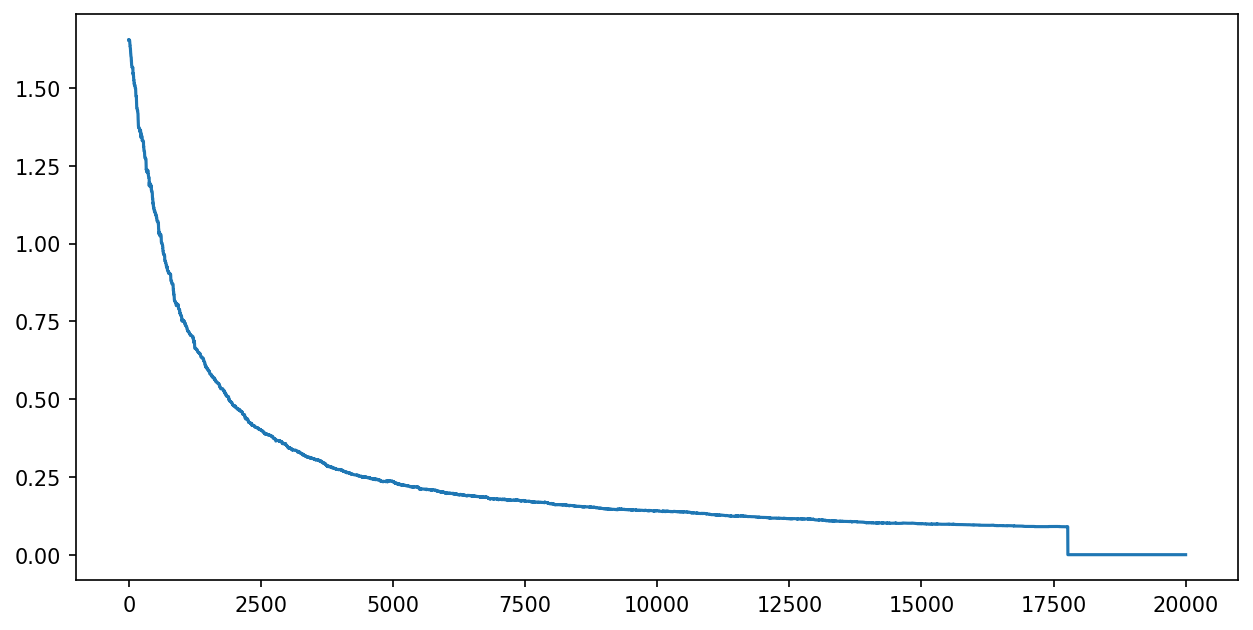

In [107]:
plt.figure(figsize=(10,5), dpi=150)
plt.plot(chi_trace)

In [244]:
import numpy.polynomial.polynomial as poly
def res_func_an(Idata, Iprior, Icross, Iguess, sigqdata):
    a = np.sum(-2 * Icross * 2 * (Idata - Iprior) / sigqdata**2) # zeroth order term
    b = np.sum(-2 * (4 * Icross**2 + 2 * Iguess * (Idata - Iprior)) / sigqdata**2)
    c = np.sum(6 * Iguess * 2 * Icross / sigqdata**2)
    d = np.sum(2 * 2 * Iguess**2 / sigqdata**2)
    eq = poly.Polynomial((a, b, c, d))
    roots = eq.roots()
#     print(f'analytical roots: {roots}')
    chi = np.inf
    root_best = None
    for root_c in roots[np.isreal(roots)]:
        root = root_c.real
        chi_this = np.sum(((Idata - Iprior - Icross * 2 * root - Iguess * root * root) / sigqdata)**2)/Idata.size
        if chi_this < chi:
            chi = chi_this
            root_best = root
#     print(f'analytical gives {chi} at {root_best}')
    return root_best
#     return np.sum(((Idata - Iprior - Icross * 2 * x - Iguess * x * x) / sigqdata)**2)

In [250]:
# Sauter method - use dots to paint electron density - let's make this an actual algorithm
import time

# This is the volume we accumulate density into
rho_ligand_guess = np.zeros_like(rho_apo)
rho_ligand_guess += np.random.random(rho_guess.shape) * 0.3
rho_ligand_guess[~lig_mask] = 0
rho_ligand_guess /= np.sum(rho_ligand_guess)
rho_ligand_guess *= lig_ne

t0 = time.time()
num_steps = 10000

chi_trace = np.zeros(num_steps)

for i in range(num_steps):

    # Generate a rho_guess (gaussian density)
    rho_guess = np.zeros_like(rho_apo)
    while np.abs(rho_guess[lig_mask]).sum() < 0.3:
#         sigma = np.random.random() * 0.5 + 0.1
#         rchoice = np.random.choice(len(mask_xyz))
#         lig_cen = mask_xyz[rchoice]
        lig_cen = np.array([minx + (maxx-minx)*np.random.random(),
                      miny + (maxy-miny)*np.random.random(),
                      minz + (maxz-minz)*np.random.random()])
        rho_guess = dist2_from_cen(lig_cen, x, y, z) < 1.5
        rho_guess = rho_guess * 1 / np.sum(rho_guess)
#         if (i%2) == 0: # Plus step
#             rho_guess = rho_guess * 1 / np.sum(rho_guess)
#         else:
#             rho_guess = rho_guess * -1 / np.sum(rho_guess)

        
#         if np.abs(rho_guess[lig_mask]).sum() < 0.3:
#             print('X', end=' ')
#         else:
#             print(sigma_p, sigma_n, lig_cen)
    
    rho_prior = rho_apo + rho_ligand_guess
    rho_prior_ = np.fft.fftn(rho_prior)
    I3D_prior_ = np.abs(rho_prior_)**2
    Imean_prior_ = saxstats.mybinmean(I3D_prior_, qbin_labels, DENSS_GPU)

    chi_prior = saxstats.mysum(((Imean_prior_[qba]-Idata)/sigqdata)**2, DENSS_GPU=DENSS_GPU)/Idata.size

    rho_guess_ = np.fft.fftn(rho_guess)
    I3D_guess_ = np.abs(rho_guess_)**2
    Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

    I3D_cross_ = (rho_prior_.conjugate() * rho_guess_).real
    Imean_cross_ = saxstats.mybinmean(I3D_cross_, qbin_labels, DENSS_GPU)
    
    res = minimize(res_func, 0, (Idata, Imean_prior_[qba], Imean_cross_[qba], Imean_guess_[qba], sigqdata))
    factor = res.x[0]
#     print(f'Minimizer gives {res.fun / Idata.size}')
#     factor = res_func_an(Idata, Imean_prior_[qba], Imean_cross_[qba], Imean_guess_[qba], sigqdata)
    
    if factor > 20:
        factor = 20 # Cap factor
    rho_guess_mod_ = rho_guess_ * factor
    
    
    
    rho_guess_mod = np.fft.ifftn(rho_guess_mod_).real
    rho_guess_mod[~lig_mask] = 0

    rho_guess_all_ = np.fft.fftn(rho_guess_mod + rho_prior)
    I3D_guess_all_ = np.abs(rho_guess_all_)**2
    Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
    chi_int = np.sum(((Imean_guess_all_[qba]-Idata)/sigqdata)**2)/Idata.size
    print(f'Step {i:3d}, Factor {factor:.2f}: {chi_prior:.3f} -> {chi_int:.3f}', end=' ')

    if chi_int > chi_prior:
        print('bad trial, skip')
        chi_trace[i] = chi_prior
        continue
    else:
        if i%50 == 0 and i > 0:
            print(f'Timing: {time.time() - t0:.2f} s', end=' ')
        rho_ligand_guess += rho_guess_mod
        rho_ligand_guess[rho_ligand_guess < 0] = 0
        rho_ligand_guess[~lig_mask] = 0
        chi_trace[i] = chi_int
        print()


    
# saxstats.write_mrc(rho_ligand_guess/dV, side, 'rho_ligand_guess.mrc')



Step   0, Factor -0.42: 1.617 -> 1.613 
Step   1, Factor 0.03: 1.610 -> 1.610 
Step   2, Factor 0.05: 1.610 -> 1.610 
Step   3, Factor 0.28: 1.610 -> 1.606 
Step   4, Factor -0.07: 1.606 -> 1.606 
Step   5, Factor -0.55: 1.606 -> 1.616 bad trial, skip
Step   6, Factor 0.37: 1.606 -> 1.607 bad trial, skip
Step   7, Factor 0.16: 1.606 -> 1.606 
Step   8, Factor -0.53: 1.606 -> 1.599 
Step   9, Factor 0.41: 1.594 -> 1.590 
Step  10, Factor 0.70: 1.590 -> 1.586 
Step  11, Factor 0.06: 1.586 -> 1.585 
Step  12, Factor -0.09: 1.585 -> 1.583 
Step  13, Factor 0.11: 1.584 -> 1.583 
Step  14, Factor -0.14: 1.583 -> 1.583 
Step  15, Factor -0.35: 1.580 -> 1.583 bad trial, skip
Step  16, Factor 0.03: 1.580 -> 1.580 
Step  17, Factor -0.00: 1.580 -> 1.580 
Step  18, Factor 0.10: 1.580 -> 1.583 bad trial, skip
Step  19, Factor 0.54: 1.580 -> 1.573 
Step  20, Factor -0.09: 1.573 -> 1.573 
Step  21, Factor 0.04: 1.573 -> 1.573 
Step  22, Factor 0.13: 1.573 -> 1.573 
Step  23, Factor -0.11: 1.573 -> 1

Step 192, Factor 0.21: 1.107 -> 1.107 
Step 193, Factor -0.53: 1.107 -> 1.100 
Step 194, Factor 0.04: 1.099 -> 1.099 
Step 195, Factor 0.08: 1.099 -> 1.100 bad trial, skip
Step 196, Factor 0.04: 1.099 -> 1.099 
Step 197, Factor -0.23: 1.099 -> 1.096 
Step 198, Factor 0.05: 1.095 -> 1.095 
Step 199, Factor 0.30: 1.095 -> 1.093 
Step 200, Factor -0.32: 1.093 -> 1.093 bad trial, skip
Step 201, Factor 0.10: 1.093 -> 1.093 
Step 202, Factor -0.05: 1.093 -> 1.093 bad trial, skip
Step 203, Factor 0.27: 1.093 -> 1.091 
Step 204, Factor 0.32: 1.091 -> 1.091 
Step 205, Factor 0.26: 1.091 -> 1.089 
Step 206, Factor -0.19: 1.089 -> 1.088 
Step 207, Factor 0.01: 1.087 -> 1.087 bad trial, skip
Step 208, Factor 0.43: 1.087 -> 1.084 
Step 209, Factor -0.29: 1.084 -> 1.081 
Step 210, Factor -0.02: 1.079 -> 1.079 
Step 211, Factor 0.36: 1.079 -> 1.078 
Step 212, Factor 0.31: 1.078 -> 1.076 
Step 213, Factor 0.71: 1.076 -> 1.076 bad trial, skip
Step 214, Factor 0.72: 1.076 -> 1.086 bad trial, skip
Step 2

Step 386, Factor 0.01: 0.830 -> 0.830 
Step 387, Factor 0.05: 0.830 -> 0.830 
Step 388, Factor 0.24: 0.830 -> 0.829 
Step 389, Factor 0.07: 0.829 -> 0.829 
Step 390, Factor 0.15: 0.829 -> 0.829 
Step 391, Factor 0.10: 0.829 -> 0.829 
Step 392, Factor 0.04: 0.829 -> 0.829 
Step 393, Factor 0.01: 0.829 -> 0.829 
Step 394, Factor 0.25: 0.829 -> 0.829 bad trial, skip
Step 395, Factor 0.55: 0.829 -> 0.825 
Step 396, Factor -0.39: 0.825 -> 0.825 bad trial, skip
Step 397, Factor -0.30: 0.825 -> 0.823 
Step 398, Factor -0.33: 0.821 -> 0.819 
Step 399, Factor -0.61: 0.818 -> 0.814 
Step 400, Factor -0.22: 0.815 -> 0.814 Timing: 48.03 s 
Step 401, Factor -0.16: 0.814 -> 0.815 bad trial, skip
Step 402, Factor -0.25: 0.814 -> 0.813 
Step 403, Factor 0.02: 0.813 -> 0.813 
Step 404, Factor 0.11: 0.813 -> 0.813 
Step 405, Factor 0.38: 0.813 -> 0.811 
Step 406, Factor 0.24: 0.811 -> 0.810 
Step 407, Factor -0.30: 0.810 -> 0.808 
Step 408, Factor -0.24: 0.809 -> 0.809 bad trial, skip
Step 409, Factor -

Step 582, Factor 0.09: 0.653 -> 0.653 
Step 583, Factor 0.10: 0.653 -> 0.654 bad trial, skip
Step 584, Factor -0.03: 0.653 -> 0.653 
Step 585, Factor -0.26: 0.653 -> 0.652 
Step 586, Factor -0.96: 0.653 -> 0.646 
Step 587, Factor 0.06: 0.643 -> 0.643 
Step 588, Factor 0.24: 0.643 -> 0.643 
Step 589, Factor -0.30: 0.643 -> 0.644 bad trial, skip
Step 590, Factor 0.12: 0.643 -> 0.643 
Step 591, Factor -0.21: 0.643 -> 0.642 
Step 592, Factor -0.19: 0.642 -> 0.642 bad trial, skip
Step 593, Factor -0.21: 0.642 -> 0.642 
Step 594, Factor -0.25: 0.642 -> 0.640 
Step 595, Factor -0.23: 0.640 -> 0.640 
Step 596, Factor -0.24: 0.639 -> 0.639 
Step 597, Factor 0.88: 0.638 -> 0.634 
Step 598, Factor -0.21: 0.634 -> 0.634 bad trial, skip
Step 599, Factor 0.11: 0.634 -> 0.634 
Step 600, Factor -0.12: 0.634 -> 0.634 Timing: 71.86 s 
Step 601, Factor 0.03: 0.634 -> 0.634 bad trial, skip
Step 602, Factor -0.12: 0.634 -> 0.633 
Step 603, Factor 0.18: 0.633 -> 0.633 
Step 604, Factor -0.12: 0.633 -> 0.632

Step 774, Factor 0.53: 0.536 -> 0.538 bad trial, skip
Step 775, Factor -0.31: 0.536 -> 0.536 bad trial, skip
Step 776, Factor -0.02: 0.536 -> 0.536 
Step 777, Factor -0.45: 0.536 -> 0.535 
Step 778, Factor -0.41: 0.533 -> 0.533 
Step 779, Factor -0.15: 0.533 -> 0.532 
Step 780, Factor 0.16: 0.532 -> 0.534 bad trial, skip
Step 781, Factor -0.30: 0.532 -> 0.531 
Step 782, Factor 0.32: 0.531 -> 0.533 bad trial, skip
Step 783, Factor -0.00: 0.531 -> 0.531 
Step 784, Factor 0.10: 0.531 -> 0.531 
Step 785, Factor -0.42: 0.531 -> 0.530 
Step 786, Factor -0.86: 0.532 -> 0.528 
Step 787, Factor -0.44: 0.529 -> 0.529 bad trial, skip
Step 788, Factor 0.07: 0.529 -> 0.528 
Step 789, Factor 0.24: 0.528 -> 0.528 
Step 790, Factor 0.12: 0.528 -> 0.528 
Step 791, Factor -0.19: 0.528 -> 0.528 
Step 792, Factor -0.04: 0.528 -> 0.528 
Step 793, Factor 0.33: 0.528 -> 0.527 
Step 794, Factor -0.46: 0.527 -> 0.525 
Step 795, Factor -0.08: 0.525 -> 0.525 
Step 796, Factor 0.15: 0.525 -> 0.525 bad trial, skip

Step 966, Factor 0.35: 0.466 -> 0.467 bad trial, skip
Step 967, Factor 0.21: 0.466 -> 0.466 
Step 968, Factor -0.15: 0.466 -> 0.465 
Step 969, Factor -0.55: 0.465 -> 0.466 bad trial, skip
Step 970, Factor 0.52: 0.465 -> 0.467 bad trial, skip
Step 971, Factor -0.43: 0.465 -> 0.464 
Step 972, Factor 0.59: 0.464 -> 0.463 
Step 973, Factor -0.63: 0.463 -> 0.461 
Step 974, Factor -0.07: 0.462 -> 0.462 
Step 975, Factor -0.11: 0.462 -> 0.462 
Step 976, Factor -0.19: 0.462 -> 0.462 
Step 977, Factor 0.43: 0.461 -> 0.461 
Step 978, Factor 0.28: 0.461 -> 0.460 
Step 979, Factor 0.04: 0.460 -> 0.460 
Step 980, Factor 0.13: 0.460 -> 0.460 
Step 981, Factor 0.53: 0.460 -> 0.458 
Step 982, Factor 0.19: 0.458 -> 0.458 
Step 983, Factor -0.07: 0.458 -> 0.458 
Step 984, Factor 0.15: 0.458 -> 0.458 
Step 985, Factor -0.43: 0.458 -> 0.457 
Step 986, Factor -0.33: 0.457 -> 0.456 
Step 987, Factor 0.13: 0.456 -> 0.457 bad trial, skip
Step 988, Factor 0.04: 0.456 -> 0.456 bad trial, skip
Step 989, Factor -

Step 1154, Factor -0.17: 0.420 -> 0.420 bad trial, skip
Step 1155, Factor 0.14: 0.420 -> 0.420 
Step 1156, Factor 1.04: 0.420 -> 0.417 
Step 1157, Factor -0.19: 0.417 -> 0.417 
Step 1158, Factor -0.52: 0.417 -> 0.416 
Step 1159, Factor -0.05: 0.416 -> 0.416 
Step 1160, Factor -0.11: 0.416 -> 0.416 
Step 1161, Factor 0.33: 0.416 -> 0.417 bad trial, skip
Step 1162, Factor 0.16: 0.416 -> 0.416 
Step 1163, Factor -0.57: 0.416 -> 0.416 
Step 1164, Factor -0.07: 0.415 -> 0.415 
Step 1165, Factor 0.22: 0.415 -> 0.415 
Step 1166, Factor -0.54: 0.415 -> 0.414 
Step 1167, Factor -0.04: 0.414 -> 0.414 
Step 1168, Factor -0.54: 0.414 -> 0.412 
Step 1169, Factor -0.18: 0.412 -> 0.412 
Step 1170, Factor 0.22: 0.412 -> 0.412 
Step 1171, Factor -0.06: 0.412 -> 0.412 
Step 1172, Factor -0.06: 0.412 -> 0.412 
Step 1173, Factor 0.26: 0.412 -> 0.411 
Step 1174, Factor -0.12: 0.411 -> 0.411 
Step 1175, Factor -0.02: 0.412 -> 0.412 
Step 1176, Factor -0.34: 0.412 -> 0.411 
Step 1177, Factor -0.31: 0.411 -> 

Step 1342, Factor 0.42: 0.368 -> 0.368 
Step 1343, Factor 0.07: 0.368 -> 0.367 
Step 1344, Factor -0.90: 0.367 -> 0.367 
Step 1345, Factor -0.17: 0.367 -> 0.367 
Step 1346, Factor 0.34: 0.367 -> 0.367 
Step 1347, Factor 0.23: 0.367 -> 0.368 bad trial, skip
Step 1348, Factor 0.59: 0.367 -> 0.366 
Step 1349, Factor 0.15: 0.366 -> 0.366 
Step 1350, Factor -0.02: 0.366 -> 0.366 Timing: 161.06 s 
Step 1351, Factor -0.18: 0.366 -> 0.366 
Step 1352, Factor -0.60: 0.366 -> 0.365 
Step 1353, Factor 0.05: 0.365 -> 0.365 bad trial, skip
Step 1354, Factor -0.05: 0.365 -> 0.365 
Step 1355, Factor -0.63: 0.365 -> 0.366 bad trial, skip
Step 1356, Factor -0.28: 0.365 -> 0.365 
Step 1357, Factor 0.19: 0.365 -> 0.365 
Step 1358, Factor -0.50: 0.365 -> 0.364 
Step 1359, Factor -0.80: 0.365 -> 0.364 
Step 1360, Factor -0.73: 0.363 -> 0.363 
Step 1361, Factor -0.15: 0.363 -> 0.363 
Step 1362, Factor 0.11: 0.363 -> 0.363 
Step 1363, Factor -0.68: 0.363 -> 0.362 
Step 1364, Factor 0.06: 0.363 -> 0.363 bad tr

Step 1530, Factor 0.30: 0.326 -> 0.325 
Step 1531, Factor 0.18: 0.325 -> 0.326 bad trial, skip
Step 1532, Factor 0.07: 0.325 -> 0.325 bad trial, skip
Step 1533, Factor 0.16: 0.325 -> 0.326 bad trial, skip
Step 1534, Factor 1.07: 0.325 -> 0.324 
Step 1535, Factor -0.22: 0.324 -> 0.324 
Step 1536, Factor 0.01: 0.324 -> 0.324 
Step 1537, Factor 0.02: 0.324 -> 0.324 
Step 1538, Factor 0.62: 0.324 -> 0.323 
Step 1539, Factor 0.30: 0.323 -> 0.323 
Step 1540, Factor -0.24: 0.323 -> 0.323 
Step 1541, Factor -0.09: 0.323 -> 0.323 
Step 1542, Factor -0.13: 0.323 -> 0.323 bad trial, skip
Step 1543, Factor -0.70: 0.323 -> 0.322 
Step 1544, Factor 0.64: 0.322 -> 0.321 
Step 1545, Factor 0.41: 0.321 -> 0.320 
Step 1546, Factor -0.33: 0.320 -> 0.320 
Step 1547, Factor 0.77: 0.320 -> 0.318 
Step 1548, Factor 0.32: 0.318 -> 0.318 
Step 1549, Factor 0.23: 0.318 -> 0.318 bad trial, skip
Step 1550, Factor -0.23: 0.318 -> 0.318 bad trial, skip
Step 1551, Factor -0.21: 0.318 -> 0.317 
Step 1552, Factor 0.59

Step 1716, Factor 0.08: 0.289 -> 0.289 bad trial, skip
Step 1717, Factor 0.44: 0.289 -> 0.288 
Step 1718, Factor -0.07: 0.288 -> 0.288 
Step 1719, Factor -0.13: 0.288 -> 0.288 
Step 1720, Factor 0.05: 0.288 -> 0.288 bad trial, skip
Step 1721, Factor 0.07: 0.288 -> 0.288 
Step 1722, Factor 0.93: 0.288 -> 0.289 bad trial, skip
Step 1723, Factor -0.38: 0.288 -> 0.287 
Step 1724, Factor -0.51: 0.287 -> 0.288 bad trial, skip
Step 1725, Factor -0.43: 0.287 -> 0.287 
Step 1726, Factor 0.85: 0.287 -> 0.287 
Step 1727, Factor -0.47: 0.287 -> 0.286 
Step 1728, Factor 0.11: 0.286 -> 0.286 
Step 1729, Factor -0.61: 0.286 -> 0.286 
Step 1730, Factor 0.34: 0.286 -> 0.286 bad trial, skip
Step 1731, Factor -0.19: 0.286 -> 0.286 
Step 1732, Factor 0.61: 0.286 -> 0.285 
Step 1733, Factor 0.63: 0.285 -> 0.285 
Step 1734, Factor -0.26: 0.285 -> 0.285 
Step 1735, Factor 0.36: 0.285 -> 0.285 
Step 1736, Factor 0.22: 0.285 -> 0.285 
Step 1737, Factor 0.16: 0.285 -> 0.285 
Step 1738, Factor 0.00: 0.285 -> 0.2

Step 1902, Factor 0.50: 0.262 -> 0.262 
Step 1903, Factor 0.09: 0.262 -> 0.262 
Step 1904, Factor 0.20: 0.262 -> 0.262 
Step 1905, Factor -0.22: 0.262 -> 0.262 
Step 1906, Factor -0.20: 0.262 -> 0.262 
Step 1907, Factor -0.11: 0.262 -> 0.262 
Step 1908, Factor -0.37: 0.262 -> 0.261 
Step 1909, Factor -0.86: 0.262 -> 0.261 
Step 1910, Factor -0.33: 0.261 -> 0.262 bad trial, skip
Step 1911, Factor 0.24: 0.261 -> 0.261 
Step 1912, Factor -0.58: 0.261 -> 0.260 
Step 1913, Factor 0.81: 0.261 -> 0.262 bad trial, skip
Step 1914, Factor -0.06: 0.261 -> 0.261 
Step 1915, Factor -0.01: 0.261 -> 0.261 bad trial, skip
Step 1916, Factor 0.85: 0.261 -> 0.263 bad trial, skip
Step 1917, Factor 0.48: 0.261 -> 0.261 
Step 1918, Factor -0.61: 0.261 -> 0.260 
Step 1919, Factor 0.22: 0.261 -> 0.261 
Step 1920, Factor 0.30: 0.261 -> 0.260 
Step 1921, Factor 0.36: 0.260 -> 0.260 
Step 1922, Factor -0.02: 0.260 -> 0.260 
Step 1923, Factor 0.18: 0.260 -> 0.260 bad trial, skip
Step 1924, Factor -0.30: 0.260 -> 

Step 2092, Factor 0.22: 0.234 -> 0.234 bad trial, skip
Step 2093, Factor -1.24: 0.234 -> 0.234 bad trial, skip
Step 2094, Factor 0.73: 0.234 -> 0.234 bad trial, skip
Step 2095, Factor 0.56: 0.234 -> 0.234 
Step 2096, Factor -0.78: 0.234 -> 0.234 bad trial, skip
Step 2097, Factor 0.43: 0.234 -> 0.235 bad trial, skip
Step 2098, Factor 0.59: 0.234 -> 0.234 bad trial, skip
Step 2099, Factor 0.14: 0.234 -> 0.234 
Step 2100, Factor 0.21: 0.234 -> 0.234 bad trial, skip
Step 2101, Factor -0.64: 0.234 -> 0.233 
Step 2102, Factor -0.87: 0.234 -> 0.233 
Step 2103, Factor -0.46: 0.234 -> 0.233 
Step 2104, Factor 0.33: 0.233 -> 0.234 bad trial, skip
Step 2105, Factor 0.31: 0.233 -> 0.234 bad trial, skip
Step 2106, Factor -0.20: 0.233 -> 0.233 
Step 2107, Factor -0.39: 0.233 -> 0.233 
Step 2108, Factor -0.21: 0.233 -> 0.233 
Step 2109, Factor -0.38: 0.233 -> 0.233 
Step 2110, Factor -0.49: 0.233 -> 0.232 
Step 2111, Factor 0.16: 0.233 -> 0.233 
Step 2112, Factor -0.70: 0.233 -> 0.232 
Step 2113, Fac

Step 2276, Factor -0.27: 0.210 -> 0.210 
Step 2277, Factor -0.29: 0.210 -> 0.210 
Step 2278, Factor 0.07: 0.210 -> 0.210 
Step 2279, Factor -0.14: 0.210 -> 0.210 
Step 2280, Factor -0.13: 0.210 -> 0.210 bad trial, skip
Step 2281, Factor 0.28: 0.210 -> 0.210 
Step 2282, Factor -0.73: 0.210 -> 0.209 
Step 2283, Factor -0.16: 0.210 -> 0.210 
Step 2284, Factor -0.14: 0.210 -> 0.209 
Step 2285, Factor -0.73: 0.209 -> 0.209 
Step 2286, Factor 0.10: 0.209 -> 0.210 bad trial, skip
Step 2287, Factor 0.26: 0.209 -> 0.210 bad trial, skip
Step 2288, Factor -1.04: 0.209 -> 0.208 
Step 2289, Factor -0.63: 0.210 -> 0.210 bad trial, skip
Step 2290, Factor 0.07: 0.210 -> 0.210 bad trial, skip
Step 2291, Factor -0.06: 0.210 -> 0.210 bad trial, skip
Step 2292, Factor -0.03: 0.210 -> 0.210 
Step 2293, Factor -0.60: 0.210 -> 0.209 
Step 2294, Factor -0.64: 0.210 -> 0.211 bad trial, skip
Step 2295, Factor 0.05: 0.210 -> 0.210 
Step 2296, Factor 0.02: 0.210 -> 0.210 
Step 2297, Factor 0.36: 0.210 -> 0.209 
S

Step 2462, Factor 1.14: 0.199 -> 0.198 
Step 2463, Factor 0.97: 0.198 -> 0.199 bad trial, skip
Step 2464, Factor -0.33: 0.198 -> 0.198 
Step 2465, Factor -0.33: 0.198 -> 0.199 bad trial, skip
Step 2466, Factor -0.11: 0.198 -> 0.198 
Step 2467, Factor 0.40: 0.198 -> 0.198 
Step 2468, Factor -0.04: 0.198 -> 0.198 
Step 2469, Factor 0.03: 0.198 -> 0.198 bad trial, skip
Step 2470, Factor 0.03: 0.198 -> 0.198 
Step 2471, Factor 0.08: 0.198 -> 0.198 
Step 2472, Factor -0.53: 0.198 -> 0.198 bad trial, skip
Step 2473, Factor -0.23: 0.198 -> 0.198 
Step 2474, Factor -0.24: 0.198 -> 0.198 bad trial, skip
Step 2475, Factor 0.27: 0.198 -> 0.198 
Step 2476, Factor -0.19: 0.198 -> 0.198 bad trial, skip
Step 2477, Factor -0.24: 0.198 -> 0.197 
Step 2478, Factor 0.03: 0.198 -> 0.198 
Step 2479, Factor -0.58: 0.198 -> 0.197 
Step 2480, Factor 1.47: 0.197 -> 0.195 
Step 2481, Factor 0.48: 0.195 -> 0.195 bad trial, skip
Step 2482, Factor -0.05: 0.195 -> 0.195 
Step 2483, Factor 0.16: 0.195 -> 0.195 
Step

Step 2650, Factor 0.13: 0.184 -> 0.184 Timing: 316.84 s 
Step 2651, Factor 0.12: 0.184 -> 0.184 
Step 2652, Factor 0.22: 0.184 -> 0.184 
Step 2653, Factor 0.72: 0.184 -> 0.185 bad trial, skip
Step 2654, Factor -0.22: 0.184 -> 0.183 
Step 2655, Factor -0.63: 0.183 -> 0.183 
Step 2656, Factor -0.52: 0.183 -> 0.183 
Step 2657, Factor -0.16: 0.183 -> 0.183 
Step 2658, Factor -0.14: 0.183 -> 0.183 
Step 2659, Factor -0.35: 0.183 -> 0.183 
Step 2660, Factor 0.53: 0.183 -> 0.184 bad trial, skip
Step 2661, Factor 0.17: 0.183 -> 0.183 bad trial, skip
Step 2662, Factor -0.31: 0.183 -> 0.183 
Step 2663, Factor 0.02: 0.184 -> 0.184 
Step 2664, Factor 0.16: 0.184 -> 0.184 
Step 2665, Factor -0.59: 0.184 -> 0.184 bad trial, skip
Step 2666, Factor 0.19: 0.184 -> 0.184 bad trial, skip
Step 2667, Factor -0.11: 0.184 -> 0.184 
Step 2668, Factor -0.25: 0.183 -> 0.184 bad trial, skip
Step 2669, Factor 0.31: 0.183 -> 0.183 
Step 2670, Factor 0.13: 0.183 -> 0.183 
Step 2671, Factor -0.15: 0.183 -> 0.183 
St

Step 2834, Factor 0.32: 0.174 -> 0.174 bad trial, skip
Step 2835, Factor -0.43: 0.174 -> 0.173 
Step 2836, Factor -0.05: 0.174 -> 0.174 
Step 2837, Factor 0.29: 0.174 -> 0.174 
Step 2838, Factor 0.22: 0.174 -> 0.174 
Step 2839, Factor -0.41: 0.174 -> 0.173 
Step 2840, Factor -0.26: 0.173 -> 0.173 
Step 2841, Factor -0.29: 0.173 -> 0.173 bad trial, skip
Step 2842, Factor -0.10: 0.173 -> 0.173 
Step 2843, Factor -0.01: 0.173 -> 0.173 
Step 2844, Factor -0.11: 0.173 -> 0.173 
Step 2845, Factor 0.13: 0.173 -> 0.173 
Step 2846, Factor -0.42: 0.173 -> 0.173 
Step 2847, Factor -0.05: 0.172 -> 0.172 
Step 2848, Factor -0.15: 0.172 -> 0.172 
Step 2849, Factor -0.15: 0.172 -> 0.172 
Step 2850, Factor 0.18: 0.172 -> 0.172 Timing: 340.72 s 
Step 2851, Factor -0.18: 0.172 -> 0.172 
Step 2852, Factor -0.11: 0.172 -> 0.172 
Step 2853, Factor -0.41: 0.172 -> 0.172 
Step 2854, Factor 0.10: 0.172 -> 0.172 
Step 2855, Factor 0.01: 0.172 -> 0.172 
Step 2856, Factor 0.32: 0.172 -> 0.172 
Step 2857, Factor 

Step 3020, Factor -0.41: 0.159 -> 0.158 
Step 3021, Factor -0.31: 0.159 -> 0.159 bad trial, skip
Step 3022, Factor -0.26: 0.159 -> 0.158 
Step 3023, Factor 0.20: 0.158 -> 0.158 
Step 3024, Factor -0.32: 0.158 -> 0.158 
Step 3025, Factor 0.11: 0.159 -> 0.159 bad trial, skip
Step 3026, Factor -0.16: 0.159 -> 0.159 bad trial, skip
Step 3027, Factor -0.01: 0.159 -> 0.159 
Step 3028, Factor 0.16: 0.159 -> 0.159 
Step 3029, Factor -0.30: 0.159 -> 0.158 
Step 3030, Factor 0.19: 0.159 -> 0.159 bad trial, skip
Step 3031, Factor -0.05: 0.159 -> 0.159 bad trial, skip
Step 3032, Factor 0.38: 0.159 -> 0.159 
Step 3033, Factor 0.24: 0.159 -> 0.159 bad trial, skip
Step 3034, Factor 0.15: 0.159 -> 0.158 
Step 3035, Factor -0.37: 0.158 -> 0.158 
Step 3036, Factor -0.44: 0.159 -> 0.158 
Step 3037, Factor -0.12: 0.159 -> 0.159 
Step 3038, Factor -0.09: 0.159 -> 0.159 bad trial, skip
Step 3039, Factor -0.18: 0.159 -> 0.159 
Step 3040, Factor -0.63: 0.159 -> 0.159 bad trial, skip
Step 3041, Factor -0.02: 0

Step 3208, Factor -0.08: 0.149 -> 0.149 
Step 3209, Factor -0.62: 0.149 -> 0.147 
Step 3210, Factor -0.54: 0.148 -> 0.148 bad trial, skip
Step 3211, Factor -0.33: 0.148 -> 0.148 
Step 3212, Factor -0.34: 0.148 -> 0.148 
Step 3213, Factor -0.38: 0.148 -> 0.148 
Step 3214, Factor 0.34: 0.148 -> 0.148 bad trial, skip
Step 3215, Factor -0.09: 0.148 -> 0.148 
Step 3216, Factor 0.39: 0.148 -> 0.148 
Step 3217, Factor -0.05: 0.148 -> 0.148 
Step 3218, Factor -0.31: 0.148 -> 0.148 
Step 3219, Factor -0.09: 0.148 -> 0.148 
Step 3220, Factor 0.38: 0.148 -> 0.148 bad trial, skip
Step 3221, Factor -0.48: 0.148 -> 0.148 
Step 3222, Factor -0.42: 0.148 -> 0.148 
Step 3223, Factor 0.21: 0.147 -> 0.147 
Step 3224, Factor 0.06: 0.147 -> 0.147 
Step 3225, Factor 0.05: 0.147 -> 0.147 
Step 3226, Factor -0.06: 0.147 -> 0.147 bad trial, skip
Step 3227, Factor -0.02: 0.147 -> 0.147 
Step 3228, Factor -0.17: 0.147 -> 0.147 
Step 3229, Factor 0.05: 0.147 -> 0.147 bad trial, skip
Step 3230, Factor -0.08: 0.147

Step 3394, Factor 0.24: 0.136 -> 0.136 
Step 3395, Factor -0.56: 0.136 -> 0.136 
Step 3396, Factor -0.82: 0.136 -> 0.136 
Step 3397, Factor -0.27: 0.136 -> 0.136 
Step 3398, Factor 0.13: 0.136 -> 0.136 bad trial, skip
Step 3399, Factor -0.46: 0.136 -> 0.136 
Step 3400, Factor 0.27: 0.136 -> 0.136 Timing: 406.66 s 
Step 3401, Factor 0.28: 0.136 -> 0.136 
Step 3402, Factor -0.05: 0.136 -> 0.136 bad trial, skip
Step 3403, Factor -0.73: 0.136 -> 0.135 
Step 3404, Factor -0.71: 0.136 -> 0.135 
Step 3405, Factor -0.63: 0.136 -> 0.135 
Step 3406, Factor 0.34: 0.136 -> 0.136 bad trial, skip
Step 3407, Factor -0.76: 0.136 -> 0.135 
Step 3408, Factor -0.05: 0.136 -> 0.136 bad trial, skip
Step 3409, Factor -0.45: 0.136 -> 0.135 
Step 3410, Factor 0.04: 0.136 -> 0.136 
Step 3411, Factor 0.32: 0.136 -> 0.136 
Step 3412, Factor -0.11: 0.136 -> 0.136 
Step 3413, Factor -0.88: 0.136 -> 0.135 
Step 3414, Factor 0.13: 0.136 -> 0.136 
Step 3415, Factor -0.30: 0.136 -> 0.135 
Step 3416, Factor -0.43: 0.13

Step 3584, Factor -0.23: 0.120 -> 0.120 
Step 3585, Factor -0.26: 0.120 -> 0.120 bad trial, skip
Step 3586, Factor -0.05: 0.120 -> 0.120 bad trial, skip
Step 3587, Factor 0.64: 0.120 -> 0.119 
Step 3588, Factor -0.35: 0.119 -> 0.119 
Step 3589, Factor -0.04: 0.119 -> 0.119 bad trial, skip
Step 3590, Factor -0.87: 0.119 -> 0.119 
Step 3591, Factor -0.52: 0.120 -> 0.119 
Step 3592, Factor -0.15: 0.119 -> 0.119 
Step 3593, Factor -0.16: 0.119 -> 0.119 
Step 3594, Factor -0.14: 0.119 -> 0.119 
Step 3595, Factor 0.72: 0.119 -> 0.119 
Step 3596, Factor 0.13: 0.119 -> 0.119 bad trial, skip
Step 3597, Factor 0.73: 0.119 -> 0.118 
Step 3598, Factor 0.10: 0.118 -> 0.118 bad trial, skip
Step 3599, Factor -0.10: 0.118 -> 0.118 
Step 3600, Factor 0.33: 0.118 -> 0.118 Timing: 430.41 s 
Step 3601, Factor -0.38: 0.118 -> 0.118 
Step 3602, Factor -0.03: 0.118 -> 0.118 
Step 3603, Factor 0.05: 0.118 -> 0.117 
Step 3604, Factor 0.17: 0.117 -> 0.117 
Step 3605, Factor -0.04: 0.117 -> 0.117 
Step 3606, Fac

Step 3772, Factor -0.33: 0.109 -> 0.109 
Step 3773, Factor 0.02: 0.109 -> 0.109 
Step 3774, Factor -0.12: 0.109 -> 0.109 
Step 3775, Factor 0.02: 0.109 -> 0.109 bad trial, skip
Step 3776, Factor -0.08: 0.109 -> 0.109 
Step 3777, Factor -0.49: 0.109 -> 0.109 
Step 3778, Factor 0.35: 0.109 -> 0.109 
Step 3779, Factor -0.24: 0.109 -> 0.109 
Step 3780, Factor -0.04: 0.109 -> 0.109 
Step 3781, Factor -0.15: 0.109 -> 0.109 
Step 3782, Factor -0.53: 0.109 -> 0.108 
Step 3783, Factor 0.10: 0.108 -> 0.108 
Step 3784, Factor 0.32: 0.108 -> 0.108 
Step 3785, Factor 0.06: 0.108 -> 0.108 
Step 3786, Factor -0.17: 0.108 -> 0.108 
Step 3787, Factor -0.24: 0.108 -> 0.108 
Step 3788, Factor -0.07: 0.108 -> 0.108 
Step 3789, Factor 0.75: 0.108 -> 0.108 bad trial, skip
Step 3790, Factor -0.05: 0.108 -> 0.108 
Step 3791, Factor -0.38: 0.108 -> 0.108 
Step 3792, Factor -0.01: 0.108 -> 0.108 bad trial, skip
Step 3793, Factor -0.40: 0.108 -> 0.108 
Step 3794, Factor -0.21: 0.108 -> 0.108 
Step 3795, Factor -

Step 3960, Factor -0.01: 0.099 -> 0.099 
Step 3961, Factor -0.34: 0.099 -> 0.098 
Step 3962, Factor -0.05: 0.099 -> 0.099 
Step 3963, Factor 0.37: 0.099 -> 0.098 
Step 3964, Factor -0.24: 0.098 -> 0.098 
Step 3965, Factor -0.06: 0.098 -> 0.098 
Step 3966, Factor -0.48: 0.098 -> 0.098 
Step 3967, Factor -0.31: 0.098 -> 0.098 
Step 3968, Factor -0.12: 0.098 -> 0.098 
Step 3969, Factor -0.40: 0.098 -> 0.098 
Step 3970, Factor 0.24: 0.098 -> 0.098 
Step 3971, Factor 0.20: 0.098 -> 0.098 bad trial, skip
Step 3972, Factor -0.76: 0.098 -> 0.098 
Step 3973, Factor -0.09: 0.098 -> 0.098 
Step 3974, Factor 0.12: 0.098 -> 0.098 bad trial, skip
Step 3975, Factor -0.54: 0.098 -> 0.098 
Step 3976, Factor 0.60: 0.098 -> 0.098 bad trial, skip
Step 3977, Factor -0.42: 0.098 -> 0.098 
Step 3978, Factor -0.56: 0.098 -> 0.098 bad trial, skip
Step 3979, Factor -0.39: 0.098 -> 0.098 
Step 3980, Factor -0.52: 0.098 -> 0.098 
Step 3981, Factor 0.41: 0.098 -> 0.097 
Step 3982, Factor -0.21: 0.097 -> 0.097 
Ste

Step 4146, Factor -0.51: 0.093 -> 0.092 
Step 4147, Factor 0.01: 0.092 -> 0.092 
Step 4148, Factor 0.09: 0.092 -> 0.092 
Step 4149, Factor -0.06: 0.092 -> 0.092 
Step 4150, Factor -0.00: 0.092 -> 0.092 Timing: 496.85 s 
Step 4151, Factor 0.03: 0.092 -> 0.092 
Step 4152, Factor 0.10: 0.092 -> 0.092 
Step 4153, Factor -0.18: 0.092 -> 0.092 
Step 4154, Factor -0.15: 0.092 -> 0.092 
Step 4155, Factor 0.25: 0.092 -> 0.092 
Step 4156, Factor -0.15: 0.092 -> 0.092 
Step 4157, Factor -0.13: 0.092 -> 0.092 
Step 4158, Factor -0.35: 0.092 -> 0.092 
Step 4159, Factor -0.17: 0.092 -> 0.092 
Step 4160, Factor -0.64: 0.092 -> 0.092 bad trial, skip
Step 4161, Factor -0.19: 0.092 -> 0.092 bad trial, skip
Step 4162, Factor 0.11: 0.092 -> 0.092 
Step 4163, Factor 0.14: 0.092 -> 0.092 
Step 4164, Factor -0.17: 0.092 -> 0.092 
Step 4165, Factor -0.06: 0.092 -> 0.092 bad trial, skip
Step 4166, Factor -0.85: 0.092 -> 0.091 
Step 4167, Factor 0.06: 0.092 -> 0.092 
Step 4168, Factor -0.18: 0.092 -> 0.092 
Ste

Step 4336, Factor -0.54: 0.085 -> 0.085 
Step 4337, Factor -0.26: 0.085 -> 0.085 
Step 4338, Factor -0.20: 0.085 -> 0.085 
Step 4339, Factor -0.14: 0.085 -> 0.085 
Step 4340, Factor -0.24: 0.085 -> 0.085 
Step 4341, Factor -0.15: 0.085 -> 0.085 
Step 4342, Factor -0.02: 0.085 -> 0.085 bad trial, skip
Step 4343, Factor 0.03: 0.085 -> 0.085 
Step 4344, Factor -0.23: 0.085 -> 0.085 
Step 4345, Factor 0.01: 0.085 -> 0.085 
Step 4346, Factor -0.48: 0.085 -> 0.085 bad trial, skip
Step 4347, Factor -0.31: 0.085 -> 0.085 
Step 4348, Factor -0.23: 0.085 -> 0.085 bad trial, skip
Step 4349, Factor 0.67: 0.085 -> 0.085 
Step 4350, Factor 0.19: 0.085 -> 0.085 bad trial, skip
Step 4351, Factor -0.33: 0.085 -> 0.085 
Step 4352, Factor 0.04: 0.085 -> 0.085 
Step 4353, Factor -0.24: 0.085 -> 0.084 
Step 4354, Factor 0.05: 0.084 -> 0.084 
Step 4355, Factor -0.00: 0.084 -> 0.084 
Step 4356, Factor -0.59: 0.084 -> 0.084 bad trial, skip
Step 4357, Factor -0.24: 0.084 -> 0.084 
Step 4358, Factor -0.29: 0.08

Step 4524, Factor -0.05: 0.077 -> 0.077 
Step 4525, Factor -0.11: 0.077 -> 0.077 
Step 4526, Factor -0.21: 0.077 -> 0.077 bad trial, skip
Step 4527, Factor 0.01: 0.077 -> 0.077 bad trial, skip
Step 4528, Factor -0.03: 0.077 -> 0.077 
Step 4529, Factor 0.06: 0.077 -> 0.077 bad trial, skip
Step 4530, Factor -0.04: 0.077 -> 0.077 
Step 4531, Factor -0.47: 0.077 -> 0.076 
Step 4532, Factor -0.13: 0.077 -> 0.077 bad trial, skip
Step 4533, Factor -0.21: 0.077 -> 0.076 
Step 4534, Factor 0.09: 0.076 -> 0.076 
Step 4535, Factor 0.62: 0.076 -> 0.076 
Step 4536, Factor 0.17: 0.076 -> 0.076 
Step 4537, Factor -0.13: 0.076 -> 0.076 
Step 4538, Factor 0.32: 0.076 -> 0.076 
Step 4539, Factor 0.25: 0.076 -> 0.076 
Step 4540, Factor -0.29: 0.076 -> 0.076 
Step 4541, Factor 0.26: 0.076 -> 0.076 
Step 4542, Factor -0.13: 0.076 -> 0.076 
Step 4543, Factor 0.34: 0.076 -> 0.075 
Step 4544, Factor -0.08: 0.075 -> 0.075 
Step 4545, Factor 0.53: 0.075 -> 0.075 
Step 4546, Factor -0.35: 0.075 -> 0.075 
Step 45

Step 4710, Factor -0.06: 0.069 -> 0.069 bad trial, skip
Step 4711, Factor -0.14: 0.069 -> 0.069 
Step 4712, Factor 0.02: 0.069 -> 0.069 
Step 4713, Factor 0.26: 0.069 -> 0.069 bad trial, skip
Step 4714, Factor 0.16: 0.069 -> 0.069 
Step 4715, Factor -0.15: 0.069 -> 0.069 
Step 4716, Factor -0.06: 0.069 -> 0.069 
Step 4717, Factor -0.09: 0.069 -> 0.069 
Step 4718, Factor -0.03: 0.069 -> 0.069 
Step 4719, Factor 0.25: 0.069 -> 0.069 
Step 4720, Factor 0.15: 0.069 -> 0.069 
Step 4721, Factor -0.25: 0.069 -> 0.069 
Step 4722, Factor 0.12: 0.069 -> 0.069 
Step 4723, Factor 0.12: 0.069 -> 0.069 
Step 4724, Factor 0.18: 0.069 -> 0.069 
Step 4725, Factor -0.24: 0.069 -> 0.068 
Step 4726, Factor -0.12: 0.069 -> 0.068 
Step 4727, Factor -0.21: 0.069 -> 0.068 
Step 4728, Factor -0.63: 0.069 -> 0.069 
Step 4729, Factor -0.06: 0.069 -> 0.069 
Step 4730, Factor 0.16: 0.069 -> 0.069 bad trial, skip
Step 4731, Factor -0.27: 0.069 -> 0.069 bad trial, skip
Step 4732, Factor -0.24: 0.069 -> 0.069 
Step 4

Step 4898, Factor -0.26: 0.064 -> 0.064 
Step 4899, Factor 0.09: 0.064 -> 0.064 bad trial, skip
Step 4900, Factor -0.17: 0.064 -> 0.064 bad trial, skip
Step 4901, Factor -0.71: 0.064 -> 0.063 
Step 4902, Factor -0.56: 0.063 -> 0.063 
Step 4903, Factor -0.44: 0.063 -> 0.063 
Step 4904, Factor -0.86: 0.063 -> 0.063 bad trial, skip
Step 4905, Factor 0.18: 0.063 -> 0.063 
Step 4906, Factor 0.20: 0.063 -> 0.063 bad trial, skip
Step 4907, Factor -0.22: 0.063 -> 0.063 
Step 4908, Factor -0.18: 0.063 -> 0.063 
Step 4909, Factor 0.22: 0.063 -> 0.063 
Step 4910, Factor -0.23: 0.063 -> 0.063 
Step 4911, Factor -0.33: 0.063 -> 0.063 
Step 4912, Factor -0.56: 0.063 -> 0.063 
Step 4913, Factor -0.27: 0.063 -> 0.063 
Step 4914, Factor -0.37: 0.063 -> 0.063 
Step 4915, Factor -0.06: 0.063 -> 0.063 
Step 4916, Factor -0.23: 0.063 -> 0.063 
Step 4917, Factor -0.45: 0.063 -> 0.063 bad trial, skip
Step 4918, Factor 0.03: 0.063 -> 0.063 
Step 4919, Factor 0.02: 0.063 -> 0.063 
Step 4920, Factor 0.86: 0.063

Step 5086, Factor -1.01: 0.060 -> 0.060 bad trial, skip
Step 5087, Factor 0.16: 0.060 -> 0.060 
Step 5088, Factor -0.37: 0.060 -> 0.060 
Step 5089, Factor -0.10: 0.060 -> 0.060 
Step 5090, Factor -0.39: 0.060 -> 0.060 
Step 5091, Factor -0.14: 0.060 -> 0.060 
Step 5092, Factor 0.64: 0.060 -> 0.060 bad trial, skip
Step 5093, Factor 0.39: 0.060 -> 0.060 bad trial, skip
Step 5094, Factor -0.19: 0.060 -> 0.060 
Step 5095, Factor -0.03: 0.060 -> 0.060 
Step 5096, Factor -0.64: 0.060 -> 0.059 
Step 5097, Factor -0.36: 0.060 -> 0.060 
Step 5098, Factor -0.15: 0.060 -> 0.060 
Step 5099, Factor 0.14: 0.060 -> 0.060 bad trial, skip
Step 5100, Factor -0.08: 0.060 -> 0.060 Timing: 610.23 s 
Step 5101, Factor -0.10: 0.060 -> 0.060 
Step 5102, Factor -0.41: 0.060 -> 0.060 bad trial, skip
Step 5103, Factor -0.02: 0.060 -> 0.060 
Step 5104, Factor -0.26: 0.060 -> 0.060 
Step 5105, Factor -0.11: 0.060 -> 0.060 
Step 5106, Factor -0.30: 0.060 -> 0.060 
Step 5107, Factor 0.07: 0.060 -> 0.060 
Step 5108, 

Step 5272, Factor -0.10: 0.055 -> 0.055 
Step 5273, Factor 0.05: 0.055 -> 0.055 
Step 5274, Factor -0.06: 0.055 -> 0.055 bad trial, skip
Step 5275, Factor -0.76: 0.055 -> 0.054 
Step 5276, Factor 0.16: 0.055 -> 0.055 
Step 5277, Factor 0.26: 0.055 -> 0.055 
Step 5278, Factor -0.24: 0.055 -> 0.054 
Step 5279, Factor -0.10: 0.055 -> 0.054 
Step 5280, Factor 0.48: 0.055 -> 0.054 
Step 5281, Factor 0.39: 0.054 -> 0.054 
Step 5282, Factor 0.03: 0.054 -> 0.054 
Step 5283, Factor 0.29: 0.054 -> 0.054 
Step 5284, Factor -0.32: 0.054 -> 0.054 
Step 5285, Factor -0.01: 0.054 -> 0.054 bad trial, skip
Step 5286, Factor -0.07: 0.054 -> 0.054 
Step 5287, Factor -0.04: 0.054 -> 0.054 
Step 5288, Factor 0.65: 0.054 -> 0.054 
Step 5289, Factor -0.38: 0.054 -> 0.054 
Step 5290, Factor -0.83: 0.054 -> 0.053 
Step 5291, Factor -0.32: 0.054 -> 0.054 
Step 5292, Factor -0.39: 0.054 -> 0.054 
Step 5293, Factor 0.31: 0.054 -> 0.054 bad trial, skip
Step 5294, Factor -0.64: 0.054 -> 0.053 
Step 5295, Factor 0.3

Step 5460, Factor 0.40: 0.050 -> 0.050 
Step 5461, Factor -0.78: 0.050 -> 0.049 
Step 5462, Factor -0.22: 0.050 -> 0.049 
Step 5463, Factor -0.32: 0.049 -> 0.049 
Step 5464, Factor 0.24: 0.049 -> 0.050 bad trial, skip
Step 5465, Factor 0.01: 0.049 -> 0.049 bad trial, skip
Step 5466, Factor -0.13: 0.049 -> 0.049 bad trial, skip
Step 5467, Factor -0.14: 0.049 -> 0.050 bad trial, skip
Step 5468, Factor -0.45: 0.049 -> 0.049 
Step 5469, Factor -0.05: 0.050 -> 0.050 
Step 5470, Factor 0.35: 0.050 -> 0.050 bad trial, skip
Step 5471, Factor -0.12: 0.050 -> 0.050 
Step 5472, Factor -0.09: 0.050 -> 0.049 
Step 5473, Factor -0.08: 0.050 -> 0.050 
Step 5474, Factor -0.34: 0.050 -> 0.049 
Step 5475, Factor 0.16: 0.050 -> 0.050 bad trial, skip
Step 5476, Factor -0.18: 0.050 -> 0.049 
Step 5477, Factor -0.02: 0.050 -> 0.050 bad trial, skip
Step 5478, Factor -0.21: 0.050 -> 0.049 
Step 5479, Factor -0.14: 0.050 -> 0.050 
Step 5480, Factor -0.01: 0.050 -> 0.050 
Step 5481, Factor -0.25: 0.050 -> 0.049

Step 5648, Factor -0.32: 0.044 -> 0.044 
Step 5649, Factor 0.26: 0.044 -> 0.044 bad trial, skip
Step 5650, Factor 0.51: 0.044 -> 0.044 Timing: 676.26 s 
Step 5651, Factor -0.10: 0.044 -> 0.044 
Step 5652, Factor -0.45: 0.044 -> 0.044 
Step 5653, Factor 0.35: 0.044 -> 0.044 
Step 5654, Factor -0.23: 0.044 -> 0.044 
Step 5655, Factor 0.23: 0.044 -> 0.044 bad trial, skip
Step 5656, Factor -0.05: 0.044 -> 0.044 
Step 5657, Factor -0.30: 0.044 -> 0.044 bad trial, skip
Step 5658, Factor 0.16: 0.044 -> 0.044 
Step 5659, Factor 0.95: 0.044 -> 0.043 
Step 5660, Factor 0.07: 0.043 -> 0.043 
Step 5661, Factor -0.15: 0.043 -> 0.043 bad trial, skip
Step 5662, Factor -0.23: 0.043 -> 0.043 bad trial, skip
Step 5663, Factor 0.45: 0.043 -> 0.043 
Step 5664, Factor -0.47: 0.043 -> 0.043 
Step 5665, Factor -0.10: 0.043 -> 0.043 bad trial, skip
Step 5666, Factor -0.15: 0.043 -> 0.043 
Step 5667, Factor -0.06: 0.043 -> 0.043 bad trial, skip
Step 5668, Factor -0.02: 0.043 -> 0.043 
Step 5669, Factor 0.56: 0

Step 5832, Factor -0.45: 0.038 -> 0.038 
Step 5833, Factor 0.04: 0.038 -> 0.038 
Step 5834, Factor -0.36: 0.038 -> 0.038 
Step 5835, Factor -0.11: 0.038 -> 0.038 bad trial, skip
Step 5836, Factor -0.32: 0.038 -> 0.038 
Step 5837, Factor -0.08: 0.038 -> 0.038 
Step 5838, Factor -0.32: 0.038 -> 0.038 bad trial, skip
Step 5839, Factor 0.11: 0.038 -> 0.038 
Step 5840, Factor 0.54: 0.038 -> 0.038 
Step 5841, Factor -0.52: 0.038 -> 0.037 
Step 5842, Factor -0.62: 0.038 -> 0.037 
Step 5843, Factor -0.48: 0.038 -> 0.037 
Step 5844, Factor -0.34: 0.038 -> 0.037 
Step 5845, Factor 0.16: 0.038 -> 0.038 
Step 5846, Factor -0.66: 0.038 -> 0.037 
Step 5847, Factor -0.06: 0.037 -> 0.037 
Step 5848, Factor -0.12: 0.037 -> 0.037 
Step 5849, Factor -0.72: 0.037 -> 0.037 
Step 5850, Factor -0.04: 0.037 -> 0.037 Timing: 699.91 s 
Step 5851, Factor 0.24: 0.037 -> 0.037 
Step 5852, Factor -0.10: 0.037 -> 0.037 
Step 5853, Factor 0.08: 0.037 -> 0.037 
Step 5854, Factor -0.37: 0.037 -> 0.037 
Step 5855, Facto

Step 6024, Factor -0.04: 0.033 -> 0.033 bad trial, skip
Step 6025, Factor -0.10: 0.033 -> 0.033 bad trial, skip
Step 6026, Factor 0.20: 0.033 -> 0.033 
Step 6027, Factor -0.06: 0.033 -> 0.033 
Step 6028, Factor -0.15: 0.033 -> 0.033 
Step 6029, Factor 0.02: 0.033 -> 0.033 
Step 6030, Factor -0.09: 0.033 -> 0.033 
Step 6031, Factor -0.16: 0.033 -> 0.033 
Step 6032, Factor -0.31: 0.033 -> 0.033 bad trial, skip
Step 6033, Factor -0.12: 0.033 -> 0.033 bad trial, skip
Step 6034, Factor -0.18: 0.033 -> 0.033 
Step 6035, Factor -0.39: 0.033 -> 0.034 bad trial, skip
Step 6036, Factor -0.10: 0.033 -> 0.033 
Step 6037, Factor 0.10: 0.033 -> 0.033 bad trial, skip
Step 6038, Factor 0.20: 0.033 -> 0.033 
Step 6039, Factor -0.06: 0.033 -> 0.033 
Step 6040, Factor 0.13: 0.033 -> 0.033 bad trial, skip
Step 6041, Factor -0.04: 0.033 -> 0.033 
Step 6042, Factor -0.01: 0.033 -> 0.033 
Step 6043, Factor -0.04: 0.033 -> 0.033 
Step 6044, Factor 0.07: 0.033 -> 0.033 
Step 6045, Factor -0.08: 0.033 -> 0.033 

Step 6210, Factor 0.06: 0.031 -> 0.031 bad trial, skip
Step 6211, Factor 0.67: 0.031 -> 0.031 
Step 6212, Factor -0.05: 0.031 -> 0.031 
Step 6213, Factor 0.34: 0.031 -> 0.031 bad trial, skip
Step 6214, Factor 1.06: 0.031 -> 0.030 
Step 6215, Factor -0.10: 0.030 -> 0.030 
Step 6216, Factor -0.18: 0.030 -> 0.030 
Step 6217, Factor 0.39: 0.030 -> 0.030 
Step 6218, Factor -0.31: 0.030 -> 0.029 
Step 6219, Factor -0.71: 0.030 -> 0.029 
Step 6220, Factor -0.72: 0.030 -> 0.029 
Step 6221, Factor -0.33: 0.030 -> 0.029 
Step 6222, Factor -0.15: 0.030 -> 0.030 
Step 6223, Factor -0.04: 0.030 -> 0.030 
Step 6224, Factor -0.30: 0.030 -> 0.030 
Step 6225, Factor -0.61: 0.030 -> 0.029 
Step 6226, Factor 0.28: 0.030 -> 0.029 
Step 6227, Factor -0.24: 0.029 -> 0.029 
Step 6228, Factor -0.44: 0.029 -> 0.029 
Step 6229, Factor -0.15: 0.029 -> 0.029 
Step 6230, Factor -0.20: 0.029 -> 0.029 bad trial, skip
Step 6231, Factor 0.13: 0.029 -> 0.029 bad trial, skip
Step 6232, Factor 0.01: 0.029 -> 0.029 
Step 

Step 6398, Factor 0.66: 0.027 -> 0.027 
Step 6399, Factor -0.09: 0.027 -> 0.027 
Step 6400, Factor -0.05: 0.027 -> 0.027 Timing: 766.37 s 
Step 6401, Factor -0.07: 0.027 -> 0.027 
Step 6402, Factor -0.42: 0.027 -> 0.027 
Step 6403, Factor -0.41: 0.027 -> 0.027 
Step 6404, Factor -0.24: 0.027 -> 0.027 
Step 6405, Factor -0.20: 0.027 -> 0.027 
Step 6406, Factor -0.03: 0.027 -> 0.027 
Step 6407, Factor -0.11: 0.027 -> 0.027 
Step 6408, Factor -0.24: 0.027 -> 0.027 
Step 6409, Factor 0.42: 0.027 -> 0.027 bad trial, skip
Step 6410, Factor 0.25: 0.027 -> 0.027 
Step 6411, Factor -0.04: 0.027 -> 0.027 
Step 6412, Factor 0.26: 0.027 -> 0.027 
Step 6413, Factor 0.00: 0.027 -> 0.027 bad trial, skip
Step 6414, Factor 0.02: 0.027 -> 0.027 
Step 6415, Factor -0.04: 0.027 -> 0.027 
Step 6416, Factor 0.34: 0.027 -> 0.027 
Step 6417, Factor 0.47: 0.027 -> 0.027 bad trial, skip
Step 6418, Factor 0.02: 0.027 -> 0.027 
Step 6419, Factor -0.06: 0.027 -> 0.027 
Step 6420, Factor -0.01: 0.027 -> 0.027 
Step

Step 6584, Factor -0.45: 0.023 -> 0.023 
Step 6585, Factor 0.28: 0.023 -> 0.023 
Step 6586, Factor -0.31: 0.023 -> 0.023 
Step 6587, Factor -0.47: 0.023 -> 0.023 bad trial, skip
Step 6588, Factor -0.73: 0.023 -> 0.023 
Step 6589, Factor -0.51: 0.023 -> 0.023 bad trial, skip
Step 6590, Factor -0.58: 0.023 -> 0.023 
Step 6591, Factor 0.47: 0.023 -> 0.023 
Step 6592, Factor -0.45: 0.023 -> 0.023 
Step 6593, Factor -0.17: 0.023 -> 0.023 
Step 6594, Factor -1.15: 0.023 -> 0.023 
Step 6595, Factor -0.24: 0.023 -> 0.023 
Step 6596, Factor 0.07: 0.023 -> 0.023 
Step 6597, Factor 0.26: 0.023 -> 0.023 
Step 6598, Factor 0.27: 0.023 -> 0.023 
Step 6599, Factor -0.14: 0.023 -> 0.023 
Step 6600, Factor -0.70: 0.023 -> 0.023 Timing: 790.17 s 
Step 6601, Factor -0.32: 0.023 -> 0.023 
Step 6602, Factor -0.03: 0.023 -> 0.023 
Step 6603, Factor -0.33: 0.023 -> 0.023 
Step 6604, Factor 0.09: 0.023 -> 0.023 
Step 6605, Factor -0.67: 0.023 -> 0.023 
Step 6606, Factor -1.06: 0.023 -> 0.023 bad trial, skip
S

Step 6768, Factor -0.33: 0.021 -> 0.021 
Step 6769, Factor 0.08: 0.021 -> 0.021 
Step 6770, Factor 0.38: 0.021 -> 0.021 bad trial, skip
Step 6771, Factor 0.25: 0.021 -> 0.021 
Step 6772, Factor -0.39: 0.021 -> 0.021 
Step 6773, Factor -0.14: 0.021 -> 0.021 
Step 6774, Factor -0.50: 0.021 -> 0.021 bad trial, skip
Step 6775, Factor -0.28: 0.021 -> 0.021 
Step 6776, Factor -0.77: 0.021 -> 0.021 
Step 6777, Factor -0.15: 0.021 -> 0.021 
Step 6778, Factor -0.17: 0.021 -> 0.021 
Step 6779, Factor -0.53: 0.021 -> 0.021 
Step 6780, Factor -0.05: 0.021 -> 0.021 
Step 6781, Factor -0.61: 0.021 -> 0.021 
Step 6782, Factor -0.39: 0.021 -> 0.021 
Step 6783, Factor -0.09: 0.021 -> 0.021 
Step 6784, Factor -0.06: 0.021 -> 0.021 bad trial, skip
Step 6785, Factor -0.10: 0.021 -> 0.021 
Step 6786, Factor -0.11: 0.021 -> 0.021 
Step 6787, Factor 0.19: 0.021 -> 0.021 
Step 6788, Factor -0.49: 0.021 -> 0.021 
Step 6789, Factor -0.14: 0.021 -> 0.021 
Step 6790, Factor -0.32: 0.021 -> 0.021 
Step 6791, Facto

Step 6954, Factor 0.13: 0.019 -> 0.019 
Step 6955, Factor -0.04: 0.019 -> 0.019 
Step 6956, Factor -0.13: 0.019 -> 0.019 
Step 6957, Factor -0.54: 0.019 -> 0.019 
Step 6958, Factor 0.10: 0.019 -> 0.019 
Step 6959, Factor 0.02: 0.019 -> 0.019 
Step 6960, Factor 0.31: 0.019 -> 0.019 bad trial, skip
Step 6961, Factor -0.16: 0.019 -> 0.019 
Step 6962, Factor 1.08: 0.019 -> 0.019 bad trial, skip
Step 6963, Factor -0.37: 0.019 -> 0.019 
Step 6964, Factor -0.27: 0.019 -> 0.019 
Step 6965, Factor -0.08: 0.019 -> 0.019 
Step 6966, Factor -0.24: 0.019 -> 0.019 
Step 6967, Factor -0.02: 0.019 -> 0.019 
Step 6968, Factor -0.19: 0.019 -> 0.019 
Step 6969, Factor -0.01: 0.019 -> 0.019 
Step 6970, Factor -0.20: 0.019 -> 0.019 
Step 6971, Factor 0.07: 0.019 -> 0.019 bad trial, skip
Step 6972, Factor 0.63: 0.019 -> 0.019 
Step 6973, Factor -0.18: 0.019 -> 0.019 
Step 6974, Factor -0.50: 0.019 -> 0.018 
Step 6975, Factor 0.14: 0.019 -> 0.019 
Step 6976, Factor 0.54: 0.019 -> 0.019 
Step 6977, Factor -0.

Step 7142, Factor 0.04: 0.017 -> 0.017 bad trial, skip
Step 7143, Factor -0.47: 0.017 -> 0.017 
Step 7144, Factor -0.32: 0.017 -> 0.017 
Step 7145, Factor -0.61: 0.017 -> 0.017 
Step 7146, Factor -0.73: 0.017 -> 0.016 
Step 7147, Factor 0.24: 0.017 -> 0.017 
Step 7148, Factor 0.21: 0.017 -> 0.016 
Step 7149, Factor -0.40: 0.016 -> 0.016 
Step 7150, Factor -0.39: 0.016 -> 0.016 Timing: 855.51 s 
Step 7151, Factor -0.35: 0.016 -> 0.016 
Step 7152, Factor 0.06: 0.016 -> 0.016 
Step 7153, Factor -0.06: 0.016 -> 0.016 
Step 7154, Factor -0.42: 0.016 -> 0.016 
Step 7155, Factor -0.15: 0.016 -> 0.016 
Step 7156, Factor -0.59: 0.016 -> 0.017 bad trial, skip
Step 7157, Factor -0.17: 0.016 -> 0.016 bad trial, skip
Step 7158, Factor -0.26: 0.016 -> 0.016 
Step 7159, Factor -0.37: 0.016 -> 0.016 
Step 7160, Factor 0.17: 0.016 -> 0.016 bad trial, skip
Step 7161, Factor 0.18: 0.016 -> 0.016 bad trial, skip
Step 7162, Factor -0.42: 0.016 -> 0.016 
Step 7163, Factor 0.03: 0.016 -> 0.016 
Step 7164, Fa

KeyboardInterrupt: 

In [251]:
saxstats.write_mrc(rho_ligand_guess/dV, side, 'rho_ligand_guess6.mrc')

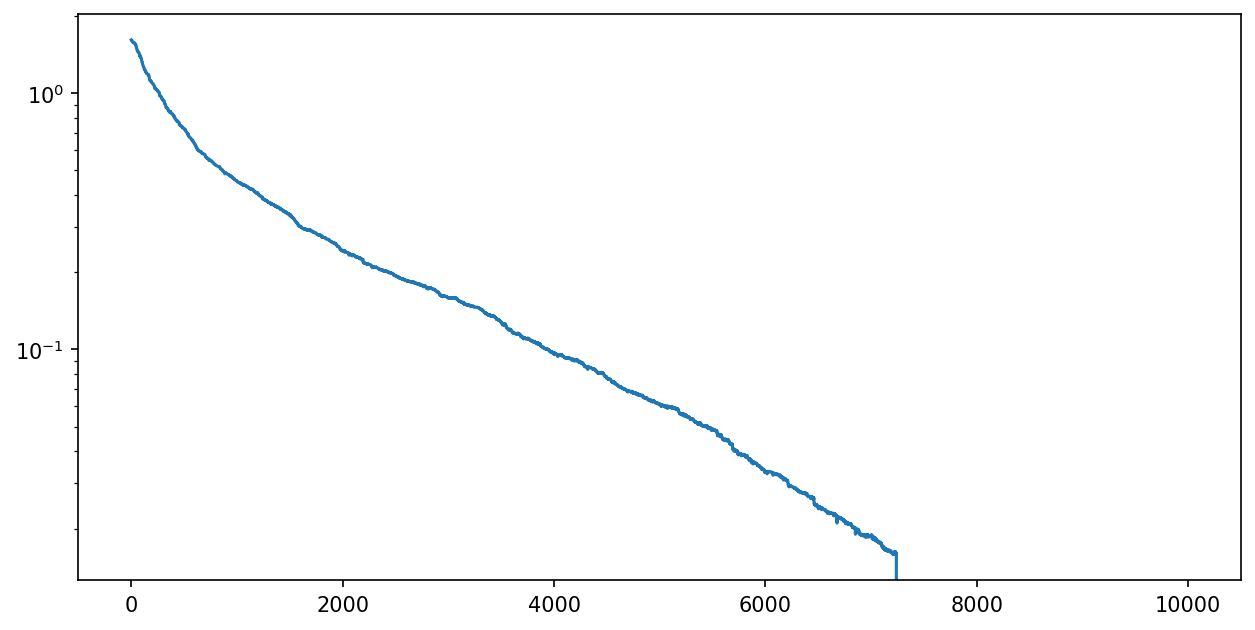

In [254]:
plt.figure(figsize=(10,5), dpi=150)
plt.plot(chi_trace)
plt.yscale('log')

In [ ]:
print(chi_t)

In [18]:
mask_xyz = np.array([x.flatten(), y.flatten(), z.flatten()]).T[lig_mask.flatten()]

In [109]:
def chi2_func(x, 
              Idata, sigqdata,
              ref_rho, rho_guess, lig_mask, 
              qbin_labels, qba):
    rho_guess[lig_mask] = x
    
    rho_exp_ = np.fft.fftn(ref_rho + rho_guess)
    I3D_exp_ = np.abs(rho_exp_)**2
    Imean_exp_ = saxstats.mybinmean(I3D_exp_, qbin_labels, False)
    chi = saxstats.mysum(((Imean_exp_[qba]-Idata)/sigqdata)**2, False)/Idata.size
    
    return chi

In [131]:
# Sauter method - use dots to paint electron density - let's make this an actual algorithm
import time

x0 = np.random.random(np.sum(lig_mask))
x0 = x0 / np.sum(x0) * lig_ne
x0_bounds = [(0, None) for x in x0]
rho_guess = np.zeros_like(rho_apo)
res = minimize(chi2_func, x0, 
               (Idata, sigqdata, rho_apo, rho_guess, lig_mask, qbin_labels, qba), 
               method='L-BFGS-B', bounds=x0_bounds, #tol=3e-2,
               options={'disp': True, 'maxfun': 100000, 'maxiter':100000})




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3545     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07821D+00    |proj g|=  5.48766D-01

At iterate    1    f=  6.62030D-01    |proj g|=  8.97335D-02

At iterate    2    f=  6.16660D-01    |proj g|=  1.15505D-01

At iterate    3    f=  5.81438D-01    |proj g|=  5.99621D-02

At iterate    4    f=  5.51313D-01    |proj g|=  2.28541D-02

At iterate    5    f=  5.41870D-01    |proj g|=  1.73411D-02

At iterate    6    f=  4.98684D-01    |proj g|=  2.49776D-02

At iterate    7    f=  4.18216D-01    |proj g|=  3.09479D-02

At iterate    8    f=  3.58504D-01    |proj g|=  4.93746D-02

At iterate    9    f=  2.93998D-01    |proj g|=  3.39823D-02

At iterate   10    f=  2.66109D-01    |proj g|=  2.55273D-02

At iterate   11    f=  2.50436D-01    |proj g|=  1.58920D-02

At iterate   12    f=  2.36922D-01    |proj g|=  2.61361D-02

At iterate   13    f=  2.1

In [132]:
res.x

array([0.00052406, 0.        , 0.        , ..., 0.        , 0.00731144,
       0.00312746])

In [133]:
rho_guess[lig_mask] = res.x
saxstats.write_mrc(rho_guess/dV, side, 'rho_ligand_guess4.mrc')

In [321]:
x = np.linspace(0, 10, num=101)

In [322]:
y = np.exp(-40 * (x-5)**2)

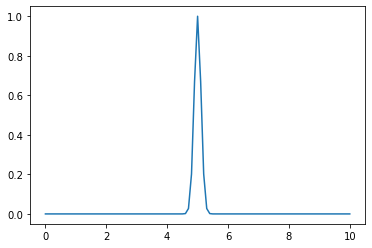

In [323]:
plt.plot(x, y)

In [324]:
y_ = np.fft.fftn(y)
# y_ = np.fft.fftshift(y_)

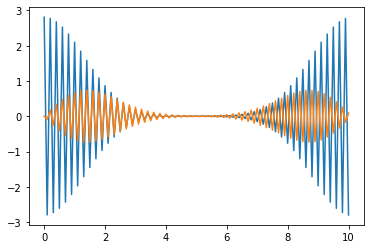

In [325]:
plt.plot(x, y_.real)
plt.plot(x, y_.imag)

In [326]:
y_mod_ = y_ * 1.1
y_mod = np.fft.ifftn(y_mod_)

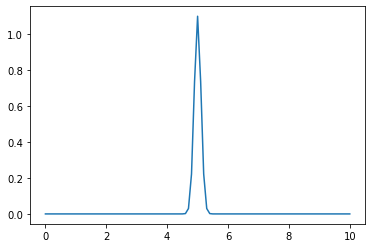

In [329]:
plt.plot(x, y_mod.real)